# Dog breeds classification

In this notebook I tried to classify dog breed using the Stanford dog dataset with two differents methods.
The first one use a classical approach using bags of features with visual words and applying a classification algorithm like SVM.
The second one is the classification using transfer learning with a CNN (Convolution Neural Network).

First I import all the libraries :

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
#from scipy import stats
import tarfile 
import scipy.io
import cv2
import os

%matplotlib inline 

## Preprocessing images

### Example

Before starting with all the dataset, let's have an idea of all changes I apply to an image :

In [2]:
# First image in the dataset
img = cv2.imread('../data/Images/n02086240-Shih-Tzu/n02086240_1011.jpg')

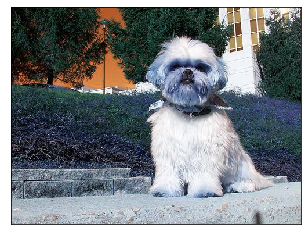

In [3]:
plt.imshow(img)
plt.xticks([]), plt.yticks([])
plt.show()

#### 1. Centering the image on the dog 

To improve my classification algorithms I will first recenter the image on the dog (the Standard dog dataset provide us the exact position of the dog) to drop all features which can be generate by the surroundings.

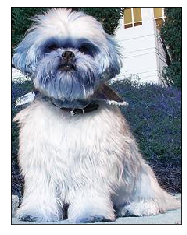

In [4]:
img = img[51:331, 232:451]
plt.imshow(img)
plt.xticks([]), plt.yticks([])
plt.show()

#### 2. Resizing image

All images are not necessarly the same size which can be really problematic in further treatments. Furthermore, the CNN I will later use using transfer learning need a fix image size of .  

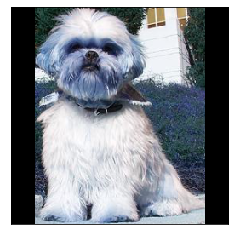

In [5]:
# Cropping and padding the image to a standard size of 256
desired_size = 256

old_size = img.shape[:2] 

ratio = float(desired_size)/max(old_size)
new_size = tuple([int(x*ratio) for x in old_size])

img = cv2.resize(img, (new_size[1], new_size[0]))

delta_w = desired_size - new_size[1]
delta_h = desired_size - new_size[0]
top, bottom = delta_h//2, delta_h-(delta_h//2)
left, right = delta_w//2, delta_w-(delta_w//2)

color = [0, 0, 0]
img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT,
    value=color)

plt.imshow(img)

plt.xticks([]), plt.yticks([])
plt.show()

#### 3. Histogram equalization

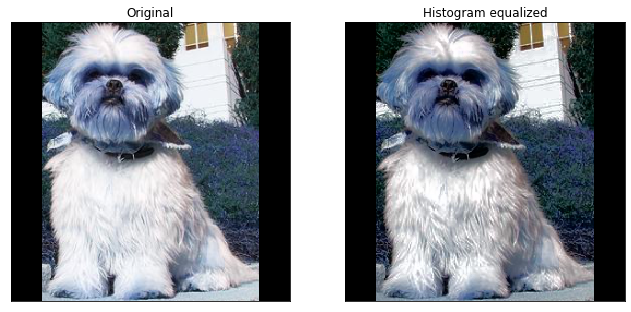

In [18]:
img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)

# equalize the histogram of the Y channel
img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])

# convert the YUV image back to RGB format
img_equal = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)

plt.figure(figsize=(11,6))
plt.subplot(121), plt.imshow(img),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(img_equal),plt.title('Histogram equalized')
plt.xticks([]), plt.yticks([])
plt.show()

#### 4. Gaussian filter to reduce the noise and improve edge detection  

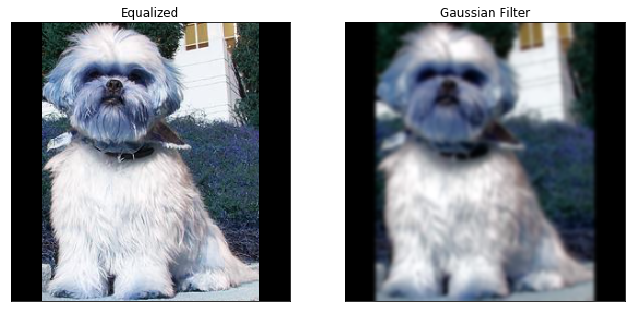

In [7]:
figure_size = 9

img_gaussian = cv2.GaussianBlur(img_equal, (figure_size, figure_size),0)

plt.figure(figsize=(11,6))
plt.subplot(121), plt.imshow(img),plt.title('Equalized')
plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(img_gaussian),plt.title('Gaussian Filter')
plt.xticks([]), plt.yticks([])
plt.show()

### Preprocessing

In the following I apply the same methods seen in the above example to all the dataset and save the resulting image in a new folder called preprocessed images.

In [66]:
# Creating new folders for preprocessed images
img_path = '../data/Images/'
for r, d, f in os.walk(img_path):
    dirs = r.split(os.path.sep)[-1]
    processed_path = os.path.join('../data', 'processed_images', dirs) 
    os.mkdir(processed_path)

In [4]:
# Fonction for resizing image
desired_size = 256

def resize(img):
    # old_size is in (height, width) format
    old_size = img.shape[:2] 

    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])

    # new_size should be in (width, height) format
    img = cv2.resize(img, (new_size[1], new_size[0]))
    
    # adding black padding when original image is smaller than the dezired size
    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    color = [0, 0, 0]
    new_img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT,
        value=color)
    
    return new_img

In [5]:
from lxml import etree 
import random

img_path = '../data/Images/'
df = pd.DataFrame(columns=['img', 'breed'])
sift = cv2.xfeatures2d.SIFT_create()

for r, d, f in os.walk(img_path):
    for file in f:
        ### Annotation information
        # associated annotation path
        path = os.path.join(r, file)[15:-4]
        annotation = os.path.join('../data', 'Annotation', path)
        # dictionnary of coordinates to crop the image to the dog part
        tree = etree.parse(annotation)
        for x in tree.xpath('./object/bndbox'):
            l = x.getchildren()
            dim = {'xmin':int(l[0].text), 'ymin':int(l[1].text), 
                   'xmax':int(l[2].text), 'ymax':int(l[3].text)}
        # breed 
        for x in tree.xpath('./object/name'):
            breed = x.text
        
        ### Processing
        image = cv2.imread(os.path.join(r, file))  
        # get dimension 
        xmin = dim['xmin']
        xmax = dim['xmax']
        ymin = dim['ymin']
        ymax = dim['ymax']
        # cropping
        img_crop = image[ymin:ymax, xmin:xmax]
        # resizing
        img_resize = resize(img_crop)
        # histogram equalization
        img_yuv = cv2.cvtColor(img_resize, cv2.COLOR_BGR2YUV)
        img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
        img_equal = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
        # gaussian filter 
        img_gaussian = cv2.GaussianBlur(img_equal, (9, 9),0)
        # saving processed images
        img = img_gaussian.copy()
        new_path = os.path.join('../data','Processed',path +'.jpg')
        cv2.imwrite(new_path, img)
        # append to the dataframe
        df = df.append({'img': img, 'breed': breed}, ignore_index=True)        

Before starting the classification I split the data in train, validation and test with scikit-learn.

### Split train, test, val

In [6]:
X = df.img
y = df.breed

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state = 0)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size = 0.4, random_state = 0)

df_train = pd.DataFrame(df, index=X_train.index)
df_val = pd.DataFrame(df, index=X_val.index)
df_test = pd.DataFrame(df, index=X_test.index)

Let's now proceed to classification. 

## Classical approach

Before CNN became a major outbreak in image classification, classical methods were used with more or less satisfying results. You will see at the end of this notebook the performance gap between these two methods.  
But first let me detail what I did in this part.  
Like every classification problem we need some features, when it comes to image classification, features are part of the image which are relevant like corner, border, particular point... Here we use the SIFT descriptor( 


In [7]:
descriptor_list = []

def descriptor(df):
    for img in df.img:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        keypoint, descriptor = sift.detectAndCompute(img, None)
        for k in range(descriptor.shape[0]):
            descriptor_list.append(descriptor[k].astype('int32'))
    return descriptor_list

descriptor_train = descriptor(df_train)
descriptor_train = pd.DataFrame(descriptor_train)

KeyboardInterrupt: 

In [9]:
descriptor_train.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,1,0,0,0,0,0,0,0,159,7,...,0,19,9,55,136,23,4,0,0,1
1,11,0,0,0,0,0,0,7,117,19,...,0,14,57,47,21,0,0,0,0,5
2,89,31,0,0,0,0,0,1,153,153,...,0,0,3,3,0,0,0,0,0,0
3,58,1,0,0,0,0,0,3,176,26,...,37,98,1,0,0,0,0,6,61,22
4,98,25,0,0,0,0,0,0,173,143,...,45,55,0,0,1,8,37,58,19,0


In [10]:
descriptor_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2615046 entries, 0 to 2615045
Columns: 128 entries, 0 to 127
dtypes: int64(128)
memory usage: 2.5 GB


In [16]:
# Creates descriptors using sift 
# Takes one parameter that is images dictionary
# Return an array whose first index holds the decriptor_list without an order
# And the second index holds the sift_vectors dictionary which holds the descriptors but this is seperated class by class
def sift_features(img):
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sift_vectors = {}
    descriptor_list = []
    sift = cv2.xfeatures2d.SIFT_create()
    for key,value in img.items():
        features = []
        for img in value:
            kp, des = sift.detectAndCompute(img,None)
           
            
            descriptor_list.extend(des)
            features.append(des)
        sift_vectors[key] = features
    return [descriptor_list, sift_vectors]

In [17]:
sifts = sift_features(df.img) 
# Takes the descriptor list which is unordered one
descriptor_list = sifts[0] 
# Takes the sift features that is seperated class by class for train data
all_bovw_feature = sifts[1] 
# Takes the sift features that is seperated class by class for test data
test_bovw_feature = sift_features(test)[1] 

TypeError: 'NoneType' object is not iterable

In [10]:
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(n_clusters=500,
                         random_state=0,
                         batch_size=300,
                         verbose=5)

kmeans.fit(descriptor_train)

Init 1/3 with method: k-means++
Inertia for init 1/3: 43656526.729401
Init 2/3 with method: k-means++
Inertia for init 2/3: 43006556.572328
Init 3/3 with method: k-means++
Inertia for init 3/3: 44831837.413024
Minibatch iteration 1/871700: mean batch inertia: 101002.403974, ewa inertia: 101002.403974 
Minibatch iteration 2/871700: mean batch inertia: 94167.744474, ewa inertia: 101000.835820 
Minibatch iteration 3/871700: mean batch inertia: 93671.564956, ewa inertia: 100999.154182 
Minibatch iteration 4/871700: mean batch inertia: 91039.266828, ewa inertia: 100996.868972 
Minibatch iteration 5/871700: mean batch inertia: 92608.843855, ewa inertia: 100994.944411 
Minibatch iteration 6/871700: mean batch inertia: 90839.611891, ewa inertia: 100992.614358 
Minibatch iteration 7/871700: mean batch inertia: 90584.114103, ewa inertia: 100990.226217 
Minibatch iteration 8/871700: mean batch inertia: 92193.097035, ewa inertia: 100988.207792 
Minibatch iteration 9/871700: mean batch inertia: 895

Minibatch iteration 100/871700: mean batch inertia: 78304.888657, ewa inertia: 100598.730838 
Minibatch iteration 101/871700: mean batch inertia: 79492.981356, ewa inertia: 100593.888305 
Minibatch iteration 102/871700: mean batch inertia: 78804.189902, ewa inertia: 100588.888847 
Minibatch iteration 103/871700: mean batch inertia: 80862.872918, ewa inertia: 100584.362882 
Minibatch iteration 104/871700: mean batch inertia: 80159.316070, ewa inertia: 100579.676531 
Minibatch iteration 105/871700: mean batch inertia: 78554.005651, ewa inertia: 100574.622931 
Minibatch iteration 106/871700: mean batch inertia: 79239.207182, ewa inertia: 100569.727704 
Minibatch iteration 107/871700: mean batch inertia: 80178.573138, ewa inertia: 100565.049129 
Minibatch iteration 108/871700: mean batch inertia: 79861.784084, ewa inertia: 100560.298943 
Minibatch iteration 109/871700: mean batch inertia: 78831.928744, ewa inertia: 100555.313556 
Minibatch iteration 110/871700: mean batch inertia: 78983.21

Minibatch iteration 197/871700: mean batch inertia: 76670.550870, ewa inertia: 100123.556922 
Minibatch iteration 198/871700: mean batch inertia: 78843.773840, ewa inertia: 100118.674459 
Minibatch iteration 199/871700: mean batch inertia: 78967.241268, ewa inertia: 100113.821445 
Minibatch iteration 200/871700: mean batch inertia: 78574.381791, ewa inertia: 100108.879406 
Minibatch iteration 201/871700: mean batch inertia: 79992.903165, ewa inertia: 100104.263969 
Minibatch iteration 202/871700: mean batch inertia: 80997.444871, ewa inertia: 100099.880074 
Minibatch iteration 203/871700: mean batch inertia: 75847.572434, ewa inertia: 100094.315591 
Minibatch iteration 204/871700: mean batch inertia: 76769.921436, ewa inertia: 100088.964009 
Minibatch iteration 205/871700: mean batch inertia: 76507.252027, ewa inertia: 100083.553389 
Minibatch iteration 206/871700: mean batch inertia: 77097.441782, ewa inertia: 100078.279424 
Minibatch iteration 207/871700: mean batch inertia: 79397.84

Minibatch iteration 293/871700: mean batch inertia: 76969.630858, ewa inertia: 99640.590605 
Minibatch iteration 294/871700: mean batch inertia: 77540.544528, ewa inertia: 99635.519940 
Minibatch iteration 295/871700: mean batch inertia: 78257.590733, ewa inertia: 99630.614958 
Minibatch iteration 296/871700: mean batch inertia: 77048.475388, ewa inertia: 99625.433681 
Minibatch iteration 297/871700: mean batch inertia: 77383.316974, ewa inertia: 99620.330419 
Minibatch iteration 298/871700: mean batch inertia: 76959.788282, ewa inertia: 99615.131152 
Minibatch iteration 299/871700: mean batch inertia: 78309.248236, ewa inertia: 99610.242701 
Minibatch iteration 300/871700: mean batch inertia: 77880.941085, ewa inertia: 99605.257100 
Minibatch iteration 301/871700: mean batch inertia: 77716.899682, ewa inertia: 99600.235005 
Minibatch iteration 302/871700: mean batch inertia: 78088.231783, ewa inertia: 99595.299261 
Minibatch iteration 303/871700: mean batch inertia: 78076.432202, ewa 

Minibatch iteration 389/871700: mean batch inertia: 74741.258710, ewa inertia: 99159.831973 
Minibatch iteration 390/871700: mean batch inertia: 73499.369807, ewa inertia: 99153.944401 
Minibatch iteration 391/871700: mean batch inertia: 76510.657090, ewa inertia: 99148.749093 
Minibatch iteration 392/871700: mean batch inertia: 77067.714429, ewa inertia: 99143.682790 
Minibatch iteration 393/871700: mean batch inertia: 77299.621789, ewa inertia: 99138.670859 
Minibatch iteration 394/871700: mean batch inertia: 74797.619647, ewa inertia: 99133.086014 
Minibatch iteration 395/871700: mean batch inertia: 77957.086985, ewa inertia: 99128.227364 
Minibatch iteration 396/871700: mean batch inertia: 75613.945105, ewa inertia: 99122.832214 
Minibatch iteration 397/871700: mean batch inertia: 76203.624261, ewa inertia: 99117.573600 
Minibatch iteration 398/871700: mean batch inertia: 77206.508863, ewa inertia: 99112.546295 
Minibatch iteration 399/871700: mean batch inertia: 77627.533778, ewa 

Minibatch iteration 484/871700: mean batch inertia: 76047.691725, ewa inertia: 98687.629095 
Minibatch iteration 485/871700: mean batch inertia: 77482.180385, ewa inertia: 98682.763687 
Minibatch iteration 486/871700: mean batch inertia: 77477.579192, ewa inertia: 98677.898340 
Minibatch iteration 487/871700: mean batch inertia: 78099.491228, ewa inertia: 98673.176802 
Minibatch iteration 488/871700: mean batch inertia: 76531.880029, ewa inertia: 98668.096672 
Minibatch iteration 489/871700: mean batch inertia: 77837.873223, ewa inertia: 98663.317357 
Minibatch iteration 490/871700: mean batch inertia: 78155.406603, ewa inertia: 98658.611994 
Minibatch iteration 491/871700: mean batch inertia: 77976.577468, ewa inertia: 98653.866679 
Minibatch iteration 492/871700: mean batch inertia: 77779.995115, ewa inertia: 98649.077349 
Minibatch iteration 493/871700: mean batch inertia: 78272.670948, ewa inertia: 98644.402158 
Minibatch iteration 494/871700: mean batch inertia: 77979.682558, ewa 

Minibatch iteration 575/871700: mean batch inertia: 77788.979872, ewa inertia: 98243.767379 
Minibatch iteration 576/871700: mean batch inertia: 76816.096292, ewa inertia: 98238.850985 
Minibatch iteration 577/871700: mean batch inertia: 76470.655520, ewa inertia: 98233.856460 
Minibatch iteration 578/871700: mean batch inertia: 76339.168716, ewa inertia: 98228.832912 
Minibatch iteration 579/871700: mean batch inertia: 75355.722839, ewa inertia: 98223.584874 
Minibatch iteration 580/871700: mean batch inertia: 76325.801905, ewa inertia: 98218.560617 
Minibatch iteration 581/871700: mean batch inertia: 76644.945863, ewa inertia: 98213.610737 
Minibatch iteration 582/871700: mean batch inertia: 78635.964163, ewa inertia: 98209.118814 
Minibatch iteration 583/871700: mean batch inertia: 77131.578874, ewa inertia: 98204.282755 
Minibatch iteration 584/871700: mean batch inertia: 76768.689069, ewa inertia: 98199.364542 
Minibatch iteration 585/871700: mean batch inertia: 76096.831739, ewa 

Minibatch iteration 664/871700: mean batch inertia: 76187.881413, ewa inertia: 97809.369588 
Minibatch iteration 665/871700: mean batch inertia: 77042.734501, ewa inertia: 97804.604862 
Minibatch iteration 666/871700: mean batch inertia: 77688.101041, ewa inertia: 97799.989304 
Minibatch iteration 667/871700: mean batch inertia: 76484.600505, ewa inertia: 97795.098672 
Minibatch iteration 668/871700: mean batch inertia: 78034.121224, ewa inertia: 97790.564686 
Minibatch iteration 669/871700: mean batch inertia: 77197.847346, ewa inertia: 97785.839864 
Minibatch iteration 670/871700: mean batch inertia: 77084.196661, ewa inertia: 97781.090050 
Minibatch iteration 671/871700: mean batch inertia: 75857.229507, ewa inertia: 97776.059809 
Minibatch iteration 672/871700: mean batch inertia: 75283.936782, ewa inertia: 97770.899186 
Minibatch iteration 673/871700: mean batch inertia: 75769.977405, ewa inertia: 97765.851264 
Minibatch iteration 674/871700: mean batch inertia: 75837.698838, ewa 

Minibatch iteration 752/871700: mean batch inertia: 75412.926534, ewa inertia: 97387.482917 
Minibatch iteration 753/871700: mean batch inertia: 74336.840640, ewa inertia: 97382.194146 
Minibatch iteration 754/871700: mean batch inertia: 74400.227573, ewa inertia: 97376.921132 
Minibatch iteration 755/871700: mean batch inertia: 77672.840748, ewa inertia: 97372.400201 
Minibatch iteration 756/871700: mean batch inertia: 75731.950016, ewa inertia: 97367.434986 
Minibatch iteration 757/871700: mean batch inertia: 77296.974346, ewa inertia: 97362.829992 
Minibatch iteration 758/871700: mean batch inertia: 78162.585083, ewa inertia: 97358.424661 
Minibatch iteration 759/871700: mean batch inertia: 77677.148773, ewa inertia: 97353.908962 
Minibatch iteration 760/871700: mean batch inertia: 78252.489793, ewa inertia: 97349.526306 
Minibatch iteration 761/871700: mean batch inertia: 75827.266921, ewa inertia: 97344.588209 
Minibatch iteration 762/871700: mean batch inertia: 75380.625612, ewa 

Minibatch iteration 850/871700: mean batch inertia: 76756.958513, ewa inertia: 96922.538744 
Minibatch iteration 851/871700: mean batch inertia: 77518.965680, ewa inertia: 96918.086761 
Minibatch iteration 852/871700: mean batch inertia: 77211.863502, ewa inertia: 96913.565338 
Minibatch iteration 853/871700: mean batch inertia: 75841.408593, ewa inertia: 96908.730513 
Minibatch iteration 854/871700: mean batch inertia: 76328.638180, ewa inertia: 96904.008589 
Minibatch iteration 855/871700: mean batch inertia: 77212.232730, ewa inertia: 96899.490480 
Minibatch iteration 856/871700: mean batch inertia: 76648.577093, ewa inertia: 96894.844083 
Minibatch iteration 857/871700: mean batch inertia: 77237.271962, ewa inertia: 96890.333822 
Minibatch iteration 858/871700: mean batch inertia: 78076.561216, ewa inertia: 96886.017164 
Minibatch iteration 859/871700: mean batch inertia: 77624.102285, ewa inertia: 96881.597684 
Minibatch iteration 860/871700: mean batch inertia: 76656.347715, ewa 

Minibatch iteration 948/871700: mean batch inertia: 75412.679971, ewa inertia: 96470.015861 
Minibatch iteration 949/871700: mean batch inertia: 76907.507631, ewa inertia: 96465.527412 
Minibatch iteration 950/871700: mean batch inertia: 77567.673079, ewa inertia: 96461.191462 
Minibatch iteration 951/871700: mean batch inertia: 79232.593941, ewa inertia: 96457.238509 
Minibatch iteration 952/871700: mean batch inertia: 74536.999784, ewa inertia: 96452.209099 
Minibatch iteration 953/871700: mean batch inertia: 77347.278162, ewa inertia: 96447.825637 
Minibatch iteration 954/871700: mean batch inertia: 77198.423927, ewa inertia: 96443.409028 
Minibatch iteration 955/871700: mean batch inertia: 77343.140403, ewa inertia: 96439.026636 
Minibatch iteration 956/871700: mean batch inertia: 77384.058723, ewa inertia: 96434.654638 
Minibatch iteration 957/871700: mean batch inertia: 75242.254727, ewa inertia: 96429.792224 
Minibatch iteration 958/871700: mean batch inertia: 72579.621327, ewa 

Minibatch iteration 1045/871700: mean batch inertia: 76853.753387, ewa inertia: 96028.070472 
Minibatch iteration 1046/871700: mean batch inertia: 74675.312633, ewa inertia: 96023.171266 
Minibatch iteration 1047/871700: mean batch inertia: 75975.446599, ewa inertia: 96018.571488 
Minibatch iteration 1048/871700: mean batch inertia: 78147.470360, ewa inertia: 96014.471118 
Minibatch iteration 1049/871700: mean batch inertia: 76804.012203, ewa inertia: 96010.063444 
Minibatch iteration 1050/871700: mean batch inertia: 76482.184112, ewa inertia: 96005.582940 
Minibatch iteration 1051/871700: mean batch inertia: 74895.695819, ewa inertia: 96000.739458 
Minibatch iteration 1052/871700: mean batch inertia: 76382.094603, ewa inertia: 95996.238129 
Minibatch iteration 1053/871700: mean batch inertia: 75917.963324, ewa inertia: 95991.631342 
Minibatch iteration 1054/871700: mean batch inertia: 77096.518438, ewa inertia: 95987.296021 
Minibatch iteration 1055/871700: mean batch inertia: 77690.7

Minibatch iteration 1135/871700: mean batch inertia: 77619.619391, ewa inertia: 95629.603424 
Minibatch iteration 1136/871700: mean batch inertia: 77539.263327, ewa inertia: 95625.452752 
Minibatch iteration 1137/871700: mean batch inertia: 80110.485314, ewa inertia: 95621.892976 
Minibatch iteration 1138/871700: mean batch inertia: 77377.369848, ewa inertia: 95617.706927 
Minibatch iteration 1139/871700: mean batch inertia: 77554.596583, ewa inertia: 95613.562502 
Minibatch iteration 1140/871700: mean batch inertia: 77188.002948, ewa inertia: 95609.334917 
Minibatch iteration 1141/871700: mean batch inertia: 76364.784959, ewa inertia: 95604.919420 
Minibatch iteration 1142/871700: mean batch inertia: 74925.860280, ewa inertia: 95600.174789 
Minibatch iteration 1143/871700: mean batch inertia: 79656.819828, ewa inertia: 95596.516723 
Minibatch iteration 1144/871700: mean batch inertia: 75553.517597, ewa inertia: 95591.918030 
Minibatch iteration 1145/871700: mean batch inertia: 75754.4

Minibatch iteration 1224/871700: mean batch inertia: 77801.206764, ewa inertia: 95242.335695 
Minibatch iteration 1225/871700: mean batch inertia: 75815.800547, ewa inertia: 95237.878444 
Minibatch iteration 1226/871700: mean batch inertia: 78585.838487, ewa inertia: 95234.057777 
Minibatch iteration 1227/871700: mean batch inertia: 77395.618810, ewa inertia: 95229.964901 
Minibatch iteration 1228/871700: mean batch inertia: 78615.638733, ewa inertia: 95226.152887 
Minibatch iteration 1229/871700: mean batch inertia: 77217.811694, ewa inertia: 95222.021028 
Minibatch iteration 1230/871700: mean batch inertia: 77019.981337, ewa inertia: 95217.844727 
Minibatch iteration 1231/871700: mean batch inertia: 77455.385591, ewa inertia: 95213.769284 
Minibatch iteration 1232/871700: mean batch inertia: 76672.290203, ewa inertia: 95209.515101 
Minibatch iteration 1233/871700: mean batch inertia: 75420.822707, ewa inertia: 95204.974756 
Minibatch iteration 1234/871700: mean batch inertia: 78131.2

Minibatch iteration 1319/871700: mean batch inertia: 77315.756963, ewa inertia: 94841.559727 
Minibatch iteration 1320/871700: mean batch inertia: 77311.880370, ewa inertia: 94837.537694 
Minibatch iteration 1321/871700: mean batch inertia: 76647.287717, ewa inertia: 94833.364097 
Minibatch iteration 1322/871700: mean batch inertia: 79346.577326, ewa inertia: 94829.810788 
Minibatch iteration 1323/871700: mean batch inertia: 76148.706386, ewa inertia: 94825.524569 
Minibatch iteration 1324/871700: mean batch inertia: 77357.896810, ewa inertia: 94821.516773 
Minibatch iteration 1325/871700: mean batch inertia: 78941.233044, ewa inertia: 94817.873178 
Minibatch iteration 1326/871700: mean batch inertia: 77831.236144, ewa inertia: 94813.975741 
Minibatch iteration 1327/871700: mean batch inertia: 77517.895625, ewa inertia: 94810.007304 
Minibatch iteration 1328/871700: mean batch inertia: 76286.562018, ewa inertia: 94805.757259 
Minibatch iteration 1329/871700: mean batch inertia: 77699.0

Minibatch iteration 1414/871700: mean batch inertia: 73461.055782, ewa inertia: 94444.959186 
Minibatch iteration 1415/871700: mean batch inertia: 74605.767221, ewa inertia: 94440.407254 
Minibatch iteration 1416/871700: mean batch inertia: 74992.138628, ewa inertia: 94435.945016 
Minibatch iteration 1417/871700: mean batch inertia: 76343.058057, ewa inertia: 94431.793759 
Minibatch iteration 1418/871700: mean batch inertia: 76703.003806, ewa inertia: 94427.726041 
Minibatch iteration 1419/871700: mean batch inertia: 76647.459589, ewa inertia: 94423.646512 
Minibatch iteration 1420/871700: mean batch inertia: 74255.054852, ewa inertia: 94419.019003 
Minibatch iteration 1421/871700: mean batch inertia: 76201.466850, ewa inertia: 94414.839143 
Minibatch iteration 1422/871700: mean batch inertia: 76271.290346, ewa inertia: 94410.676262 
Minibatch iteration 1423/871700: mean batch inertia: 76740.107702, ewa inertia: 94406.621902 
Minibatch iteration 1424/871700: mean batch inertia: 76537.9

Minibatch iteration 1502/871700: mean batch inertia: 77731.102028, ewa inertia: 94088.776505 
Minibatch iteration 1503/871700: mean batch inertia: 75311.646760, ewa inertia: 94084.468254 
Minibatch iteration 1504/871700: mean batch inertia: 76504.190745, ewa inertia: 94080.434611 
Minibatch iteration 1505/871700: mean batch inertia: 76865.923425, ewa inertia: 94076.484890 
Minibatch iteration 1506/871700: mean batch inertia: 76076.966155, ewa inertia: 94072.355055 
Minibatch iteration 1507/871700: mean batch inertia: 76952.146408, ewa inertia: 94068.426971 
Minibatch iteration 1508/871700: mean batch inertia: 74139.208957, ewa inertia: 94063.854384 
Minibatch iteration 1509/871700: mean batch inertia: 74891.806304, ewa inertia: 94059.455522 
Minibatch iteration 1510/871700: mean batch inertia: 78421.872962, ewa inertia: 94055.867614 
Minibatch iteration 1511/871700: mean batch inertia: 79081.867004, ewa inertia: 94052.431958 
Minibatch iteration 1512/871700: mean batch inertia: 76655.3

Minibatch iteration 1590/871700: mean batch inertia: 76152.522040, ewa inertia: 93732.629233 
Minibatch iteration 1591/871700: mean batch inertia: 76832.839526, ewa inertia: 93728.751722 
Minibatch iteration 1592/871700: mean batch inertia: 76268.447092, ewa inertia: 93724.745606 
Minibatch iteration 1593/871700: mean batch inertia: 75957.879168, ewa inertia: 93720.669151 
Minibatch iteration 1594/871700: mean batch inertia: 76281.337072, ewa inertia: 93716.667847 
Minibatch iteration 1595/871700: mean batch inertia: 76432.470892, ewa inertia: 93712.702137 
Minibatch iteration 1596/871700: mean batch inertia: 75058.059241, ewa inertia: 93708.421990 
Minibatch iteration 1597/871700: mean batch inertia: 79202.626662, ewa inertia: 93705.093760 
Minibatch iteration 1598/871700: mean batch inertia: 75439.534965, ewa inertia: 93700.902885 
Minibatch iteration 1599/871700: mean batch inertia: 76894.831142, ewa inertia: 93697.046877 
Minibatch iteration 1600/871700: mean batch inertia: 76628.0

Minibatch iteration 1686/871700: mean batch inertia: 76449.014349, ewa inertia: 93351.456279 
Minibatch iteration 1687/871700: mean batch inertia: 76102.391104, ewa inertia: 93347.498630 
Minibatch iteration 1688/871700: mean batch inertia: 75210.554019, ewa inertia: 93343.337264 
Minibatch iteration 1689/871700: mean batch inertia: 75979.293298, ewa inertia: 93339.353234 
Minibatch iteration 1690/871700: mean batch inertia: 76280.991255, ewa inertia: 93335.439340 
Minibatch iteration 1691/871700: mean batch inertia: 76266.882795, ewa inertia: 93331.523107 
Minibatch iteration 1692/871700: mean batch inertia: 76609.123849, ewa inertia: 93327.686296 
Minibatch iteration 1693/871700: mean batch inertia: 75974.739180, ewa inertia: 93323.704812 
Minibatch iteration 1694/871700: mean batch inertia: 78066.295674, ewa inertia: 93320.204131 
Minibatch iteration 1695/871700: mean batch inertia: 76799.416722, ewa inertia: 93316.413579 
Minibatch iteration 1696/871700: mean batch inertia: 77826.7

Minibatch iteration 1783/871700: mean batch inertia: 73764.656571, ewa inertia: 92979.466335 
Minibatch iteration 1784/871700: mean batch inertia: 78450.416525, ewa inertia: 92976.132769 
Minibatch iteration 1785/871700: mean batch inertia: 75841.068031, ewa inertia: 92972.201276 
Minibatch iteration 1786/871700: mean batch inertia: 77883.058977, ewa inertia: 92968.739203 
Minibatch iteration 1787/871700: mean batch inertia: 76617.895901, ewa inertia: 92964.987643 
Minibatch iteration 1788/871700: mean batch inertia: 77934.260321, ewa inertia: 92961.538972 
Minibatch iteration 1789/871700: mean batch inertia: 76443.533544, ewa inertia: 92957.749058 
Minibatch iteration 1790/871700: mean batch inertia: 77058.759594, ewa inertia: 92954.101172 
Minibatch iteration 1791/871700: mean batch inertia: 77672.892633, ewa inertia: 92950.595030 
Minibatch iteration 1792/871700: mean batch inertia: 75799.835713, ewa inertia: 92946.659936 
Minibatch iteration 1793/871700: mean batch inertia: 75989.4

Minibatch iteration 1871/871700: mean batch inertia: 76512.206153, ewa inertia: 92647.393247 
Minibatch iteration 1872/871700: mean batch inertia: 78795.984026, ewa inertia: 92644.215160 
Minibatch iteration 1873/871700: mean batch inertia: 77542.877949, ewa inertia: 92640.750289 
Minibatch iteration 1874/871700: mean batch inertia: 76790.172532, ewa inertia: 92637.113510 
Minibatch iteration 1875/871700: mean batch inertia: 74096.979201, ewa inertia: 92632.859636 
Minibatch iteration 1876/871700: mean batch inertia: 76482.868471, ewa inertia: 92629.154160 
Minibatch iteration 1877/871700: mean batch inertia: 76435.484780, ewa inertia: 92625.438662 
Minibatch iteration 1878/871700: mean batch inertia: 77611.210813, ewa inertia: 92621.993777 
Minibatch iteration 1879/871700: mean batch inertia: 76484.010578, ewa inertia: 92618.291056 
Minibatch iteration 1880/871700: mean batch inertia: 76906.785110, ewa inertia: 92614.686186 
Minibatch iteration 1881/871700: mean batch inertia: 76286.1

Minibatch iteration 1959/871700: mean batch inertia: 76430.967326, ewa inertia: 92318.725281 
Minibatch iteration 1960/871700: mean batch inertia: 73938.494570, ewa inertia: 92314.508096 
Minibatch iteration 1961/871700: mean batch inertia: 75613.982922, ewa inertia: 92310.676304 
Minibatch iteration 1962/871700: mean batch inertia: 77783.748652, ewa inertia: 92307.343226 
Minibatch iteration 1963/871700: mean batch inertia: 74862.192637, ewa inertia: 92303.340586 
Minibatch iteration 1964/871700: mean batch inertia: 77578.681759, ewa inertia: 92299.962140 
Minibatch iteration 1965/871700: mean batch inertia: 74319.822981, ewa inertia: 92295.836752 
Minibatch iteration 1966/871700: mean batch inertia: 77425.538006, ewa inertia: 92292.424890 
Minibatch iteration 1967/871700: mean batch inertia: 78326.692176, ewa inertia: 92289.220573 
Minibatch iteration 1968/871700: mean batch inertia: 75924.901311, ewa inertia: 92285.465921 
Minibatch iteration 1969/871700: mean batch inertia: 77024.9

Minibatch iteration 2047/871700: mean batch inertia: 76236.064793, ewa inertia: 91999.290470 
Minibatch iteration 2048/871700: mean batch inertia: 74615.996361, ewa inertia: 91995.302023 
Minibatch iteration 2049/871700: mean batch inertia: 73538.705982, ewa inertia: 91991.067316 
Minibatch iteration 2050/871700: mean batch inertia: 76299.178899, ewa inertia: 91987.466947 
Minibatch iteration 2051/871700: mean batch inertia: 75841.404654, ewa inertia: 91983.762372 
Minibatch iteration 2052/871700: mean batch inertia: 76646.125668, ewa inertia: 91980.243284 
Minibatch iteration 2053/871700: mean batch inertia: 78388.999429, ewa inertia: 91977.124890 
Minibatch iteration 2054/871700: mean batch inertia: 75788.280423, ewa inertia: 91973.410499 
Minibatch iteration 2055/871700: mean batch inertia: 77165.576080, ewa inertia: 91970.012969 
Minibatch iteration 2056/871700: mean batch inertia: 74284.094622, ewa inertia: 91965.955088 
Minibatch iteration 2057/871700: mean batch inertia: 74641.1

Minibatch iteration 2135/871700: mean batch inertia: 75140.476115, ewa inertia: 91683.420008 
Minibatch iteration 2136/871700: mean batch inertia: 77011.453377, ewa inertia: 91680.053652 
Minibatch iteration 2137/871700: mean batch inertia: 75979.624661, ewa inertia: 91676.451324 
Minibatch iteration 2138/871700: mean batch inertia: 77584.939379, ewa inertia: 91673.218148 
Minibatch iteration 2139/871700: mean batch inertia: 76386.223357, ewa inertia: 91669.710678 
Minibatch iteration 2140/871700: mean batch inertia: 75725.981414, ewa inertia: 91666.052527 
Minibatch iteration 2141/871700: mean batch inertia: 76621.049453, ewa inertia: 91662.600581 
Minibatch iteration 2142/871700: mean batch inertia: 75743.090137, ewa inertia: 91658.947986 
Minibatch iteration 2143/871700: mean batch inertia: 77368.272458, ewa inertia: 91655.669114 
Minibatch iteration 2144/871700: mean batch inertia: 75343.397561, ewa inertia: 91651.926404 
Minibatch iteration 2145/871700: mean batch inertia: 76412.2

Minibatch iteration 2223/871700: mean batch inertia: 76438.495006, ewa inertia: 91375.164899 
Minibatch iteration 2224/871700: mean batch inertia: 77383.875981, ewa inertia: 91371.954719 
Minibatch iteration 2225/871700: mean batch inertia: 76257.583999, ewa inertia: 91368.486857 
Minibatch iteration 2226/871700: mean batch inertia: 78529.359512, ewa inertia: 91365.541029 
Minibatch iteration 2227/871700: mean batch inertia: 77841.647777, ewa inertia: 91362.438089 
Minibatch iteration 2228/871700: mean batch inertia: 75568.284088, ewa inertia: 91358.814256 
Minibatch iteration 2229/871700: mean batch inertia: 76533.410690, ewa inertia: 91355.412695 
Minibatch iteration 2230/871700: mean batch inertia: 75678.238906, ewa inertia: 91351.815703 
Minibatch iteration 2231/871700: mean batch inertia: 74163.896444, ewa inertia: 91347.872083 
Minibatch iteration 2232/871700: mean batch inertia: 76540.012231, ewa inertia: 91344.474547 
Minibatch iteration 2233/871700: mean batch inertia: 75536.5

Minibatch iteration 2311/871700: mean batch inertia: 77085.807557, ewa inertia: 91072.642358 
Minibatch iteration 2312/871700: mean batch inertia: 75727.025780, ewa inertia: 91069.121438 
Minibatch iteration 2313/871700: mean batch inertia: 74674.272411, ewa inertia: 91065.359782 
Minibatch iteration 2314/871700: mean batch inertia: 75093.529680, ewa inertia: 91061.695183 
Minibatch iteration 2315/871700: mean batch inertia: 76379.343076, ewa inertia: 91058.326444 
Minibatch iteration 2316/871700: mean batch inertia: 78182.666255, ewa inertia: 91055.372234 
Minibatch iteration 2317/871700: mean batch inertia: 76643.993463, ewa inertia: 91052.065668 
Minibatch iteration 2318/871700: mean batch inertia: 77424.888230, ewa inertia: 91048.939029 
Minibatch iteration 2319/871700: mean batch inertia: 76374.223178, ewa inertia: 91045.572042 
Minibatch iteration 2320/871700: mean batch inertia: 75741.583960, ewa inertia: 91042.060674 
Minibatch iteration 2321/871700: mean batch inertia: 76812.3

Minibatch iteration 2399/871700: mean batch inertia: 77019.584184, ewa inertia: 90775.289212 
Minibatch iteration 2400/871700: mean batch inertia: 76645.772007, ewa inertia: 90772.047316 
Minibatch iteration 2401/871700: mean batch inertia: 76524.342715, ewa inertia: 90768.778303 
Minibatch iteration 2402/871700: mean batch inertia: 75899.177473, ewa inertia: 90765.366601 
Minibatch iteration 2403/871700: mean batch inertia: 76514.823600, ewa inertia: 90762.096937 
Minibatch iteration 2404/871700: mean batch inertia: 78357.243837, ewa inertia: 90759.250750 
Minibatch iteration 2405/871700: mean batch inertia: 75430.150288, ewa inertia: 90755.733620 
Minibatch iteration 2406/871700: mean batch inertia: 76455.415557, ewa inertia: 90752.452535 
Minibatch iteration 2407/871700: mean batch inertia: 77306.101707, ewa inertia: 90749.367386 
Minibatch iteration 2408/871700: mean batch inertia: 79238.171235, ewa inertia: 90746.726241 
Minibatch iteration 2409/871700: mean batch inertia: 78391.7

Minibatch iteration 2487/871700: mean batch inertia: 75452.247934, ewa inertia: 90487.763876 
Minibatch iteration 2488/871700: mean batch inertia: 76509.714096, ewa inertia: 90484.556733 
Minibatch iteration 2489/871700: mean batch inertia: 76703.898489, ewa inertia: 90481.394880 
Minibatch iteration 2490/871700: mean batch inertia: 75985.055867, ewa inertia: 90478.068820 
Minibatch iteration 2491/871700: mean batch inertia: 75077.553509, ewa inertia: 90474.535304 
Minibatch iteration 2492/871700: mean batch inertia: 75835.268402, ewa inertia: 90471.176451 
Minibatch iteration 2493/871700: mean batch inertia: 76656.871442, ewa inertia: 90468.006877 
Minibatch iteration 2494/871700: mean batch inertia: 76018.536346, ewa inertia: 90464.691571 
Minibatch iteration 2495/871700: mean batch inertia: 74374.724336, ewa inertia: 90460.999867 
Minibatch iteration 2496/871700: mean batch inertia: 77246.640757, ewa inertia: 90457.967946 
Minibatch iteration 2497/871700: mean batch inertia: 76545.9

Minibatch iteration 2575/871700: mean batch inertia: 76832.945222, ewa inertia: 90201.529749 
Minibatch iteration 2576/871700: mean batch inertia: 76408.719469, ewa inertia: 90198.365107 
Minibatch iteration 2577/871700: mean batch inertia: 79078.758776, ewa inertia: 90195.813809 
Minibatch iteration 2578/871700: mean batch inertia: 75878.633756, ewa inertia: 90192.528856 
Minibatch iteration 2579/871700: mean batch inertia: 75141.043217, ewa inertia: 90189.075422 
Minibatch iteration 2580/871700: mean batch inertia: 76303.132549, ewa inertia: 90185.889412 
Minibatch iteration 2581/871700: mean batch inertia: 76785.486634, ewa inertia: 90182.814805 
Minibatch iteration 2582/871700: mean batch inertia: 74588.750028, ewa inertia: 90179.236881 
Minibatch iteration 2583/871700: mean batch inertia: 75960.162563, ewa inertia: 90175.974437 
Minibatch iteration 2584/871700: mean batch inertia: 75397.486628, ewa inertia: 90172.583641 
Minibatch iteration 2585/871700: mean batch inertia: 78328.0

Minibatch iteration 2663/871700: mean batch inertia: 76115.573892, ewa inertia: 89924.071995 
Minibatch iteration 2664/871700: mean batch inertia: 75259.764900, ewa inertia: 89920.707396 
Minibatch iteration 2665/871700: mean batch inertia: 76542.606373, ewa inertia: 89917.637906 
Minibatch iteration 2666/871700: mean batch inertia: 75319.503471, ewa inertia: 89914.288490 
Minibatch iteration 2667/871700: mean batch inertia: 77308.381236, ewa inertia: 89911.396173 
Minibatch iteration 2668/871700: mean batch inertia: 75678.364215, ewa inertia: 89908.130526 
Minibatch iteration 2669/871700: mean batch inertia: 77196.840616, ewa inertia: 89905.214030 
Minibatch iteration 2670/871700: mean batch inertia: 76714.158769, ewa inertia: 89902.187456 
Minibatch iteration 2671/871700: mean batch inertia: 76402.654286, ewa inertia: 89899.090105 
Minibatch iteration 2672/871700: mean batch inertia: 74895.515674, ewa inertia: 89895.647664 
Minibatch iteration 2673/871700: mean batch inertia: 78886.2

Minibatch iteration 2751/871700: mean batch inertia: 77023.469258, ewa inertia: 89647.933068 
Minibatch iteration 2752/871700: mean batch inertia: 75616.539789, ewa inertia: 89644.713686 
Minibatch iteration 2753/871700: mean batch inertia: 77820.141549, ewa inertia: 89642.000640 
Minibatch iteration 2754/871700: mean batch inertia: 77729.534168, ewa inertia: 89639.267427 
Minibatch iteration 2755/871700: mean batch inertia: 76936.428442, ewa inertia: 89636.352870 
Minibatch iteration 2756/871700: mean batch inertia: 77219.873784, ewa inertia: 89633.504016 
Minibatch iteration 2757/871700: mean batch inertia: 78135.091901, ewa inertia: 89630.865804 
Minibatch iteration 2758/871700: mean batch inertia: 77260.921682, ewa inertia: 89628.027627 
Minibatch iteration 2759/871700: mean batch inertia: 75362.105826, ewa inertia: 89624.754434 
Minibatch iteration 2760/871700: mean batch inertia: 76859.631902, ewa inertia: 89621.825587 
Minibatch iteration 2761/871700: mean batch inertia: 75795.9

Minibatch iteration 2839/871700: mean batch inertia: 75771.381642, ewa inertia: 89382.732593 
Minibatch iteration 2840/871700: mean batch inertia: 78048.957562, ewa inertia: 89380.132156 
Minibatch iteration 2841/871700: mean batch inertia: 76135.751266, ewa inertia: 89377.093347 
Minibatch iteration 2842/871700: mean batch inertia: 73941.845609, ewa inertia: 89373.551863 
Minibatch iteration 2843/871700: mean batch inertia: 74464.791520, ewa inertia: 89370.131176 
Minibatch iteration 2844/871700: mean batch inertia: 77020.205684, ewa inertia: 89367.297592 
Minibatch iteration 2845/871700: mean batch inertia: 76822.060631, ewa inertia: 89364.419196 
Minibatch iteration 2846/871700: mean batch inertia: 76929.385350, ewa inertia: 89361.566084 
Minibatch iteration 2847/871700: mean batch inertia: 76947.072802, ewa inertia: 89358.717686 
Minibatch iteration 2848/871700: mean batch inertia: 76412.093151, ewa inertia: 89355.747194 
Minibatch iteration 2849/871700: mean batch inertia: 74663.4

Minibatch iteration 2927/871700: mean batch inertia: 76682.021299, ewa inertia: 89118.706098 
Minibatch iteration 2928/871700: mean batch inertia: 75941.854882, ewa inertia: 89115.682783 
Minibatch iteration 2929/871700: mean batch inertia: 76054.826301, ewa inertia: 89112.686082 
Minibatch iteration 2930/871700: mean batch inertia: 76000.197242, ewa inertia: 89109.677535 
Minibatch iteration 2931/871700: mean batch inertia: 77599.571775, ewa inertia: 89107.036640 
Minibatch iteration 2932/871700: mean batch inertia: 76810.480233, ewa inertia: 89104.215301 
Minibatch iteration 2933/871700: mean batch inertia: 78079.177239, ewa inertia: 89101.685701 
Minibatch iteration 2934/871700: mean batch inertia: 75640.951152, ewa inertia: 89098.597251 
Minibatch iteration 2935/871700: mean batch inertia: 75503.031087, ewa inertia: 89095.477866 
Minibatch iteration 2936/871700: mean batch inertia: 76311.312345, ewa inertia: 89092.544649 
Minibatch iteration 2937/871700: mean batch inertia: 76626.8

Minibatch iteration 3015/871700: mean batch inertia: 76049.184906, ewa inertia: 88863.403636 
Minibatch iteration 3016/871700: mean batch inertia: 76889.104929, ewa inertia: 88860.656236 
Minibatch iteration 3017/871700: mean batch inertia: 74188.941054, ewa inertia: 88857.289937 
Minibatch iteration 3018/871700: mean batch inertia: 76619.960638, ewa inertia: 88854.482188 
Minibatch iteration 3019/871700: mean batch inertia: 77348.094006, ewa inertia: 88851.842146 
Minibatch iteration 3020/871700: mean batch inertia: 78224.813906, ewa inertia: 88849.403866 
Minibatch iteration 3021/871700: mean batch inertia: 76821.610494, ewa inertia: 88846.644193 
Minibatch iteration 3022/871700: mean batch inertia: 74930.583650, ewa inertia: 88843.451272 
Minibatch iteration 3023/871700: mean batch inertia: 77421.128702, ewa inertia: 88840.830519 
Minibatch iteration 3024/871700: mean batch inertia: 75547.147374, ewa inertia: 88837.780398 
Minibatch iteration 3025/871700: mean batch inertia: 75703.7

Minibatch iteration 3103/871700: mean batch inertia: 78654.317960, ewa inertia: 88611.370760 
Minibatch iteration 3104/871700: mean batch inertia: 76312.488165, ewa inertia: 88608.548888 
Minibatch iteration 3105/871700: mean batch inertia: 76865.697000, ewa inertia: 88605.854592 
Minibatch iteration 3106/871700: mean batch inertia: 73918.779048, ewa inertia: 88602.484769 
Minibatch iteration 3107/871700: mean batch inertia: 75227.276463, ewa inertia: 88599.415942 
Minibatch iteration 3108/871700: mean batch inertia: 75881.643396, ewa inertia: 88596.497959 
Minibatch iteration 3109/871700: mean batch inertia: 76429.858294, ewa inertia: 88593.706428 
Minibatch iteration 3110/871700: mean batch inertia: 76575.964030, ewa inertia: 88590.949061 
Minibatch iteration 3111/871700: mean batch inertia: 76038.796166, ewa inertia: 88588.069078 
Minibatch iteration 3112/871700: mean batch inertia: 76257.783534, ewa inertia: 88585.240000 
Minibatch iteration 3113/871700: mean batch inertia: 76538.9

Minibatch iteration 3191/871700: mean batch inertia: 76452.430165, ewa inertia: 88365.227693 
Minibatch iteration 3192/871700: mean batch inertia: 76568.368248, ewa inertia: 88362.521005 
Minibatch iteration 3193/871700: mean batch inertia: 74570.870527, ewa inertia: 88359.356630 
Minibatch iteration 3194/871700: mean batch inertia: 75906.608542, ewa inertia: 88356.499454 
Minibatch iteration 3195/871700: mean batch inertia: 78498.277064, ewa inertia: 88354.237570 
Minibatch iteration 3196/871700: mean batch inertia: 77016.386913, ewa inertia: 88351.636198 
Minibatch iteration 3197/871700: mean batch inertia: 75405.102672, ewa inertia: 88348.665727 
Minibatch iteration 3198/871700: mean batch inertia: 76926.648745, ewa inertia: 88346.045044 
Minibatch iteration 3199/871700: mean batch inertia: 75991.137939, ewa inertia: 88343.210317 
Minibatch iteration 3200/871700: mean batch inertia: 76395.969086, ewa inertia: 88340.469126 
Minibatch iteration 3201/871700: mean batch inertia: 78648.5

Minibatch iteration 3279/871700: mean batch inertia: 75493.843927, ewa inertia: 88123.107893 
Minibatch iteration 3280/871700: mean batch inertia: 79079.272917, ewa inertia: 88121.032863 
Minibatch iteration 3281/871700: mean batch inertia: 76994.190411, ewa inertia: 88118.479905 
Minibatch iteration 3282/871700: mean batch inertia: 75072.455821, ewa inertia: 88115.486607 
Minibatch iteration 3283/871700: mean batch inertia: 78308.895883, ewa inertia: 88113.236569 
Minibatch iteration 3284/871700: mean batch inertia: 74587.899887, ewa inertia: 88110.133298 
Minibatch iteration 3285/871700: mean batch inertia: 76790.590284, ewa inertia: 88107.536126 
Minibatch iteration 3286/871700: mean batch inertia: 76021.586498, ewa inertia: 88104.763109 
Minibatch iteration 3287/871700: mean batch inertia: 76487.736907, ewa inertia: 88102.097682 
Minibatch iteration 3288/871700: mean batch inertia: 77012.220241, ewa inertia: 88099.553206 
Minibatch iteration 3289/871700: mean batch inertia: 77133.3

Minibatch iteration 3367/871700: mean batch inertia: 78439.239627, ewa inertia: 87886.510350 
Minibatch iteration 3368/871700: mean batch inertia: 75564.411891, ewa inertia: 87883.683151 
Minibatch iteration 3369/871700: mean batch inertia: 76793.707116, ewa inertia: 87881.138651 
Minibatch iteration 3370/871700: mean batch inertia: 76915.999073, ewa inertia: 87878.622794 
Minibatch iteration 3371/871700: mean batch inertia: 75805.936375, ewa inertia: 87875.852820 
Minibatch iteration 3372/871700: mean batch inertia: 74921.155526, ewa inertia: 87872.880477 
Minibatch iteration 3373/871700: mean batch inertia: 74931.837582, ewa inertia: 87869.911266 
Minibatch iteration 3374/871700: mean batch inertia: 75424.360455, ewa inertia: 87867.055742 
Minibatch iteration 3375/871700: mean batch inertia: 79096.057541, ewa inertia: 87865.043312 
Minibatch iteration 3376/871700: mean batch inertia: 75088.984479, ewa inertia: 87862.111955 
Minibatch iteration 3377/871700: mean batch inertia: 75946.3

Minibatch iteration 3455/871700: mean batch inertia: 75438.151734, ewa inertia: 87654.608786 
Minibatch iteration 3456/871700: mean batch inertia: 78401.900887, ewa inertia: 87652.485832 
Minibatch iteration 3457/871700: mean batch inertia: 77702.748246, ewa inertia: 87650.202950 
Minibatch iteration 3458/871700: mean batch inertia: 75236.010795, ewa inertia: 87647.354621 
Minibatch iteration 3459/871700: mean batch inertia: 75207.286083, ewa inertia: 87644.500354 
Minibatch iteration 3460/871700: mean batch inertia: 76350.728227, ewa inertia: 87641.909095 
Minibatch iteration 3461/871700: mean batch inertia: 75380.069325, ewa inertia: 87639.095722 
Minibatch iteration 3462/871700: mean batch inertia: 72611.787128, ewa inertia: 87635.647835 
Minibatch iteration 3463/871700: mean batch inertia: 77813.401927, ewa inertia: 87633.394206 
Minibatch iteration 3464/871700: mean batch inertia: 75266.397575, ewa inertia: 87630.556705 
Minibatch iteration 3465/871700: mean batch inertia: 77315.1

Minibatch iteration 3543/871700: mean batch inertia: 74929.057415, ewa inertia: 87420.757666 
Minibatch iteration 3544/871700: mean batch inertia: 75518.716749, ewa inertia: 87418.026846 
Minibatch iteration 3545/871700: mean batch inertia: 76826.811635, ewa inertia: 87415.596783 
Minibatch iteration 3546/871700: mean batch inertia: 76044.204940, ewa inertia: 87412.987715 
Minibatch iteration 3547/871700: mean batch inertia: 77851.010854, ewa inertia: 87410.793802 
Minibatch iteration 3548/871700: mean batch inertia: 76094.122654, ewa inertia: 87408.197289 
Minibatch iteration 3549/871700: mean batch inertia: 77563.654275, ewa inertia: 87405.938543 
Minibatch iteration 3550/871700: mean batch inertia: 75107.434960, ewa inertia: 87403.116758 
Minibatch iteration 3551/871700: mean batch inertia: 78590.240853, ewa inertia: 87401.094719 
Minibatch iteration 3552/871700: mean batch inertia: 76017.105034, ewa inertia: 87398.482761 
Minibatch iteration 3553/871700: mean batch inertia: 73642.9

Minibatch iteration 3631/871700: mean batch inertia: 75290.079491, ewa inertia: 87196.246814 
Minibatch iteration 3632/871700: mean batch inertia: 75700.185313, ewa inertia: 87193.609142 
Minibatch iteration 3633/871700: mean batch inertia: 77645.828110, ewa inertia: 87191.418485 
Minibatch iteration 3634/871700: mean batch inertia: 75878.689221, ewa inertia: 87188.822877 
Minibatch iteration 3635/871700: mean batch inertia: 74549.054520, ewa inertia: 87185.922791 
Minibatch iteration 3636/871700: mean batch inertia: 75857.668606, ewa inertia: 87183.323621 
Minibatch iteration 3637/871700: mean batch inertia: 73029.826685, ewa inertia: 87180.076223 
Minibatch iteration 3638/871700: mean batch inertia: 75562.558869, ewa inertia: 87177.410684 
Minibatch iteration 3639/871700: mean batch inertia: 74353.080489, ewa inertia: 87174.468252 
Minibatch iteration 3640/871700: mean batch inertia: 76928.144932, ewa inertia: 87172.117321 
Minibatch iteration 3641/871700: mean batch inertia: 74756.7

Minibatch iteration 3719/871700: mean batch inertia: 77884.412228, ewa inertia: 86977.181517 
Minibatch iteration 3720/871700: mean batch inertia: 76929.204426, ewa inertia: 86974.876096 
Minibatch iteration 3721/871700: mean batch inertia: 74705.903243, ewa inertia: 86972.061086 
Minibatch iteration 3722/871700: mean batch inertia: 77743.419689, ewa inertia: 86969.943653 
Minibatch iteration 3723/871700: mean batch inertia: 74464.767739, ewa inertia: 86967.074448 
Minibatch iteration 3724/871700: mean batch inertia: 77209.380953, ewa inertia: 86964.835630 
Minibatch iteration 3725/871700: mean batch inertia: 74633.209214, ewa inertia: 86962.006244 
Minibatch iteration 3726/871700: mean batch inertia: 76543.274911, ewa inertia: 86959.615756 
Minibatch iteration 3727/871700: mean batch inertia: 76014.485054, ewa inertia: 86957.104490 
Minibatch iteration 3728/871700: mean batch inertia: 76326.185988, ewa inertia: 86954.665318 
Minibatch iteration 3729/871700: mean batch inertia: 74867.5

Minibatch iteration 3807/871700: mean batch inertia: 75678.178981, ewa inertia: 86758.012588 
Minibatch iteration 3808/871700: mean batch inertia: 77695.019313, ewa inertia: 86755.933162 
Minibatch iteration 3809/871700: mean batch inertia: 75813.215014, ewa inertia: 86753.422450 
Minibatch iteration 3810/871700: mean batch inertia: 76916.612303, ewa inertia: 86751.165479 
Minibatch iteration 3811/871700: mean batch inertia: 73790.337023, ewa inertia: 86748.191728 
Minibatch iteration 3812/871700: mean batch inertia: 74892.436698, ewa inertia: 86745.471528 
Minibatch iteration 3813/871700: mean batch inertia: 76160.549912, ewa inertia: 86743.042908 
Minibatch iteration 3814/871700: mean batch inertia: 76818.941653, ewa inertia: 86740.765909 
Minibatch iteration 3815/871700: mean batch inertia: 76999.142441, ewa inertia: 86738.530777 
Minibatch iteration 3816/871700: mean batch inertia: 76116.961956, ewa inertia: 86736.093750 
Minibatch iteration 3817/871700: mean batch inertia: 76129.0

Minibatch iteration 3904/871700: mean batch inertia: 76501.871661, ewa inertia: 86525.002408 
Minibatch iteration 3905/871700: mean batch inertia: 74770.339154, ewa inertia: 86522.305402 
Minibatch iteration 3906/871700: mean batch inertia: 75582.403801, ewa inertia: 86519.795336 
Minibatch iteration 3907/871700: mean batch inertia: 77135.197169, ewa inertia: 86517.642120 
Minibatch iteration 3908/871700: mean batch inertia: 78980.874888, ewa inertia: 86515.912874 
Minibatch iteration 3909/871700: mean batch inertia: 76127.626037, ewa inertia: 86513.529371 
Minibatch iteration 3910/871700: mean batch inertia: 75030.775679, ewa inertia: 86510.894752 
Minibatch iteration 3911/871700: mean batch inertia: 77242.108726, ewa inertia: 86508.768109 
Minibatch iteration 3912/871700: mean batch inertia: 76299.804598, ewa inertia: 86506.425751 
Minibatch iteration 3913/871700: mean batch inertia: 77108.780503, ewa inertia: 86504.269542 
Minibatch iteration 3914/871700: mean batch inertia: 76829.7

Minibatch iteration 3992/871700: mean batch inertia: 74841.515620, ewa inertia: 86320.445078 
Minibatch iteration 3993/871700: mean batch inertia: 74181.951662, ewa inertia: 86317.660005 
Minibatch iteration 3994/871700: mean batch inertia: 73701.199066, ewa inertia: 86314.765267 
Minibatch iteration 3995/871700: mean batch inertia: 75440.807295, ewa inertia: 86312.270331 
Minibatch iteration 3996/871700: mean batch inertia: 75737.108904, ewa inertia: 86309.843952 
Minibatch iteration 3997/871700: mean batch inertia: 73469.516555, ewa inertia: 86306.897849 
Minibatch iteration 3998/871700: mean batch inertia: 77099.963285, ewa inertia: 86304.785397 
Minibatch iteration 3999/871700: mean batch inertia: 79386.503818, ewa inertia: 86303.198057 
Minibatch iteration 4000/871700: mean batch inertia: 75108.913098, ewa inertia: 86300.629625 
Minibatch iteration 4001/871700: mean batch inertia: 76028.990568, ewa inertia: 86298.272886 
Minibatch iteration 4002/871700: mean batch inertia: 75465.3

Minibatch iteration 4080/871700: mean batch inertia: 77077.632963, ewa inertia: 86116.446691 
Minibatch iteration 4081/871700: mean batch inertia: 79458.548179, ewa inertia: 86114.919094 
Minibatch iteration 4082/871700: mean batch inertia: 75054.492749, ewa inertia: 86112.381374 
Minibatch iteration 4083/871700: mean batch inertia: 76403.343132, ewa inertia: 86110.153719 
Minibatch iteration 4084/871700: mean batch inertia: 75847.344892, ewa inertia: 86107.799006 
Minibatch iteration 4085/871700: mean batch inertia: 75402.246882, ewa inertia: 86105.342709 
Minibatch iteration 4086/871700: mean batch inertia: 75860.201198, ewa inertia: 86102.992050 
Minibatch iteration 4087/871700: mean batch inertia: 76206.188448, ewa inertia: 86100.721314 
Minibatch iteration 4088/871700: mean batch inertia: 76820.795033, ewa inertia: 86098.592114 
Minibatch iteration 4089/871700: mean batch inertia: 77194.639448, ewa inertia: 86096.549179 
Minibatch iteration 4090/871700: mean batch inertia: 75775.6

Minibatch iteration 4168/871700: mean batch inertia: 75103.850718, ewa inertia: 85912.389359 
Minibatch iteration 4169/871700: mean batch inertia: 77181.182811, ewa inertia: 85910.386059 
Minibatch iteration 4170/871700: mean batch inertia: 74857.659900, ewa inertia: 85907.850106 
Minibatch iteration 4171/871700: mean batch inertia: 77657.184205, ewa inertia: 85905.957062 
Minibatch iteration 4172/871700: mean batch inertia: 74720.398146, ewa inertia: 85903.390632 
Minibatch iteration 4173/871700: mean batch inertia: 77126.346208, ewa inertia: 85901.376815 
Minibatch iteration 4174/871700: mean batch inertia: 76186.459670, ewa inertia: 85899.147811 
Minibatch iteration 4175/871700: mean batch inertia: 76959.200069, ewa inertia: 85897.096617 
Minibatch iteration 4176/871700: mean batch inertia: 75986.202112, ewa inertia: 85894.822647 
Minibatch iteration 4177/871700: mean batch inertia: 74239.134739, ewa inertia: 85892.148350 
Minibatch iteration 4178/871700: mean batch inertia: 74650.3

Minibatch iteration 4256/871700: mean batch inertia: 74928.401094, ewa inertia: 85718.204117 
Minibatch iteration 4257/871700: mean batch inertia: 75875.846531, ewa inertia: 85715.945873 
Minibatch iteration 4258/871700: mean batch inertia: 75369.538060, ewa inertia: 85713.571979 
Minibatch iteration 4259/871700: mean batch inertia: 74363.532946, ewa inertia: 85710.967810 
Minibatch iteration 4260/871700: mean batch inertia: 75413.608761, ewa inertia: 85708.605170 
Minibatch iteration 4261/871700: mean batch inertia: 76975.451911, ewa inertia: 85706.601423 
Minibatch iteration 4262/871700: mean batch inertia: 78602.812858, ewa inertia: 85704.971520 
Minibatch iteration 4263/871700: mean batch inertia: 77600.236426, ewa inertia: 85703.111958 
Minibatch iteration 4264/871700: mean batch inertia: 71227.014888, ewa inertia: 85699.790542 
Minibatch iteration 4265/871700: mean batch inertia: 76480.292176, ewa inertia: 85697.675208 
Minibatch iteration 4266/871700: mean batch inertia: 73716.2

Minibatch iteration 4344/871700: mean batch inertia: 76098.068908, ewa inertia: 85523.361902 
Minibatch iteration 4345/871700: mean batch inertia: 74945.168780, ewa inertia: 85520.934827 
Minibatch iteration 4346/871700: mean batch inertia: 75233.614012, ewa inertia: 85518.574490 
Minibatch iteration 4347/871700: mean batch inertia: 75755.812200, ewa inertia: 85516.334508 
Minibatch iteration 4348/871700: mean batch inertia: 75005.706046, ewa inertia: 85513.922935 
Minibatch iteration 4349/871700: mean batch inertia: 77212.852341, ewa inertia: 85512.018326 
Minibatch iteration 4350/871700: mean batch inertia: 77673.029367, ewa inertia: 85510.219737 
Minibatch iteration 4351/871700: mean batch inertia: 76350.062647, ewa inertia: 85508.118018 
Minibatch iteration 4352/871700: mean batch inertia: 76185.489062, ewa inertia: 85505.979021 
Minibatch iteration 4353/871700: mean batch inertia: 76429.029065, ewa inertia: 85503.896394 
Minibatch iteration 4354/871700: mean batch inertia: 76665.5

Minibatch iteration 4442/871700: mean batch inertia: 75618.557484, ewa inertia: 85316.218866 
Minibatch iteration 4443/871700: mean batch inertia: 74507.693087, ewa inertia: 85313.738942 
Minibatch iteration 4444/871700: mean batch inertia: 76209.604819, ewa inertia: 85311.650077 
Minibatch iteration 4445/871700: mean batch inertia: 76480.915295, ewa inertia: 85309.623941 
Minibatch iteration 4446/871700: mean batch inertia: 76095.604588, ewa inertia: 85307.509864 
Minibatch iteration 4447/871700: mean batch inertia: 76004.366107, ewa inertia: 85305.375338 
Minibatch iteration 4448/871700: mean batch inertia: 74640.492657, ewa inertia: 85302.928372 
Minibatch iteration 4449/871700: mean batch inertia: 76881.982295, ewa inertia: 85300.996259 
Minibatch iteration 4450/871700: mean batch inertia: 75609.722504, ewa inertia: 85298.772680 
Minibatch iteration 4451/871700: mean batch inertia: 74562.565553, ewa inertia: 85296.309349 
Minibatch iteration 4452/871700: mean batch inertia: 76984.7

Minibatch iteration 4530/871700: mean batch inertia: 76119.042987, ewa inertia: 85134.195216 
Minibatch iteration 4531/871700: mean batch inertia: 74417.690333, ewa inertia: 85131.736406 
Minibatch iteration 4532/871700: mean batch inertia: 74898.347692, ewa inertia: 85129.388444 
Minibatch iteration 4533/871700: mean batch inertia: 75308.316662, ewa inertia: 85127.135083 
Minibatch iteration 4534/871700: mean batch inertia: 75421.818285, ewa inertia: 85124.908282 
Minibatch iteration 4535/871700: mean batch inertia: 78627.330556, ewa inertia: 85123.417469 
Minibatch iteration 4536/871700: mean batch inertia: 75357.609964, ewa inertia: 85121.176788 
Minibatch iteration 4537/871700: mean batch inertia: 76687.007490, ewa inertia: 85119.241641 
Minibatch iteration 4538/871700: mean batch inertia: 76328.447066, ewa inertia: 85117.224669 
Minibatch iteration 4539/871700: mean batch inertia: 78141.803943, ewa inertia: 85115.624219 
Minibatch iteration 4540/871700: mean batch inertia: 77219.9

Minibatch iteration 4618/871700: mean batch inertia: 76653.052450, ewa inertia: 84954.137036 
Minibatch iteration 4619/871700: mean batch inertia: 74778.846777, ewa inertia: 84951.802404 
Minibatch iteration 4620/871700: mean batch inertia: 77126.302654, ewa inertia: 84950.006910 
Minibatch iteration 4621/871700: mean batch inertia: 76394.868076, ewa inertia: 84948.044007 
Minibatch iteration 4622/871700: mean batch inertia: 75148.401818, ewa inertia: 84945.795564 
Minibatch iteration 4623/871700: mean batch inertia: 74480.193481, ewa inertia: 84943.394322 
Minibatch iteration 4624/871700: mean batch inertia: 75761.547757, ewa inertia: 84941.287626 
Minibatch iteration 4625/871700: mean batch inertia: 78331.736104, ewa inertia: 84939.771121 
Minibatch iteration 4626/871700: mean batch inertia: 77633.079289, ewa inertia: 84938.094664 
Minibatch iteration 4627/871700: mean batch inertia: 77056.720594, ewa inertia: 84936.286350 
Minibatch iteration 4628/871700: mean batch inertia: 75258.5

Minibatch iteration 4706/871700: mean batch inertia: 76777.111236, ewa inertia: 84777.003120 
Minibatch iteration 4707/871700: mean batch inertia: 79208.109553, ewa inertia: 84775.725386 
Minibatch iteration 4708/871700: mean batch inertia: 78085.444023, ewa inertia: 84774.190358 
Minibatch iteration 4709/871700: mean batch inertia: 76298.894711, ewa inertia: 84772.245775 
Minibatch iteration 4710/871700: mean batch inertia: 78030.598709, ewa inertia: 84770.698962 
Minibatch iteration 4711/871700: mean batch inertia: 76676.698148, ewa inertia: 84768.841863 
Minibatch iteration 4712/871700: mean batch inertia: 76207.611598, ewa inertia: 84766.877563 
Minibatch iteration 4713/871700: mean batch inertia: 74364.552255, ewa inertia: 84764.490839 
Minibatch iteration 4714/871700: mean batch inertia: 75536.686674, ewa inertia: 84762.373599 
Minibatch iteration 4715/871700: mean batch inertia: 74877.531295, ewa inertia: 84760.105607 
Minibatch iteration 4716/871700: mean batch inertia: 76304.1

Minibatch iteration 4794/871700: mean batch inertia: 73399.880055, ewa inertia: 84601.561367 
Minibatch iteration 4795/871700: mean batch inertia: 78601.267569, ewa inertia: 84600.184652 
Minibatch iteration 4796/871700: mean batch inertia: 74484.536985, ewa inertia: 84597.863703 
Minibatch iteration 4797/871700: mean batch inertia: 76300.738376, ewa inertia: 84595.960000 
Minibatch iteration 4798/871700: mean batch inertia: 75446.258892, ewa inertia: 84593.860679 
Minibatch iteration 4799/871700: mean batch inertia: 77287.858400, ewa inertia: 84592.184380 
Minibatch iteration 4800/871700: mean batch inertia: 73270.289467, ewa inertia: 84589.586669 
Minibatch iteration 4801/871700: mean batch inertia: 76888.329019, ewa inertia: 84587.819682 
Minibatch iteration 4802/871700: mean batch inertia: 75047.935939, ewa inertia: 84585.630838 
Minibatch iteration 4803/871700: mean batch inertia: 77608.228227, ewa inertia: 84584.029933 
Minibatch iteration 4804/871700: mean batch inertia: 77669.8

Minibatch iteration 4882/871700: mean batch inertia: 76016.314601, ewa inertia: 84428.243759 
Minibatch iteration 4883/871700: mean batch inertia: 76428.401481, ewa inertia: 84426.408264 
Minibatch iteration 4884/871700: mean batch inertia: 76604.673601, ewa inertia: 84424.613634 
Minibatch iteration 4885/871700: mean batch inertia: 75217.083319, ewa inertia: 84422.501046 
Minibatch iteration 4886/871700: mean batch inertia: 77052.427759, ewa inertia: 84420.810046 
Minibatch iteration 4887/871700: mean batch inertia: 74308.379333, ewa inertia: 84418.489836 
Minibatch iteration 4888/871700: mean batch inertia: 76299.862023, ewa inertia: 84416.627087 
Minibatch iteration 4889/871700: mean batch inertia: 76794.446948, ewa inertia: 84414.878243 
Minibatch iteration 4890/871700: mean batch inertia: 73563.712044, ewa inertia: 84412.388536 
Minibatch iteration 4891/871700: mean batch inertia: 76315.736835, ewa inertia: 84410.530829 
Minibatch iteration 4892/871700: mean batch inertia: 76586.1

Minibatch iteration 4970/871700: mean batch inertia: 76032.516979, ewa inertia: 84262.771034 
Minibatch iteration 4971/871700: mean batch inertia: 75736.257033, ewa inertia: 84260.814698 
Minibatch iteration 4972/871700: mean batch inertia: 75483.019619, ewa inertia: 84258.800709 
Minibatch iteration 4973/871700: mean batch inertia: 76185.939855, ewa inertia: 84256.948461 
Minibatch iteration 4974/871700: mean batch inertia: 74205.007375, ewa inertia: 84254.642129 
Minibatch iteration 4975/871700: mean batch inertia: 75609.772928, ewa inertia: 84252.658639 
Minibatch iteration 4976/871700: mean batch inertia: 75121.058202, ewa inertia: 84250.563472 
Minibatch iteration 4977/871700: mean batch inertia: 77313.379147, ewa inertia: 84248.971794 
Minibatch iteration 4978/871700: mean batch inertia: 73420.381762, ewa inertia: 84246.487268 
Minibatch iteration 4979/871700: mean batch inertia: 76964.328297, ewa inertia: 84244.816439 
Minibatch iteration 4980/871700: mean batch inertia: 77067.5

Minibatch iteration 5058/871700: mean batch inertia: 75314.921130, ewa inertia: 84101.576905 
Minibatch iteration 5059/871700: mean batch inertia: 76067.251414, ewa inertia: 84099.733498 
Minibatch iteration 5060/871700: mean batch inertia: 76527.560779, ewa inertia: 84097.996129 
Minibatch iteration 5061/871700: mean batch inertia: 76950.561250, ewa inertia: 84096.356211 
Minibatch iteration 5062/871700: mean batch inertia: 75406.176570, ewa inertia: 84094.362324 
Minibatch iteration 5063/871700: mean batch inertia: 75366.106649, ewa inertia: 84092.359701 
Minibatch iteration 5064/871700: mean batch inertia: 76222.247153, ewa inertia: 84090.553972 
Minibatch iteration 5065/871700: mean batch inertia: 77086.430944, ewa inertia: 84088.946936 
Minibatch iteration 5066/871700: mean batch inertia: 77277.591297, ewa inertia: 84087.384129 
Minibatch iteration 5067/871700: mean batch inertia: 74900.643518, ewa inertia: 84085.276311 
Minibatch iteration 5068/871700: mean batch inertia: 77910.8

Minibatch iteration 5146/871700: mean batch inertia: 74064.890303, ewa inertia: 83937.699614 
Minibatch iteration 5147/871700: mean batch inertia: 74385.794871, ewa inertia: 83935.508012 
Minibatch iteration 5148/871700: mean batch inertia: 77276.722756, ewa inertia: 83933.980211 
Minibatch iteration 5149/871700: mean batch inertia: 78676.884585, ewa inertia: 83932.774016 
Minibatch iteration 5150/871700: mean batch inertia: 73270.213358, ewa inertia: 83930.327583 
Minibatch iteration 5151/871700: mean batch inertia: 75652.754256, ewa inertia: 83928.428365 
Minibatch iteration 5152/871700: mean batch inertia: 76781.689786, ewa inertia: 83926.788608 
Minibatch iteration 5153/871700: mean batch inertia: 76395.988404, ewa inertia: 83925.060730 
Minibatch iteration 5154/871700: mean batch inertia: 74309.297075, ewa inertia: 83922.854476 
Minibatch iteration 5155/871700: mean batch inertia: 78687.650973, ewa inertia: 83921.653304 
Minibatch iteration 5156/871700: mean batch inertia: 73538.0

Minibatch iteration 5234/871700: mean batch inertia: 76694.156692, ewa inertia: 83781.116621 
Minibatch iteration 5235/871700: mean batch inertia: 76029.946075, ewa inertia: 83779.338181 
Minibatch iteration 5236/871700: mean batch inertia: 77597.706912, ewa inertia: 83777.919859 
Minibatch iteration 5237/871700: mean batch inertia: 77579.609539, ewa inertia: 83776.497711 
Minibatch iteration 5238/871700: mean batch inertia: 76720.915616, ewa inertia: 83774.878868 
Minibatch iteration 5239/871700: mean batch inertia: 74823.027310, ewa inertia: 83772.824943 
Minibatch iteration 5240/871700: mean batch inertia: 76383.850937, ewa inertia: 83771.129606 
Minibatch iteration 5241/871700: mean batch inertia: 74510.566525, ewa inertia: 83769.004850 
Minibatch iteration 5242/871700: mean batch inertia: 75420.251911, ewa inertia: 83767.089301 
Minibatch iteration 5243/871700: mean batch inertia: 76577.690527, ewa inertia: 83765.439755 
Minibatch iteration 5244/871700: mean batch inertia: 73062.5

Minibatch iteration 5322/871700: mean batch inertia: 75168.224784, ewa inertia: 83626.027710 
Minibatch iteration 5323/871700: mean batch inertia: 75659.862201, ewa inertia: 83624.199942 
Minibatch iteration 5324/871700: mean batch inertia: 77369.928884, ewa inertia: 83622.764953 
Minibatch iteration 5325/871700: mean batch inertia: 75228.668565, ewa inertia: 83620.839000 
Minibatch iteration 5326/871700: mean batch inertia: 78092.428966, ewa inertia: 83619.570554 
Minibatch iteration 5327/871700: mean batch inertia: 75405.187775, ewa inertia: 83617.685835 
Minibatch iteration 5328/871700: mean batch inertia: 77178.660629, ewa inertia: 83616.208456 
Minibatch iteration 5329/871700: mean batch inertia: 75965.910833, ewa inertia: 83614.453161 
Minibatch iteration 5330/871700: mean batch inertia: 75320.584447, ewa inertia: 83612.550205 
Minibatch iteration 5331/871700: mean batch inertia: 77370.494234, ewa inertia: 83611.118019 
Minibatch iteration 5332/871700: mean batch inertia: 76388.0

Minibatch iteration 5410/871700: mean batch inertia: 76404.759839, ewa inertia: 83474.589797 
Minibatch iteration 5411/871700: mean batch inertia: 77179.600383, ewa inertia: 83473.145466 
Minibatch iteration 5412/871700: mean batch inertia: 76973.571539, ewa inertia: 83471.654195 
Minibatch iteration 5413/871700: mean batch inertia: 76721.537302, ewa inertia: 83470.105439 
Minibatch iteration 5414/871700: mean batch inertia: 76239.479016, ewa inertia: 83468.446434 
Minibatch iteration 5415/871700: mean batch inertia: 78928.970644, ewa inertia: 83467.404890 
Minibatch iteration 5416/871700: mean batch inertia: 77185.408056, ewa inertia: 83465.963540 
Minibatch iteration 5417/871700: mean batch inertia: 76522.487958, ewa inertia: 83464.370420 
Minibatch iteration 5418/871700: mean batch inertia: 76204.896867, ewa inertia: 83462.704796 
Minibatch iteration 5419/871700: mean batch inertia: 76064.531623, ewa inertia: 83461.007349 
Minibatch iteration 5420/871700: mean batch inertia: 75708.5

Minibatch iteration 5498/871700: mean batch inertia: 74358.737196, ewa inertia: 83327.880337 
Minibatch iteration 5499/871700: mean batch inertia: 75970.361717, ewa inertia: 83326.192218 
Minibatch iteration 5500/871700: mean batch inertia: 76029.187492, ewa inertia: 83324.517983 
Minibatch iteration 5501/871700: mean batch inertia: 75343.283851, ewa inertia: 83322.686758 
Minibatch iteration 5502/871700: mean batch inertia: 75132.180041, ewa inertia: 83320.807517 
Minibatch iteration 5503/871700: mean batch inertia: 75066.764191, ewa inertia: 83318.913698 
Minibatch iteration 5504/871700: mean batch inertia: 73283.575041, ewa inertia: 83316.611176 
Minibatch iteration 5505/871700: mean batch inertia: 76519.135608, ewa inertia: 83315.051553 
Minibatch iteration 5506/871700: mean batch inertia: 76509.354418, ewa inertia: 83313.490045 
Minibatch iteration 5507/871700: mean batch inertia: 75538.180678, ewa inertia: 83311.706067 
Minibatch iteration 5508/871700: mean batch inertia: 75821.9

Minibatch iteration 5596/871700: mean batch inertia: 74880.154815, ewa inertia: 83165.521370 
Minibatch iteration 5597/871700: mean batch inertia: 74734.424106, ewa inertia: 83163.586927 
Minibatch iteration 5598/871700: mean batch inertia: 76560.003006, ewa inertia: 83162.071792 
Minibatch iteration 5599/871700: mean batch inertia: 76339.319148, ewa inertia: 83160.506370 
Minibatch iteration 5600/871700: mean batch inertia: 78382.792867, ewa inertia: 83159.410165 
Minibatch iteration 5601/871700: mean batch inertia: 76555.163434, ewa inertia: 83157.894877 
Minibatch iteration 5602/871700: mean batch inertia: 74725.955473, ewa inertia: 83155.960241 
Minibatch iteration 5603/871700: mean batch inertia: 78188.112248, ewa inertia: 83154.820411 
Minibatch iteration 5604/871700: mean batch inertia: 72870.330606, ewa inertia: 83152.460724 
Minibatch iteration 5605/871700: mean batch inertia: 76707.788067, ewa inertia: 83150.982049 
Minibatch iteration 5606/871700: mean batch inertia: 74692.9

Minibatch iteration 5684/871700: mean batch inertia: 74510.262577, ewa inertia: 83021.044934 
Minibatch iteration 5685/871700: mean batch inertia: 76258.978355, ewa inertia: 83019.493436 
Minibatch iteration 5686/871700: mean batch inertia: 76972.273778, ewa inertia: 83018.105953 
Minibatch iteration 5687/871700: mean batch inertia: 76444.906044, ewa inertia: 83016.597789 
Minibatch iteration 5688/871700: mean batch inertia: 77215.362378, ewa inertia: 83015.266746 
Minibatch iteration 5689/871700: mean batch inertia: 76009.249938, ewa inertia: 83013.659276 
Minibatch iteration 5690/871700: mean batch inertia: 75937.250092, ewa inertia: 83012.035654 
Minibatch iteration 5691/871700: mean batch inertia: 74711.585998, ewa inertia: 83010.131188 
Minibatch iteration 5692/871700: mean batch inertia: 77142.938328, ewa inertia: 83008.785011 
Minibatch iteration 5693/871700: mean batch inertia: 76530.063451, ewa inertia: 83007.298524 
Minibatch iteration 5694/871700: mean batch inertia: 75025.1

Minibatch iteration 5772/871700: mean batch inertia: 76278.953207, ewa inertia: 82879.208179 
Minibatch iteration 5773/871700: mean batch inertia: 75389.683285, ewa inertia: 82877.489772 
Minibatch iteration 5774/871700: mean batch inertia: 75777.496727, ewa inertia: 82875.860740 
Minibatch iteration 5775/871700: mean batch inertia: 74894.855715, ewa inertia: 82874.029567 
Minibatch iteration 5776/871700: mean batch inertia: 74883.308160, ewa inertia: 82872.196165 
Minibatch iteration 5777/871700: mean batch inertia: 77582.808499, ewa inertia: 82870.982560 
Minibatch iteration 5778/871700: mean batch inertia: 75146.048613, ewa inertia: 82869.210141 
Minibatch iteration 5779/871700: mean batch inertia: 75867.771324, ewa inertia: 82867.603721 
Minibatch iteration 5780/871700: mean batch inertia: 76414.002522, ewa inertia: 82866.122998 
Minibatch iteration 5781/871700: mean batch inertia: 75594.180081, ewa inertia: 82864.454513 
Minibatch iteration 5782/871700: mean batch inertia: 79265.1

Minibatch iteration 5860/871700: mean batch inertia: 75882.927722, ewa inertia: 82741.484377 
Minibatch iteration 5861/871700: mean batch inertia: 76702.852156, ewa inertia: 82740.098865 
Minibatch iteration 5862/871700: mean batch inertia: 75736.903440, ewa inertia: 82738.492042 
Minibatch iteration 5863/871700: mean batch inertia: 76952.006827, ewa inertia: 82737.164383 
Minibatch iteration 5864/871700: mean batch inertia: 73655.323982, ewa inertia: 82735.080633 
Minibatch iteration 5865/871700: mean batch inertia: 76388.849777, ewa inertia: 82733.624545 
Minibatch iteration 5866/871700: mean batch inertia: 76457.902860, ewa inertia: 82732.184635 
Minibatch iteration 5867/871700: mean batch inertia: 75631.555386, ewa inertia: 82730.555457 
Minibatch iteration 5868/871700: mean batch inertia: 77516.846911, ewa inertia: 82729.359216 
Minibatch iteration 5869/871700: mean batch inertia: 75681.963032, ewa inertia: 82727.742252 
Minibatch iteration 5870/871700: mean batch inertia: 75617.7

Minibatch iteration 5948/871700: mean batch inertia: 73613.415066, ewa inertia: 82607.101495 
Minibatch iteration 5949/871700: mean batch inertia: 76148.184039, ewa inertia: 82605.619552 
Minibatch iteration 5950/871700: mean batch inertia: 76366.673529, ewa inertia: 82604.188079 
Minibatch iteration 5951/871700: mean batch inertia: 74999.931692, ewa inertia: 82602.443348 
Minibatch iteration 5952/871700: mean batch inertia: 76611.877395, ewa inertia: 82601.068865 
Minibatch iteration 5953/871700: mean batch inertia: 78160.301792, ewa inertia: 82600.049969 
Minibatch iteration 5954/871700: mean batch inertia: 75679.408990, ewa inertia: 82598.462087 
Minibatch iteration 5955/871700: mean batch inertia: 76116.913452, ewa inertia: 82596.974952 
Minibatch iteration 5956/871700: mean batch inertia: 73154.273973, ewa inertia: 82594.808406 
Minibatch iteration 5957/871700: mean batch inertia: 76396.594620, ewa inertia: 82593.386279 
Minibatch iteration 5958/871700: mean batch inertia: 74710.9

Minibatch iteration 6046/871700: mean batch inertia: 75528.613060, ewa inertia: 82463.594795 
Minibatch iteration 6047/871700: mean batch inertia: 77069.604274, ewa inertia: 82462.357190 
Minibatch iteration 6048/871700: mean batch inertia: 78946.721793, ewa inertia: 82461.550558 
Minibatch iteration 6049/871700: mean batch inertia: 76288.692734, ewa inertia: 82460.134249 
Minibatch iteration 6050/871700: mean batch inertia: 74470.637506, ewa inertia: 82458.301128 
Minibatch iteration 6051/871700: mean batch inertia: 75682.791245, ewa inertia: 82456.746545 
Minibatch iteration 6052/871700: mean batch inertia: 77343.895047, ewa inertia: 82455.573446 
Minibatch iteration 6053/871700: mean batch inertia: 77262.174765, ewa inertia: 82454.381865 
Minibatch iteration 6054/871700: mean batch inertia: 76791.848578, ewa inertia: 82453.082646 
Minibatch iteration 6055/871700: mean batch inertia: 74913.007181, ewa inertia: 82451.352640 
Minibatch iteration 6056/871700: mean batch inertia: 77306.8

Minibatch iteration 6134/871700: mean batch inertia: 77068.395844, ewa inertia: 82339.994500 
Minibatch iteration 6135/871700: mean batch inertia: 76403.389311, ewa inertia: 82338.632397 
Minibatch iteration 6136/871700: mean batch inertia: 77380.696848, ewa inertia: 82337.494842 
Minibatch iteration 6137/871700: mean batch inertia: 74666.041358, ewa inertia: 82335.734693 
Minibatch iteration 6138/871700: mean batch inertia: 75163.666110, ewa inertia: 82334.089124 
Minibatch iteration 6139/871700: mean batch inertia: 76491.268645, ewa inertia: 82332.748539 
Minibatch iteration 6140/871700: mean batch inertia: 77211.753378, ewa inertia: 82331.573571 
Minibatch iteration 6141/871700: mean batch inertia: 75559.403521, ewa inertia: 82330.019755 
Minibatch iteration 6142/871700: mean batch inertia: 75420.120815, ewa inertia: 82328.434338 
Minibatch iteration 6143/871700: mean batch inertia: 76033.064751, ewa inertia: 82326.989919 
Minibatch iteration 6144/871700: mean batch inertia: 74111.8

Minibatch iteration 6222/871700: mean batch inertia: 74313.349497, ewa inertia: 82214.982160 
Minibatch iteration 6223/871700: mean batch inertia: 73295.764027, ewa inertia: 82212.935723 
Minibatch iteration 6224/871700: mean batch inertia: 75855.299379, ewa inertia: 82211.477018 
Minibatch iteration 6225/871700: mean batch inertia: 76737.668288, ewa inertia: 82210.221099 
Minibatch iteration 6226/871700: mean batch inertia: 76551.681996, ewa inertia: 82208.922796 
Minibatch iteration 6227/871700: mean batch inertia: 75295.105496, ewa inertia: 82207.336481 
Minibatch iteration 6228/871700: mean batch inertia: 74365.196237, ewa inertia: 82205.537169 
Minibatch iteration 6229/871700: mean batch inertia: 77319.316978, ewa inertia: 82204.416068 
Minibatch iteration 6230/871700: mean batch inertia: 76305.455595, ewa inertia: 82203.062602 
Minibatch iteration 6231/871700: mean batch inertia: 75157.577025, ewa inertia: 82201.446076 
Minibatch iteration 6232/871700: mean batch inertia: 77136.3

Minibatch iteration 6320/871700: mean batch inertia: 77128.373854, ewa inertia: 82070.918143 
Minibatch iteration 6321/871700: mean batch inertia: 77132.780847, ewa inertia: 82069.785130 
Minibatch iteration 6322/871700: mean batch inertia: 73357.260722, ewa inertia: 82067.786117 
Minibatch iteration 6323/871700: mean batch inertia: 75598.797640, ewa inertia: 82066.301863 
Minibatch iteration 6324/871700: mean batch inertia: 75176.148574, ewa inertia: 82064.720977 
Minibatch iteration 6325/871700: mean batch inertia: 75627.004296, ewa inertia: 82063.243898 
Minibatch iteration 6326/871700: mean batch inertia: 76355.490599, ewa inertia: 82061.934303 
Minibatch iteration 6327/871700: mean batch inertia: 75629.769231, ewa inertia: 82060.458498 
Minibatch iteration 6328/871700: mean batch inertia: 76234.425375, ewa inertia: 82059.121765 
Minibatch iteration 6329/871700: mean batch inertia: 75119.725499, ewa inertia: 82057.529581 
Minibatch iteration 6330/871700: mean batch inertia: 78178.7

Minibatch iteration 6408/871700: mean batch inertia: 75220.525821, ewa inertia: 81951.559054 
Minibatch iteration 6409/871700: mean batch inertia: 77362.292374, ewa inertia: 81950.506086 
Minibatch iteration 6410/871700: mean batch inertia: 74142.457580, ewa inertia: 81948.714597 
Minibatch iteration 6411/871700: mean batch inertia: 76958.448830, ewa inertia: 81947.569623 
Minibatch iteration 6412/871700: mean batch inertia: 77405.638125, ewa inertia: 81946.527516 
Minibatch iteration 6413/871700: mean batch inertia: 75619.336633, ewa inertia: 81945.075797 
Minibatch iteration 6414/871700: mean batch inertia: 76172.844884, ewa inertia: 81943.751408 
Minibatch iteration 6415/871700: mean batch inertia: 75824.560292, ewa inertia: 81942.347413 
Minibatch iteration 6416/871700: mean batch inertia: 77035.386340, ewa inertia: 81941.221553 
Minibatch iteration 6417/871700: mean batch inertia: 77602.738330, ewa inertia: 81940.226125 
Minibatch iteration 6418/871700: mean batch inertia: 76545.4

Minibatch iteration 6506/871700: mean batch inertia: 77913.304197, ewa inertia: 81816.033801 
Minibatch iteration 6507/871700: mean batch inertia: 76781.449341, ewa inertia: 81814.878659 
Minibatch iteration 6508/871700: mean batch inertia: 75470.162842, ewa inertia: 81813.422919 
Minibatch iteration 6509/871700: mean batch inertia: 75751.180949, ewa inertia: 81812.031990 
Minibatch iteration 6510/871700: mean batch inertia: 75771.480270, ewa inertia: 81810.646037 
Minibatch iteration 6511/871700: mean batch inertia: 75542.090339, ewa inertia: 81809.207771 
Minibatch iteration 6512/871700: mean batch inertia: 75719.732329, ewa inertia: 81807.810594 
Minibatch iteration 6513/871700: mean batch inertia: 76739.237428, ewa inertia: 81806.647653 
Minibatch iteration 6514/871700: mean batch inertia: 77327.394596, ewa inertia: 81805.619927 
Minibatch iteration 6515/871700: mean batch inertia: 74424.970344, ewa inertia: 81803.926501 
Minibatch iteration 6516/871700: mean batch inertia: 74791.2

Minibatch iteration 6594/871700: mean batch inertia: 76641.545142, ewa inertia: 81700.159345 
Minibatch iteration 6595/871700: mean batch inertia: 78081.750757, ewa inertia: 81699.329132 
Minibatch iteration 6596/871700: mean batch inertia: 75060.774353, ewa inertia: 81697.805973 
Minibatch iteration 6597/871700: mean batch inertia: 77367.430423, ewa inertia: 81696.812405 
Minibatch iteration 6598/871700: mean batch inertia: 74243.633348, ewa inertia: 81695.102338 
Minibatch iteration 6599/871700: mean batch inertia: 75316.560786, ewa inertia: 81693.638836 
Minibatch iteration 6600/871700: mean batch inertia: 76163.234561, ewa inertia: 81692.369933 
Minibatch iteration 6601/871700: mean batch inertia: 75825.433281, ewa inertia: 81691.023815 
Minibatch iteration 6602/871700: mean batch inertia: 73594.537585, ewa inertia: 81689.166146 
Minibatch iteration 6603/871700: mean batch inertia: 76206.095503, ewa inertia: 81687.908102 
Minibatch iteration 6604/871700: mean batch inertia: 76782.7

Minibatch iteration 6682/871700: mean batch inertia: 77218.780991, ewa inertia: 81583.366445 
Minibatch iteration 6683/871700: mean batch inertia: 75468.592019, ewa inertia: 81581.963462 
Minibatch iteration 6684/871700: mean batch inertia: 75734.410049, ewa inertia: 81580.621792 
Minibatch iteration 6685/871700: mean batch inertia: 76057.759497, ewa inertia: 81579.354619 
Minibatch iteration 6686/871700: mean batch inertia: 74070.561779, ewa inertia: 81577.631791 
Minibatch iteration 6687/871700: mean batch inertia: 73864.358008, ewa inertia: 81575.862047 
Minibatch iteration 6688/871700: mean batch inertia: 76757.593205, ewa inertia: 81574.756536 
Minibatch iteration 6689/871700: mean batch inertia: 77005.607492, ewa inertia: 81573.708184 
Minibatch iteration 6690/871700: mean batch inertia: 75574.492895, ewa inertia: 81572.331716 
Minibatch iteration 6691/871700: mean batch inertia: 76969.250269, ewa inertia: 81571.275579 
Minibatch iteration 6692/871700: mean batch inertia: 76597.3

Minibatch iteration 6770/871700: mean batch inertia: 75327.184393, ewa inertia: 81471.928757 
Minibatch iteration 6771/871700: mean batch inertia: 72319.315600, ewa inertia: 81469.828769 
Minibatch iteration 6772/871700: mean batch inertia: 75436.169843, ewa inertia: 81468.444398 
Minibatch iteration 6773/871700: mean batch inertia: 78916.672835, ewa inertia: 81467.858916 
Minibatch iteration 6774/871700: mean batch inertia: 75577.278052, ewa inertia: 81466.507373 
Minibatch iteration 6775/871700: mean batch inertia: 76752.793161, ewa inertia: 81465.425852 
Minibatch iteration 6776/871700: mean batch inertia: 74869.390819, ewa inertia: 81463.912449 
Minibatch iteration 6777/871700: mean batch inertia: 76128.376330, ewa inertia: 81462.688256 
Minibatch iteration 6778/871700: mean batch inertia: 76893.539073, ewa inertia: 81461.639904 
Minibatch iteration 6779/871700: mean batch inertia: 75404.442837, ewa inertia: 81460.250132 
Minibatch iteration 6780/871700: mean batch inertia: 74860.8

Minibatch iteration 6858/871700: mean batch inertia: 76784.731126, ewa inertia: 81364.074660 
Minibatch iteration 6859/871700: mean batch inertia: 74573.490717, ewa inertia: 81362.516619 
Minibatch iteration 6860/871700: mean batch inertia: 75462.776917, ewa inertia: 81361.162974 
Minibatch iteration 6861/871700: mean batch inertia: 76192.447728, ewa inertia: 81359.977057 
Minibatch iteration 6862/871700: mean batch inertia: 75339.763851, ewa inertia: 81358.595771 
Minibatch iteration 6863/871700: mean batch inertia: 74370.852147, ewa inertia: 81356.992493 
Minibatch iteration 6864/871700: mean batch inertia: 77390.722539, ewa inertia: 81356.082467 
Minibatch iteration 6865/871700: mean batch inertia: 77259.556269, ewa inertia: 81355.142554 
Minibatch iteration 6866/871700: mean batch inertia: 76669.926213, ewa inertia: 81354.067572 
Minibatch iteration 6867/871700: mean batch inertia: 75675.903960, ewa inertia: 81352.764766 
Minibatch iteration 6868/871700: mean batch inertia: 74862.6

Minibatch iteration 6946/871700: mean batch inertia: 76797.741616, ewa inertia: 81256.715764 
Minibatch iteration 6947/871700: mean batch inertia: 76633.779432, ewa inertia: 81255.655071 
Minibatch iteration 6948/871700: mean batch inertia: 77229.607851, ewa inertia: 81254.731329 
Minibatch iteration 6949/871700: mean batch inertia: 76253.171677, ewa inertia: 81253.583765 
Minibatch iteration 6950/871700: mean batch inertia: 76563.939766, ewa inertia: 81252.507766 
Minibatch iteration 6951/871700: mean batch inertia: 75435.241227, ewa inertia: 81251.173044 
Minibatch iteration 6952/871700: mean batch inertia: 74872.781475, ewa inertia: 81249.709577 
Minibatch iteration 6953/871700: mean batch inertia: 77486.713986, ewa inertia: 81248.846191 
Minibatch iteration 6954/871700: mean batch inertia: 76971.477218, ewa inertia: 81247.864785 
Minibatch iteration 6955/871700: mean batch inertia: 74719.982765, ewa inertia: 81246.367019 
Minibatch iteration 6956/871700: mean batch inertia: 74384.3

Minibatch iteration 7034/871700: mean batch inertia: 77691.010478, ewa inertia: 81148.455464 
Minibatch iteration 7035/871700: mean batch inertia: 76979.449426, ewa inertia: 81147.498921 
Minibatch iteration 7036/871700: mean batch inertia: 76011.908651, ewa inertia: 81146.320604 
Minibatch iteration 7037/871700: mean batch inertia: 76317.334065, ewa inertia: 81145.212635 
Minibatch iteration 7038/871700: mean batch inertia: 74431.669313, ewa inertia: 81143.672270 
Minibatch iteration 7039/871700: mean batch inertia: 76381.947342, ewa inertia: 81142.579734 
Minibatch iteration 7040/871700: mean batch inertia: 75492.524038, ewa inertia: 81141.283377 
Minibatch iteration 7041/871700: mean batch inertia: 74906.062189, ewa inertia: 81139.852759 
Minibatch iteration 7042/871700: mean batch inertia: 76271.457859, ewa inertia: 81138.735748 
Minibatch iteration 7043/871700: mean batch inertia: 74450.731146, ewa inertia: 81137.201243 
Minibatch iteration 7044/871700: mean batch inertia: 76451.9

Minibatch iteration 7122/871700: mean batch inertia: 77490.044087, ewa inertia: 81042.500611 
Minibatch iteration 7123/871700: mean batch inertia: 75595.344951, ewa inertia: 81041.250808 
Minibatch iteration 7124/871700: mean batch inertia: 75736.063327, ewa inertia: 81040.033578 
Minibatch iteration 7125/871700: mean batch inertia: 76583.222368, ewa inertia: 81039.011001 
Minibatch iteration 7126/871700: mean batch inertia: 75285.697750, ewa inertia: 81037.690953 
Minibatch iteration 7127/871700: mean batch inertia: 75389.664919, ewa inertia: 81036.395062 
Minibatch iteration 7128/871700: mean batch inertia: 74731.170707, ewa inertia: 81034.948383 
Minibatch iteration 7129/871700: mean batch inertia: 78052.139730, ewa inertia: 81034.264003 
Minibatch iteration 7130/871700: mean batch inertia: 76975.235343, ewa inertia: 81033.332694 
Minibatch iteration 7131/871700: mean batch inertia: 75795.506152, ewa inertia: 81032.130920 
Minibatch iteration 7132/871700: mean batch inertia: 74655.9

Minibatch iteration 7220/871700: mean batch inertia: 74902.869945, ewa inertia: 80927.118206 
Minibatch iteration 7221/871700: mean batch inertia: 75202.602957, ewa inertia: 80925.804765 
Minibatch iteration 7222/871700: mean batch inertia: 74266.051643, ewa inertia: 80924.276742 
Minibatch iteration 7223/871700: mean batch inertia: 78045.228844, ewa inertia: 80923.616169 
Minibatch iteration 7224/871700: mean batch inertia: 73743.148086, ewa inertia: 80921.968673 
Minibatch iteration 7225/871700: mean batch inertia: 75017.111427, ewa inertia: 80920.613854 
Minibatch iteration 7226/871700: mean batch inertia: 74602.615952, ewa inertia: 80919.164244 
Minibatch iteration 7227/871700: mean batch inertia: 73704.940987, ewa inertia: 80917.509002 
Minibatch iteration 7228/871700: mean batch inertia: 76401.675900, ewa inertia: 80916.472883 
Minibatch iteration 7229/871700: mean batch inertia: 74866.631143, ewa inertia: 80915.084799 
Minibatch iteration 7230/871700: mean batch inertia: 75598.2

Minibatch iteration 7308/871700: mean batch inertia: 76320.836428, ewa inertia: 80823.666924 
Minibatch iteration 7309/871700: mean batch inertia: 74016.989209, ewa inertia: 80822.105190 
Minibatch iteration 7310/871700: mean batch inertia: 74285.152230, ewa inertia: 80820.605342 
Minibatch iteration 7311/871700: mean batch inertia: 75433.941587, ewa inertia: 80819.369419 
Minibatch iteration 7312/871700: mean batch inertia: 76252.258514, ewa inertia: 80818.321535 
Minibatch iteration 7313/871700: mean batch inertia: 76815.943789, ewa inertia: 80817.403224 
Minibatch iteration 7314/871700: mean batch inertia: 76097.073678, ewa inertia: 80816.320185 
Minibatch iteration 7315/871700: mean batch inertia: 77296.177748, ewa inertia: 80815.512518 
Minibatch iteration 7316/871700: mean batch inertia: 76022.320258, ewa inertia: 80814.412762 
Minibatch iteration 7317/871700: mean batch inertia: 76504.818952, ewa inertia: 80813.423962 
Minibatch iteration 7318/871700: mean batch inertia: 76352.7

Minibatch iteration 7396/871700: mean batch inertia: 77679.451078, ewa inertia: 80728.024571 
Minibatch iteration 7397/871700: mean batch inertia: 77316.030499, ewa inertia: 80727.241718 
Minibatch iteration 7398/871700: mean batch inertia: 76856.197106, ewa inertia: 80726.353541 
Minibatch iteration 7399/871700: mean batch inertia: 77932.576010, ewa inertia: 80725.712532 
Minibatch iteration 7400/871700: mean batch inertia: 76406.078513, ewa inertia: 80724.721430 
Minibatch iteration 7401/871700: mean batch inertia: 76577.502159, ewa inertia: 80723.769886 
Minibatch iteration 7402/871700: mean batch inertia: 77389.922405, ewa inertia: 80723.004963 
Minibatch iteration 7403/871700: mean batch inertia: 74465.774261, ewa inertia: 80721.569296 
Minibatch iteration 7404/871700: mean batch inertia: 77397.902900, ewa inertia: 80720.806709 
Minibatch iteration 7405/871700: mean batch inertia: 77289.467471, ewa inertia: 80720.019418 
Minibatch iteration 7406/871700: mean batch inertia: 76186.4

Minibatch iteration 7484/871700: mean batch inertia: 75615.664472, ewa inertia: 80636.459876 
Minibatch iteration 7485/871700: mean batch inertia: 74317.182493, ewa inertia: 80635.009972 
Minibatch iteration 7486/871700: mean batch inertia: 75902.415844, ewa inertia: 80633.924119 
Minibatch iteration 7487/871700: mean batch inertia: 75805.103449, ewa inertia: 80632.816188 
Minibatch iteration 7488/871700: mean batch inertia: 76693.737556, ewa inertia: 80631.912400 
Minibatch iteration 7489/871700: mean batch inertia: 77935.101973, ewa inertia: 80631.293640 
Minibatch iteration 7490/871700: mean batch inertia: 74252.121570, ewa inertia: 80629.829994 
Minibatch iteration 7491/871700: mean batch inertia: 78087.940492, ewa inertia: 80629.246779 
Minibatch iteration 7492/871700: mean batch inertia: 77283.178742, ewa inertia: 80628.479053 
Minibatch iteration 7493/871700: mean batch inertia: 75605.039087, ewa inertia: 80627.326468 
Minibatch iteration 7494/871700: mean batch inertia: 74621.3

Minibatch iteration 7572/871700: mean batch inertia: 77329.241109, ewa inertia: 80545.513176 
Minibatch iteration 7573/871700: mean batch inertia: 77544.716524, ewa inertia: 80544.824669 
Minibatch iteration 7574/871700: mean batch inertia: 74098.575606, ewa inertia: 80543.345633 
Minibatch iteration 7575/871700: mean batch inertia: 78045.794308, ewa inertia: 80542.772591 
Minibatch iteration 7576/871700: mean batch inertia: 76081.524666, ewa inertia: 80541.748996 
Minibatch iteration 7577/871700: mean batch inertia: 75676.423289, ewa inertia: 80540.632689 
Minibatch iteration 7578/871700: mean batch inertia: 73922.151926, ewa inertia: 80539.114136 
Minibatch iteration 7579/871700: mean batch inertia: 77446.468366, ewa inertia: 80538.404555 
Minibatch iteration 7580/871700: mean batch inertia: 77551.470960, ewa inertia: 80537.719229 
Minibatch iteration 7581/871700: mean batch inertia: 76438.000226, ewa inertia: 80536.778584 
Minibatch iteration 7582/871700: mean batch inertia: 76265.5

Minibatch iteration 7660/871700: mean batch inertia: 74978.503475, ewa inertia: 80457.369320 
Minibatch iteration 7661/871700: mean batch inertia: 75594.857370, ewa inertia: 80456.253659 
Minibatch iteration 7662/871700: mean batch inertia: 76536.761742, ewa inertia: 80455.354365 
Minibatch iteration 7663/871700: mean batch inertia: 77018.348250, ewa inertia: 80454.565773 
Minibatch iteration 7664/871700: mean batch inertia: 72571.605785, ewa inertia: 80452.757096 
Minibatch iteration 7665/871700: mean batch inertia: 78318.680019, ewa inertia: 80452.267451 
Minibatch iteration 7666/871700: mean batch inertia: 75244.795680, ewa inertia: 80451.072641 
Minibatch iteration 7667/871700: mean batch inertia: 75027.827017, ewa inertia: 80449.828324 
Minibatch iteration 7668/871700: mean batch inertia: 77015.985120, ewa inertia: 80449.040458 
Minibatch iteration 7669/871700: mean batch inertia: 76331.483122, ewa inertia: 80448.095720 
Minibatch iteration 7670/871700: mean batch inertia: 76862.4

Minibatch iteration 7748/871700: mean batch inertia: 74719.941398, ewa inertia: 80369.443837 
Minibatch iteration 7749/871700: mean batch inertia: 77949.174520, ewa inertia: 80368.888527 
Minibatch iteration 7750/871700: mean batch inertia: 78236.439133, ewa inertia: 80368.399255 
Minibatch iteration 7751/871700: mean batch inertia: 76166.221315, ewa inertia: 80367.435101 
Minibatch iteration 7752/871700: mean batch inertia: 75726.737271, ewa inertia: 80366.370333 
Minibatch iteration 7753/871700: mean batch inertia: 75772.926873, ewa inertia: 80365.316407 
Minibatch iteration 7754/871700: mean batch inertia: 75224.875563, ewa inertia: 80364.136977 
Minibatch iteration 7755/871700: mean batch inertia: 76802.024098, ewa inertia: 80363.319681 
Minibatch iteration 7756/871700: mean batch inertia: 75001.523931, ewa inertia: 80362.089463 
Minibatch iteration 7757/871700: mean batch inertia: 75221.592611, ewa inertia: 80360.910020 
Minibatch iteration 7758/871700: mean batch inertia: 76028.9

Minibatch iteration 7843/871700: mean batch inertia: 77250.098191, ewa inertia: 80273.459767 
Minibatch iteration 7844/871700: mean batch inertia: 75795.849962, ewa inertia: 80272.432418 
Minibatch iteration 7845/871700: mean batch inertia: 76062.987478, ewa inertia: 80271.466598 
Minibatch iteration 7846/871700: mean batch inertia: 75547.231133, ewa inertia: 80270.382662 
Minibatch iteration 7847/871700: mean batch inertia: 76875.158661, ewa inertia: 80269.603658 
Minibatch iteration 7848/871700: mean batch inertia: 75400.040198, ewa inertia: 80268.486378 
Minibatch iteration 7849/871700: mean batch inertia: 75898.365460, ewa inertia: 80267.483692 
Minibatch iteration 7850/871700: mean batch inertia: 76972.567588, ewa inertia: 80266.727701 
Minibatch iteration 7851/871700: mean batch inertia: 74237.192069, ewa inertia: 80265.344276 
Minibatch iteration 7852/871700: mean batch inertia: 74312.256005, ewa inertia: 80263.978392 
Minibatch iteration 7853/871700: mean batch inertia: 77006.1

Minibatch iteration 7931/871700: mean batch inertia: 76104.636192, ewa inertia: 80190.639417 
Minibatch iteration 7932/871700: mean batch inertia: 76644.481211, ewa inertia: 80189.825782 
Minibatch iteration 7933/871700: mean batch inertia: 75442.124703, ewa inertia: 80188.736463 
Minibatch iteration 7934/871700: mean batch inertia: 75913.182815, ewa inertia: 80187.755474 
Minibatch iteration 7935/871700: mean batch inertia: 74346.316746, ewa inertia: 80186.415206 
Minibatch iteration 7936/871700: mean batch inertia: 76178.776312, ewa inertia: 80185.495688 
Minibatch iteration 7937/871700: mean batch inertia: 77274.323386, ewa inertia: 80184.827744 
Minibatch iteration 7938/871700: mean batch inertia: 75928.249039, ewa inertia: 80183.851109 
Minibatch iteration 7939/871700: mean batch inertia: 75428.638915, ewa inertia: 80182.760067 
Minibatch iteration 7940/871700: mean batch inertia: 75267.562112, ewa inertia: 80181.632317 
Minibatch iteration 7941/871700: mean batch inertia: 77225.7

Minibatch iteration 8028/871700: mean batch inertia: 75845.414925, ewa inertia: 80097.977337 
Minibatch iteration 8029/871700: mean batch inertia: 75850.745536, ewa inertia: 80097.002847 
Minibatch iteration 8030/871700: mean batch inertia: 76657.739853, ewa inertia: 80096.213737 
Minibatch iteration 8031/871700: mean batch inertia: 76179.171797, ewa inertia: 80095.315006 
Minibatch iteration 8032/871700: mean batch inertia: 75807.170840, ewa inertia: 80094.331128 
Minibatch iteration 8033/871700: mean batch inertia: 75605.327375, ewa inertia: 80093.301165 
Minibatch iteration 8034/871700: mean batch inertia: 75877.533058, ewa inertia: 80092.333893 
Minibatch iteration 8035/871700: mean batch inertia: 76332.550069, ewa inertia: 80091.471243 
Minibatch iteration 8036/871700: mean batch inertia: 77795.019747, ewa inertia: 80090.944342 
Minibatch iteration 8037/871700: mean batch inertia: 75519.885686, ewa inertia: 80089.895552 
Minibatch iteration 8038/871700: mean batch inertia: 76307.0

Minibatch iteration 8126/871700: mean batch inertia: 74813.742547, ewa inertia: 80001.334790 
Minibatch iteration 8127/871700: mean batch inertia: 76631.995747, ewa inertia: 80000.561724 
Minibatch iteration 8128/871700: mean batch inertia: 75608.410464, ewa inertia: 79999.553983 
Minibatch iteration 8129/871700: mean batch inertia: 76555.220218, ewa inertia: 79998.763710 
Minibatch iteration 8130/871700: mean batch inertia: 73061.761487, ewa inertia: 79997.172075 
Minibatch iteration 8131/871700: mean batch inertia: 77117.044488, ewa inertia: 79996.511254 
Minibatch iteration 8132/871700: mean batch inertia: 74893.227171, ewa inertia: 79995.340350 
Minibatch iteration 8133/871700: mean batch inertia: 75571.464884, ewa inertia: 79994.325330 
Minibatch iteration 8134/871700: mean batch inertia: 75675.824047, ewa inertia: 79993.334487 
Minibatch iteration 8135/871700: mean batch inertia: 74861.908932, ewa inertia: 79992.157125 
Minibatch iteration 8136/871700: mean batch inertia: 76389.4

Minibatch iteration 8214/871700: mean batch inertia: 77099.200389, ewa inertia: 79917.319685 
Minibatch iteration 8215/871700: mean batch inertia: 76922.188099, ewa inertia: 79916.632477 
Minibatch iteration 8216/871700: mean batch inertia: 76846.067480, ewa inertia: 79915.927963 
Minibatch iteration 8217/871700: mean batch inertia: 77127.346849, ewa inertia: 79915.288147 
Minibatch iteration 8218/871700: mean batch inertia: 76252.284095, ewa inertia: 79914.447702 
Minibatch iteration 8219/871700: mean batch inertia: 73601.707794, ewa inertia: 79912.999298 
Minibatch iteration 8220/871700: mean batch inertia: 72970.561549, ewa inertia: 79911.406416 
Minibatch iteration 8221/871700: mean batch inertia: 74923.861472, ewa inertia: 79910.262067 
Minibatch iteration 8222/871700: mean batch inertia: 74203.795308, ewa inertia: 79908.952767 
Minibatch iteration 8223/871700: mean batch inertia: 78094.711527, ewa inertia: 79908.536505 
Minibatch iteration 8224/871700: mean batch inertia: 74813.3

Minibatch iteration 8312/871700: mean batch inertia: 76095.301882, ewa inertia: 79828.528776 
Minibatch iteration 8313/871700: mean batch inertia: 74003.219530, ewa inertia: 79827.192209 
Minibatch iteration 8314/871700: mean batch inertia: 73796.536120, ewa inertia: 79825.808527 
Minibatch iteration 8315/871700: mean batch inertia: 74109.335991, ewa inertia: 79824.496932 
Minibatch iteration 8316/871700: mean batch inertia: 76439.218703, ewa inertia: 79823.720209 
Minibatch iteration 8317/871700: mean batch inertia: 74253.447272, ewa inertia: 79822.442157 
Minibatch iteration 8318/871700: mean batch inertia: 75196.802726, ewa inertia: 79821.380844 
Minibatch iteration 8319/871700: mean batch inertia: 73984.465587, ewa inertia: 79820.041614 
Minibatch iteration 8320/871700: mean batch inertia: 74429.849520, ewa inertia: 79818.804881 
Minibatch iteration 8321/871700: mean batch inertia: 78187.691333, ewa inertia: 79818.430636 
Minibatch iteration 8322/871700: mean batch inertia: 76153.6

Minibatch iteration 8400/871700: mean batch inertia: 74847.026834, ewa inertia: 79753.377346 
Minibatch iteration 8401/871700: mean batch inertia: 75857.139230, ewa inertia: 79752.483388 
Minibatch iteration 8402/871700: mean batch inertia: 75767.546568, ewa inertia: 79751.569079 
Minibatch iteration 8403/871700: mean batch inertia: 76757.436588, ewa inertia: 79750.882101 
Minibatch iteration 8404/871700: mean batch inertia: 76175.223558, ewa inertia: 79750.061697 
Minibatch iteration 8405/871700: mean batch inertia: 76724.723318, ewa inertia: 79749.367559 
Minibatch iteration 8406/871700: mean batch inertia: 78002.983648, ewa inertia: 79748.966866 
Minibatch iteration 8407/871700: mean batch inertia: 76606.734489, ewa inertia: 79748.245908 
Minibatch iteration 8408/871700: mean batch inertia: 77281.377535, ewa inertia: 79747.679906 
Minibatch iteration 8409/871700: mean batch inertia: 77351.144983, ewa inertia: 79747.130042 
Minibatch iteration 8410/871700: mean batch inertia: 74866.8

Minibatch iteration 8488/871700: mean batch inertia: 75693.825440, ewa inertia: 79675.613630 
Minibatch iteration 8489/871700: mean batch inertia: 78067.655994, ewa inertia: 79675.244698 
Minibatch iteration 8490/871700: mean batch inertia: 75847.715598, ewa inertia: 79674.366505 
Minibatch iteration 8491/871700: mean batch inertia: 75541.433040, ewa inertia: 79673.418239 
Minibatch iteration 8492/871700: mean batch inertia: 75510.334735, ewa inertia: 79672.463055 
Minibatch iteration 8493/871700: mean batch inertia: 76632.096416, ewa inertia: 79671.765469 
Minibatch iteration 8494/871700: mean batch inertia: 74849.290858, ewa inertia: 79670.658994 
Minibatch iteration 8495/871700: mean batch inertia: 75697.729296, ewa inertia: 79669.747439 
Minibatch iteration 8496/871700: mean batch inertia: 75047.594424, ewa inertia: 79668.686926 
Minibatch iteration 8497/871700: mean batch inertia: 74662.257605, ewa inertia: 79667.538244 
Minibatch iteration 8498/871700: mean batch inertia: 75056.9

Minibatch iteration 8576/871700: mean batch inertia: 75930.120998, ewa inertia: 79600.712821 
Minibatch iteration 8577/871700: mean batch inertia: 75965.499443, ewa inertia: 79599.878753 
Minibatch iteration 8578/871700: mean batch inertia: 73205.393697, ewa inertia: 79598.411593 
Minibatch iteration 8579/871700: mean batch inertia: 77686.601960, ewa inertia: 79597.972945 
Minibatch iteration 8580/871700: mean batch inertia: 75670.635662, ewa inertia: 79597.071852 
Minibatch iteration 8581/871700: mean batch inertia: 76070.063591, ewa inertia: 79596.262610 
Minibatch iteration 8582/871700: mean batch inertia: 75326.091854, ewa inertia: 79595.282856 
Minibatch iteration 8583/871700: mean batch inertia: 75614.795489, ewa inertia: 79594.369567 
Minibatch iteration 8584/871700: mean batch inertia: 76239.577309, ewa inertia: 79593.599839 
Minibatch iteration 8585/871700: mean batch inertia: 74352.983123, ewa inertia: 79592.397425 
Minibatch iteration 8586/871700: mean batch inertia: 74575.1

Minibatch iteration 8664/871700: mean batch inertia: 76805.667061, ewa inertia: 79527.989851 
Minibatch iteration 8665/871700: mean batch inertia: 74820.324897, ewa inertia: 79526.909718 
Minibatch iteration 8666/871700: mean batch inertia: 75334.213684, ewa inertia: 79525.947740 
Minibatch iteration 8667/871700: mean batch inertia: 77714.441067, ewa inertia: 79525.532105 
Minibatch iteration 8668/871700: mean batch inertia: 75858.656435, ewa inertia: 79524.690772 
Minibatch iteration 8669/871700: mean batch inertia: 75627.587010, ewa inertia: 79523.796616 
Minibatch iteration 8670/871700: mean batch inertia: 75514.173378, ewa inertia: 79522.876642 
Minibatch iteration 8671/871700: mean batch inertia: 75025.632807, ewa inertia: 79521.844788 
Minibatch iteration 8672/871700: mean batch inertia: 74365.746399, ewa inertia: 79520.661766 
Minibatch iteration 8673/871700: mean batch inertia: 76045.612909, ewa inertia: 79519.864446 
Minibatch iteration 8674/871700: mean batch inertia: 77133.8

Minibatch iteration 8752/871700: mean batch inertia: 75315.861545, ewa inertia: 79457.215886 
Minibatch iteration 8753/871700: mean batch inertia: 74878.034463, ewa inertia: 79456.165232 
Minibatch iteration 8754/871700: mean batch inertia: 73754.947975, ewa inertia: 79454.857137 
Minibatch iteration 8755/871700: mean batch inertia: 76131.700349, ewa inertia: 79454.094667 
Minibatch iteration 8756/871700: mean batch inertia: 74365.230715, ewa inertia: 79452.927071 
Minibatch iteration 8757/871700: mean batch inertia: 75921.621736, ewa inertia: 79452.116844 
Minibatch iteration 8758/871700: mean batch inertia: 73042.846728, ewa inertia: 79450.646292 
Minibatch iteration 8759/871700: mean batch inertia: 76600.071333, ewa inertia: 79449.992252 
Minibatch iteration 8760/871700: mean batch inertia: 76529.850326, ewa inertia: 79449.322251 
Minibatch iteration 8761/871700: mean batch inertia: 76903.894470, ewa inertia: 79448.738224 
Minibatch iteration 8762/871700: mean batch inertia: 74895.4

Minibatch iteration 8840/871700: mean batch inertia: 77202.917675, ewa inertia: 79385.535580 
Minibatch iteration 8841/871700: mean batch inertia: 75982.664317, ewa inertia: 79384.754820 
Minibatch iteration 8842/871700: mean batch inertia: 77484.121313, ewa inertia: 79384.318736 
Minibatch iteration 8843/871700: mean batch inertia: 75663.711828, ewa inertia: 79383.465075 
Minibatch iteration 8844/871700: mean batch inertia: 75594.299476, ewa inertia: 79382.595684 
Minibatch iteration 8845/871700: mean batch inertia: 76672.976659, ewa inertia: 79381.973985 
Minibatch iteration 8846/871700: mean batch inertia: 76379.816394, ewa inertia: 79381.285166 
Minibatch iteration 8847/871700: mean batch inertia: 76407.255444, ewa inertia: 79380.602800 
Minibatch iteration 8848/871700: mean batch inertia: 75568.903010, ewa inertia: 79379.728239 
Minibatch iteration 8849/871700: mean batch inertia: 74305.224885, ewa inertia: 79378.563938 
Minibatch iteration 8850/871700: mean batch inertia: 78138.5

Minibatch iteration 8928/871700: mean batch inertia: 75600.475651, ewa inertia: 79315.888793 
Minibatch iteration 8929/871700: mean batch inertia: 75906.363254, ewa inertia: 79315.106507 
Minibatch iteration 8930/871700: mean batch inertia: 75131.008586, ewa inertia: 79314.146502 
Minibatch iteration 8931/871700: mean batch inertia: 74389.141385, ewa inertia: 79313.016502 
Minibatch iteration 8932/871700: mean batch inertia: 74407.664849, ewa inertia: 79311.891011 
Minibatch iteration 8933/871700: mean batch inertia: 77458.126806, ewa inertia: 79311.465681 
Minibatch iteration 8934/871700: mean batch inertia: 75166.131939, ewa inertia: 79310.514570 
Minibatch iteration 8935/871700: mean batch inertia: 76135.296314, ewa inertia: 79309.786043 
Minibatch iteration 8936/871700: mean batch inertia: 74584.717408, ewa inertia: 79308.701917 
Minibatch iteration 8937/871700: mean batch inertia: 76232.808537, ewa inertia: 79307.996180 
Minibatch iteration 8938/871700: mean batch inertia: 76262.8

Minibatch iteration 9026/871700: mean batch inertia: 74924.097008, ewa inertia: 79238.994085 
Minibatch iteration 9027/871700: mean batch inertia: 74297.031706, ewa inertia: 79237.860194 
Minibatch iteration 9028/871700: mean batch inertia: 77743.127057, ewa inertia: 79237.517240 
Minibatch iteration 9029/871700: mean batch inertia: 78971.888532, ewa inertia: 79237.456294 
Minibatch iteration 9030/871700: mean batch inertia: 77162.185791, ewa inertia: 79236.980141 
Minibatch iteration 9031/871700: mean batch inertia: 76277.415739, ewa inertia: 79236.301095 
Minibatch iteration 9032/871700: mean batch inertia: 74788.953386, ewa inertia: 79235.280689 
Minibatch iteration 9033/871700: mean batch inertia: 75247.371336, ewa inertia: 79234.365698 
Minibatch iteration 9034/871700: mean batch inertia: 77794.412303, ewa inertia: 79234.035313 
Minibatch iteration 9035/871700: mean batch inertia: 77511.732223, ewa inertia: 79233.640145 
Minibatch iteration 9036/871700: mean batch inertia: 74597.0

Minibatch iteration 9114/871700: mean batch inertia: 76554.856353, ewa inertia: 79172.691192 
Minibatch iteration 9115/871700: mean batch inertia: 75308.703143, ewa inertia: 79171.804633 
Minibatch iteration 9116/871700: mean batch inertia: 74252.883621, ewa inertia: 79170.676029 
Minibatch iteration 9117/871700: mean batch inertia: 77257.837720, ewa inertia: 79170.237145 
Minibatch iteration 9118/871700: mean batch inertia: 75934.456849, ewa inertia: 79169.494723 
Minibatch iteration 9119/871700: mean batch inertia: 75436.735509, ewa inertia: 79168.638274 
Minibatch iteration 9120/871700: mean batch inertia: 75418.970870, ewa inertia: 79167.777945 
Minibatch iteration 9121/871700: mean batch inertia: 75352.624034, ewa inertia: 79166.902591 
Minibatch iteration 9122/871700: mean batch inertia: 76583.346667, ewa inertia: 79166.309816 
Minibatch iteration 9123/871700: mean batch inertia: 75907.468619, ewa inertia: 79165.562103 
Minibatch iteration 9124/871700: mean batch inertia: 75923.1

Minibatch iteration 9202/871700: mean batch inertia: 78488.096073, ewa inertia: 79107.544638 
Minibatch iteration 9203/871700: mean batch inertia: 76989.707847, ewa inertia: 79107.058718 
Minibatch iteration 9204/871700: mean batch inertia: 76887.493729, ewa inertia: 79106.549458 
Minibatch iteration 9205/871700: mean batch inertia: 75588.816369, ewa inertia: 79105.742345 
Minibatch iteration 9206/871700: mean batch inertia: 73782.127325, ewa inertia: 79104.520887 
Minibatch iteration 9207/871700: mean batch inertia: 75657.891779, ewa inertia: 79103.730088 
Minibatch iteration 9208/871700: mean batch inertia: 75805.338670, ewa inertia: 79102.973300 
Minibatch iteration 9209/871700: mean batch inertia: 76170.717313, ewa inertia: 79102.300519 
Minibatch iteration 9210/871700: mean batch inertia: 76149.848112, ewa inertia: 79101.623105 
Minibatch iteration 9211/871700: mean batch inertia: 75885.404904, ewa inertia: 79100.885171 
Minibatch iteration 9212/871700: mean batch inertia: 74940.8

Minibatch iteration 9290/871700: mean batch inertia: 74602.496003, ewa inertia: 79045.005135 
Minibatch iteration 9291/871700: mean batch inertia: 75291.937024, ewa inertia: 79044.144026 
Minibatch iteration 9292/871700: mean batch inertia: 75141.687113, ewa inertia: 79043.248641 
Minibatch iteration 9293/871700: mean batch inertia: 75123.621662, ewa inertia: 79042.349316 
Minibatch iteration 9294/871700: mean batch inertia: 74413.435282, ewa inertia: 79041.287252 
Minibatch iteration 9295/871700: mean batch inertia: 77270.630671, ewa inertia: 79040.880990 
Minibatch iteration 9296/871700: mean batch inertia: 76165.053497, ewa inertia: 79040.221156 
Minibatch iteration 9297/871700: mean batch inertia: 73583.006300, ewa inertia: 79038.969045 
Minibatch iteration 9298/871700: mean batch inertia: 77002.913078, ewa inertia: 79038.501889 
Minibatch iteration 9299/871700: mean batch inertia: 74088.165757, ewa inertia: 79037.366077 
Minibatch iteration 9300/871700: mean batch inertia: 74477.3

Minibatch iteration 9378/871700: mean batch inertia: 78634.966548, ewa inertia: 78980.019071 
Minibatch iteration 9379/871700: mean batch inertia: 74610.205288, ewa inertia: 78979.016455 
Minibatch iteration 9380/871700: mean batch inertia: 75994.560971, ewa inertia: 78978.331697 
Minibatch iteration 9381/871700: mean batch inertia: 76854.016476, ewa inertia: 78977.844291 
Minibatch iteration 9382/871700: mean batch inertia: 75269.605632, ewa inertia: 78976.993468 
Minibatch iteration 9383/871700: mean batch inertia: 74394.998376, ewa inertia: 78975.942169 
Minibatch iteration 9384/871700: mean batch inertia: 78688.903719, ewa inertia: 78975.876310 
Minibatch iteration 9385/871700: mean batch inertia: 78280.876815, ewa inertia: 78975.716849 
Minibatch iteration 9386/871700: mean batch inertia: 77059.381517, ewa inertia: 78975.277162 
Minibatch iteration 9387/871700: mean batch inertia: 77570.213898, ewa inertia: 78974.954782 
Minibatch iteration 9388/871700: mean batch inertia: 76809.6

Minibatch iteration 9466/871700: mean batch inertia: 78651.321055, ewa inertia: 78927.446555 
Minibatch iteration 9467/871700: mean batch inertia: 75049.933590, ewa inertia: 78926.556893 
Minibatch iteration 9468/871700: mean batch inertia: 74191.832276, ewa inertia: 78925.470551 
Minibatch iteration 9469/871700: mean batch inertia: 76716.848720, ewa inertia: 78924.963802 
Minibatch iteration 9470/871700: mean batch inertia: 75560.420607, ewa inertia: 78924.191837 
Minibatch iteration 9471/871700: mean batch inertia: 74114.487860, ewa inertia: 78923.088292 
Minibatch iteration 9472/871700: mean batch inertia: 75324.599383, ewa inertia: 78922.262649 
Minibatch iteration 9473/871700: mean batch inertia: 76505.261470, ewa inertia: 78921.708089 
Minibatch iteration 9474/871700: mean batch inertia: 75843.215479, ewa inertia: 78921.001756 
Minibatch iteration 9475/871700: mean batch inertia: 76870.213184, ewa inertia: 78920.531220 
Minibatch iteration 9476/871700: mean batch inertia: 76646.7

Minibatch iteration 9564/871700: mean batch inertia: 74530.203769, ewa inertia: 78859.998618 
Minibatch iteration 9565/871700: mean batch inertia: 75652.503989, ewa inertia: 78859.262686 
Minibatch iteration 9566/871700: mean batch inertia: 75297.275131, ewa inertia: 78858.445418 
Minibatch iteration 9567/871700: mean batch inertia: 74096.845975, ewa inertia: 78857.352911 
Minibatch iteration 9568/871700: mean batch inertia: 75516.288610, ewa inertia: 78856.586332 
Minibatch iteration 9569/871700: mean batch inertia: 75002.066669, ewa inertia: 78855.701946 
Minibatch iteration 9570/871700: mean batch inertia: 77324.154038, ewa inertia: 78855.350545 
Minibatch iteration 9571/871700: mean batch inertia: 76271.503758, ewa inertia: 78854.757704 
Minibatch iteration 9572/871700: mean batch inertia: 74794.835956, ewa inertia: 78853.826190 
Minibatch iteration 9573/871700: mean batch inertia: 76166.966956, ewa inertia: 78853.209713 
Minibatch iteration 9574/871700: mean batch inertia: 76128.6

Minibatch iteration 9652/871700: mean batch inertia: 74646.530092, ewa inertia: 78802.026390 
Minibatch iteration 9653/871700: mean batch inertia: 76666.908288, ewa inertia: 78801.536506 
Minibatch iteration 9654/871700: mean batch inertia: 74674.352998, ewa inertia: 78800.589559 
Minibatch iteration 9655/871700: mean batch inertia: 77317.802425, ewa inertia: 78800.249346 
Minibatch iteration 9656/871700: mean batch inertia: 76888.524265, ewa inertia: 78799.810717 
Minibatch iteration 9657/871700: mean batch inertia: 77503.531985, ewa inertia: 78799.513297 
Minibatch iteration 9658/871700: mean batch inertia: 76487.067710, ewa inertia: 78798.982727 
Minibatch iteration 9659/871700: mean batch inertia: 73835.886071, ewa inertia: 78797.843987 
Minibatch iteration 9660/871700: mean batch inertia: 75422.050392, ewa inertia: 78797.069440 
Minibatch iteration 9661/871700: mean batch inertia: 76330.723509, ewa inertia: 78796.503558 
Minibatch iteration 9662/871700: mean batch inertia: 75784.6

Minibatch iteration 9748/871700: mean batch inertia: 75537.660827, ewa inertia: 78741.224446 
Minibatch iteration 9749/871700: mean batch inertia: 76325.183494, ewa inertia: 78740.670106 
Minibatch iteration 9750/871700: mean batch inertia: 75534.159264, ewa inertia: 78739.934400 
Minibatch iteration 9751/871700: mean batch inertia: 72290.957724, ewa inertia: 78738.454738 
Minibatch iteration 9752/871700: mean batch inertia: 75520.134316, ewa inertia: 78737.716322 
Minibatch iteration 9753/871700: mean batch inertia: 75897.698757, ewa inertia: 78737.064705 
Minibatch iteration 9754/871700: mean batch inertia: 73194.804466, ewa inertia: 78735.793081 
Minibatch iteration 9755/871700: mean batch inertia: 75934.642537, ewa inertia: 78735.150381 
Minibatch iteration 9756/871700: mean batch inertia: 77855.028569, ewa inertia: 78734.948444 
Minibatch iteration 9757/871700: mean batch inertia: 76205.338725, ewa inertia: 78734.368047 
Minibatch iteration 9758/871700: mean batch inertia: 75220.6

Minibatch iteration 9839/871700: mean batch inertia: 78174.940051, ewa inertia: 78678.265810 
Minibatch iteration 9840/871700: mean batch inertia: 76470.114050, ewa inertia: 78677.759168 
Minibatch iteration 9841/871700: mean batch inertia: 75700.425109, ewa inertia: 78677.076045 
Minibatch iteration 9842/871700: mean batch inertia: 75977.394035, ewa inertia: 78676.456626 
Minibatch iteration 9843/871700: mean batch inertia: 77118.947255, ewa inertia: 78676.099269 
Minibatch iteration 9844/871700: mean batch inertia: 74853.919947, ewa inertia: 78675.222303 
Minibatch iteration 9845/871700: mean batch inertia: 75491.127021, ewa inertia: 78674.491739 
Minibatch iteration 9846/871700: mean batch inertia: 73997.019222, ewa inertia: 78673.418534 
Minibatch iteration 9847/871700: mean batch inertia: 76665.844057, ewa inertia: 78672.957913 
Minibatch iteration 9848/871700: mean batch inertia: 76986.829637, ewa inertia: 78672.571045 
Minibatch iteration 9849/871700: mean batch inertia: 76185.3

Minibatch iteration 9930/871700: mean batch inertia: 74609.660130, ewa inertia: 78618.514530 
Minibatch iteration 9931/871700: mean batch inertia: 76215.092865, ewa inertia: 78617.963086 
Minibatch iteration 9932/871700: mean batch inertia: 77492.961094, ewa inertia: 78617.704964 
Minibatch iteration 9933/871700: mean batch inertia: 76892.051132, ewa inertia: 78617.309028 
Minibatch iteration 9934/871700: mean batch inertia: 74247.612159, ewa inertia: 78616.306438 
Minibatch iteration 9935/871700: mean batch inertia: 76486.349018, ewa inertia: 78615.817738 
Minibatch iteration 9936/871700: mean batch inertia: 75714.463904, ewa inertia: 78615.152047 
Minibatch iteration 9937/871700: mean batch inertia: 74398.164475, ewa inertia: 78614.184496 
Minibatch iteration 9938/871700: mean batch inertia: 75667.829946, ewa inertia: 78613.508480 
Minibatch iteration 9939/871700: mean batch inertia: 75291.603438, ewa inertia: 78612.746298 
Minibatch iteration 9940/871700: mean batch inertia: 76437.6

Minibatch iteration 10027/871700: mean batch inertia: 73766.133886, ewa inertia: 78556.741647 
Minibatch iteration 10028/871700: mean batch inertia: 76513.669726, ewa inertia: 78556.272881 
Minibatch iteration 10029/871700: mean batch inertia: 77956.534916, ewa inertia: 78556.135277 
Minibatch iteration 10030/871700: mean batch inertia: 74496.220298, ewa inertia: 78555.203764 
Minibatch iteration 10031/871700: mean batch inertia: 74789.397316, ewa inertia: 78554.339732 
Minibatch iteration 10032/871700: mean batch inertia: 73976.237889, ewa inertia: 78553.289326 
Minibatch iteration 10033/871700: mean batch inertia: 77773.148897, ewa inertia: 78553.110330 
Minibatch iteration 10034/871700: mean batch inertia: 77332.972743, ewa inertia: 78552.830380 
Minibatch iteration 10035/871700: mean batch inertia: 75221.712967, ewa inertia: 78552.066084 
Minibatch iteration 10036/871700: mean batch inertia: 75761.542709, ewa inertia: 78551.425822 
Minibatch iteration 10037/871700: mean batch inert

Minibatch iteration 10121/871700: mean batch inertia: 74644.027369, ewa inertia: 78500.904516 
Minibatch iteration 10122/871700: mean batch inertia: 76667.129840, ewa inertia: 78500.483772 
Minibatch iteration 10123/871700: mean batch inertia: 75651.587693, ewa inertia: 78499.830118 
Minibatch iteration 10124/871700: mean batch inertia: 77056.753868, ewa inertia: 78499.499016 
Minibatch iteration 10125/871700: mean batch inertia: 75662.028222, ewa inertia: 78498.847983 
Minibatch iteration 10126/871700: mean batch inertia: 74467.260132, ewa inertia: 78497.922970 
Minibatch iteration 10127/871700: mean batch inertia: 74683.367773, ewa inertia: 78497.047753 
Minibatch iteration 10128/871700: mean batch inertia: 74709.204403, ewa inertia: 78496.178665 
Minibatch iteration 10129/871700: mean batch inertia: 78304.772140, ewa inertia: 78496.134748 
Minibatch iteration 10130/871700: mean batch inertia: 72677.673875, ewa inertia: 78494.799753 
Minibatch iteration 10131/871700: mean batch inert

Minibatch iteration 10215/871700: mean batch inertia: 75055.579560, ewa inertia: 78442.333756 
Minibatch iteration 10216/871700: mean batch inertia: 75641.316120, ewa inertia: 78441.691086 
Minibatch iteration 10217/871700: mean batch inertia: 74978.763504, ewa inertia: 78440.896548 
Minibatch iteration 10218/871700: mean batch inertia: 74748.611936, ewa inertia: 78440.049385 
Minibatch iteration 10219/871700: mean batch inertia: 77011.656429, ewa inertia: 78439.721652 
Minibatch iteration 10220/871700: mean batch inertia: 76258.895354, ewa inertia: 78439.221280 
Minibatch iteration 10221/871700: mean batch inertia: 76120.183832, ewa inertia: 78438.689197 
Minibatch iteration 10222/871700: mean batch inertia: 73852.970539, ewa inertia: 78437.637044 
Minibatch iteration 10223/871700: mean batch inertia: 76021.803189, ewa inertia: 78437.082751 
Minibatch iteration 10224/871700: mean batch inertia: 76334.785479, ewa inertia: 78436.600397 
Minibatch iteration 10225/871700: mean batch inert

Minibatch iteration 10310/871700: mean batch inertia: 76164.255646, ewa inertia: 78388.255614 
Minibatch iteration 10311/871700: mean batch inertia: 75473.829885, ewa inertia: 78387.586924 
Minibatch iteration 10312/871700: mean batch inertia: 77455.356996, ewa inertia: 78387.373032 
Minibatch iteration 10313/871700: mean batch inertia: 76641.741322, ewa inertia: 78386.972512 
Minibatch iteration 10314/871700: mean batch inertia: 75609.031628, ewa inertia: 78386.335137 
Minibatch iteration 10315/871700: mean batch inertia: 77113.599174, ewa inertia: 78386.043119 
Minibatch iteration 10316/871700: mean batch inertia: 75207.806005, ewa inertia: 78385.313900 
Minibatch iteration 10317/871700: mean batch inertia: 74955.512935, ewa inertia: 78384.526962 
Minibatch iteration 10318/871700: mean batch inertia: 77013.075636, ewa inertia: 78384.212294 
Minibatch iteration 10319/871700: mean batch inertia: 76155.306914, ewa inertia: 78383.700891 
Minibatch iteration 10320/871700: mean batch inert

Minibatch iteration 10397/871700: mean batch inertia: 75771.458231, ewa inertia: 78336.629521 
Minibatch iteration 10398/871700: mean batch inertia: 75200.821165, ewa inertia: 78335.910037 
Minibatch iteration 10399/871700: mean batch inertia: 74989.154555, ewa inertia: 78335.142153 
Minibatch iteration 10400/871700: mean batch inertia: 75118.917540, ewa inertia: 78334.404218 
Minibatch iteration 10401/871700: mean batch inertia: 74871.459769, ewa inertia: 78333.609675 
Minibatch iteration 10402/871700: mean batch inertia: 76639.005396, ewa inertia: 78333.220863 
Minibatch iteration 10403/871700: mean batch inertia: 77562.470834, ewa inertia: 78333.044021 
Minibatch iteration 10404/871700: mean batch inertia: 75446.695343, ewa inertia: 78332.381773 
Minibatch iteration 10405/871700: mean batch inertia: 75024.341110, ewa inertia: 78331.622771 
Minibatch iteration 10406/871700: mean batch inertia: 75668.219502, ewa inertia: 78331.011676 
Minibatch iteration 10407/871700: mean batch inert

Minibatch iteration 10484/871700: mean batch inertia: 75973.011286, ewa inertia: 78284.974557 
Minibatch iteration 10485/871700: mean batch inertia: 76302.395399, ewa inertia: 78284.519671 
Minibatch iteration 10486/871700: mean batch inertia: 75828.021178, ewa inertia: 78283.956049 
Minibatch iteration 10487/871700: mean batch inertia: 76482.688436, ewa inertia: 78283.542764 
Minibatch iteration 10488/871700: mean batch inertia: 75862.801026, ewa inertia: 78282.987345 
Minibatch iteration 10489/871700: mean batch inertia: 75901.073194, ewa inertia: 78282.440836 
Minibatch iteration 10490/871700: mean batch inertia: 77567.820429, ewa inertia: 78282.276872 
Minibatch iteration 10491/871700: mean batch inertia: 77275.462688, ewa inertia: 78282.045867 
Minibatch iteration 10492/871700: mean batch inertia: 74175.877345, ewa inertia: 78281.103742 
Minibatch iteration 10493/871700: mean batch inertia: 76395.192742, ewa inertia: 78280.671036 
Minibatch iteration 10494/871700: mean batch inert

Minibatch iteration 10578/871700: mean batch inertia: 75378.809988, ewa inertia: 78236.557055 
Minibatch iteration 10579/871700: mean batch inertia: 72997.828180, ewa inertia: 78235.355074 
Minibatch iteration 10580/871700: mean batch inertia: 77214.475576, ewa inertia: 78235.120842 
Minibatch iteration 10581/871700: mean batch inertia: 74880.908799, ewa inertia: 78234.351247 
Minibatch iteration 10582/871700: mean batch inertia: 74434.693104, ewa inertia: 78233.479448 
Minibatch iteration 10583/871700: mean batch inertia: 75981.998332, ewa inertia: 78232.962865 
Minibatch iteration 10584/871700: mean batch inertia: 77884.203088, ewa inertia: 78232.882845 
Minibatch iteration 10585/871700: mean batch inertia: 77765.196788, ewa inertia: 78232.775539 
Minibatch iteration 10586/871700: mean batch inertia: 75667.342108, ewa inertia: 78232.186922 
Minibatch iteration 10587/871700: mean batch inertia: 74545.507114, ewa inertia: 78231.341045 
Minibatch iteration 10588/871700: mean batch inert

Minibatch iteration 10666/871700: mean batch inertia: 77617.632872, ewa inertia: 78192.896692 
Minibatch iteration 10667/871700: mean batch inertia: 76348.402284, ewa inertia: 78192.473489 
Minibatch iteration 10668/871700: mean batch inertia: 77623.122901, ewa inertia: 78192.342856 
Minibatch iteration 10669/871700: mean batch inertia: 77084.546574, ewa inertia: 78192.088682 
Minibatch iteration 10670/871700: mean batch inertia: 77553.957251, ewa inertia: 78191.942268 
Minibatch iteration 10671/871700: mean batch inertia: 77159.243348, ewa inertia: 78191.705324 
Minibatch iteration 10672/871700: mean batch inertia: 75659.717386, ewa inertia: 78191.124381 
Minibatch iteration 10673/871700: mean batch inertia: 76032.379735, ewa inertia: 78190.629076 
Minibatch iteration 10674/871700: mean batch inertia: 75355.786352, ewa inertia: 78189.978646 
Minibatch iteration 10675/871700: mean batch inertia: 76500.021448, ewa inertia: 78189.590899 
Minibatch iteration 10676/871700: mean batch inert

Minibatch iteration 10754/871700: mean batch inertia: 75061.372180, ewa inertia: 78147.049825 
Minibatch iteration 10755/871700: mean batch inertia: 75957.613518, ewa inertia: 78146.547478 
Minibatch iteration 10756/871700: mean batch inertia: 74524.360844, ewa inertia: 78145.716398 
Minibatch iteration 10757/871700: mean batch inertia: 74218.392469, ewa inertia: 78144.815308 
Minibatch iteration 10758/871700: mean batch inertia: 76695.029085, ewa inertia: 78144.482667 
Minibatch iteration 10759/871700: mean batch inertia: 76621.324719, ewa inertia: 78144.133191 
Minibatch iteration 10760/871700: mean batch inertia: 75571.372760, ewa inertia: 78143.542894 
Minibatch iteration 10761/871700: mean batch inertia: 77436.948005, ewa inertia: 78143.380772 
Minibatch iteration 10762/871700: mean batch inertia: 79748.105621, ewa inertia: 78143.748962 
Minibatch iteration 10763/871700: mean batch inertia: 75890.298190, ewa inertia: 78143.231927 
Minibatch iteration 10764/871700: mean batch inert

Minibatch iteration 10842/871700: mean batch inertia: 74947.642064, ewa inertia: 78101.152926 
Minibatch iteration 10843/871700: mean batch inertia: 76381.336915, ewa inertia: 78100.758329 
Minibatch iteration 10844/871700: mean batch inertia: 75760.523119, ewa inertia: 78100.221382 
Minibatch iteration 10845/871700: mean batch inertia: 75358.642217, ewa inertia: 78099.592350 
Minibatch iteration 10846/871700: mean batch inertia: 74730.764003, ewa inertia: 78098.819402 
Minibatch iteration 10847/871700: mean batch inertia: 75545.647614, ewa inertia: 78098.233598 
Minibatch iteration 10848/871700: mean batch inertia: 75759.656894, ewa inertia: 78097.697032 
Minibatch iteration 10849/871700: mean batch inertia: 75953.452173, ewa inertia: 78097.205054 
Minibatch iteration 10850/871700: mean batch inertia: 77568.362555, ewa inertia: 78097.083715 
Minibatch iteration 10851/871700: mean batch inertia: 76718.611226, ewa inertia: 78096.767437 
Minibatch iteration 10852/871700: mean batch inert

Minibatch iteration 10930/871700: mean batch inertia: 76789.718537, ewa inertia: 78056.150511 
Minibatch iteration 10931/871700: mean batch inertia: 75961.462988, ewa inertia: 78055.669903 
Minibatch iteration 10932/871700: mean batch inertia: 75604.096060, ewa inertia: 78055.107411 
Minibatch iteration 10933/871700: mean batch inertia: 74272.813163, ewa inertia: 78054.239596 
Minibatch iteration 10934/871700: mean batch inertia: 77024.521022, ewa inertia: 78054.003336 
Minibatch iteration 10935/871700: mean batch inertia: 76674.890755, ewa inertia: 78053.686910 
Minibatch iteration 10936/871700: mean batch inertia: 74070.197059, ewa inertia: 78052.772933 
Minibatch iteration 10937/871700: mean batch inertia: 72741.545855, ewa inertia: 78051.554318 
Minibatch iteration 10938/871700: mean batch inertia: 75394.993435, ewa inertia: 78050.944793 
Minibatch iteration 10939/871700: mean batch inertia: 75693.478197, ewa inertia: 78050.403892 
Minibatch iteration 10940/871700: mean batch inert

Minibatch iteration 11018/871700: mean batch inertia: 76973.510419, ewa inertia: 78013.374329 
Minibatch iteration 11019/871700: mean batch inertia: 74360.641001, ewa inertia: 78012.536241 
Minibatch iteration 11020/871700: mean batch inertia: 76847.515887, ewa inertia: 78012.268937 
Minibatch iteration 11021/871700: mean batch inertia: 75182.944264, ewa inertia: 78011.619773 
Minibatch iteration 11022/871700: mean batch inertia: 76870.806816, ewa inertia: 78011.358023 
Minibatch iteration 11023/871700: mean batch inertia: 76444.444516, ewa inertia: 78010.998508 
Minibatch iteration 11024/871700: mean batch inertia: 77315.211633, ewa inertia: 78010.838866 
Minibatch iteration 11025/871700: mean batch inertia: 78629.866690, ewa inertia: 78010.980896 
Minibatch iteration 11026/871700: mean batch inertia: 75659.007664, ewa inertia: 78010.441257 
Minibatch iteration 11027/871700: mean batch inertia: 75422.946725, ewa inertia: 78009.847578 
Minibatch iteration 11028/871700: mean batch inert

Minibatch iteration 11106/871700: mean batch inertia: 75482.538389, ewa inertia: 77971.369517 
Minibatch iteration 11107/871700: mean batch inertia: 76207.959830, ewa inertia: 77970.964917 
Minibatch iteration 11108/871700: mean batch inertia: 72968.158235, ewa inertia: 77969.817067 
Minibatch iteration 11109/871700: mean batch inertia: 75267.902041, ewa inertia: 77969.197135 
Minibatch iteration 11110/871700: mean batch inertia: 76467.770075, ewa inertia: 77968.852646 
Minibatch iteration 11111/871700: mean batch inertia: 76688.595059, ewa inertia: 77968.558902 
Minibatch iteration 11112/871700: mean batch inertia: 74896.073330, ewa inertia: 77967.853947 
Minibatch iteration 11113/871700: mean batch inertia: 75729.508087, ewa inertia: 77967.340377 
Minibatch iteration 11114/871700: mean batch inertia: 75532.499290, ewa inertia: 77966.781724 
Minibatch iteration 11115/871700: mean batch inertia: 77292.058507, ewa inertia: 77966.626915 
Minibatch iteration 11116/871700: mean batch inert

Minibatch iteration 11194/871700: mean batch inertia: 75211.875299, ewa inertia: 77927.988013 
Minibatch iteration 11195/871700: mean batch inertia: 75924.898753, ewa inertia: 77927.528421 
Minibatch iteration 11196/871700: mean batch inertia: 75815.677574, ewa inertia: 77927.043875 
Minibatch iteration 11197/871700: mean batch inertia: 77934.789348, ewa inertia: 77927.045652 
Minibatch iteration 11198/871700: mean batch inertia: 77247.830749, ewa inertia: 77926.889812 
Minibatch iteration 11199/871700: mean batch inertia: 76189.180793, ewa inertia: 77926.491110 
Minibatch iteration 11200/871700: mean batch inertia: 75568.456805, ewa inertia: 77925.950079 
Minibatch iteration 11201/871700: mean batch inertia: 76664.345207, ewa inertia: 77925.660615 
Minibatch iteration 11202/871700: mean batch inertia: 76515.582939, ewa inertia: 77925.337085 
Minibatch iteration 11203/871700: mean batch inertia: 76411.463056, ewa inertia: 77924.989739 
Minibatch iteration 11204/871700: mean batch inert

Minibatch iteration 11282/871700: mean batch inertia: 77062.480402, ewa inertia: 77888.850655 
Minibatch iteration 11283/871700: mean batch inertia: 76933.172500, ewa inertia: 77888.631383 
Minibatch iteration 11284/871700: mean batch inertia: 76163.638738, ewa inertia: 77888.235598 
Minibatch iteration 11285/871700: mean batch inertia: 76500.952596, ewa inertia: 77887.917298 
Minibatch iteration 11286/871700: mean batch inertia: 75897.014408, ewa inertia: 77887.460502 
Minibatch iteration 11287/871700: mean batch inertia: 75601.201075, ewa inertia: 77886.935940 
Minibatch iteration 11288/871700: mean batch inertia: 77183.949659, ewa inertia: 77886.774646 
Minibatch iteration 11289/871700: mean batch inertia: 76426.596925, ewa inertia: 77886.439620 
Minibatch iteration 11290/871700: mean batch inertia: 75487.538303, ewa inertia: 77885.889213 
Minibatch iteration 11291/871700: mean batch inertia: 74758.289755, ewa inertia: 77885.171612 
Minibatch iteration 11292/871700: mean batch inert

Minibatch iteration 11378/871700: mean batch inertia: 76840.313593, ewa inertia: 77849.137943 
Minibatch iteration 11379/871700: mean batch inertia: 75606.497197, ewa inertia: 77848.623388 
Minibatch iteration 11380/871700: mean batch inertia: 74246.086117, ewa inertia: 77847.796817 
Minibatch iteration 11381/871700: mean batch inertia: 76029.713103, ewa inertia: 77847.379673 
Minibatch iteration 11382/871700: mean batch inertia: 76779.515434, ewa inertia: 77847.134661 
Minibatch iteration 11383/871700: mean batch inertia: 75107.624916, ewa inertia: 77846.506104 
Minibatch iteration 11384/871700: mean batch inertia: 76830.349665, ewa inertia: 77846.272956 
Minibatch iteration 11385/871700: mean batch inertia: 76754.630076, ewa inertia: 77846.022488 
Minibatch iteration 11386/871700: mean batch inertia: 75682.584759, ewa inertia: 77845.526106 
Minibatch iteration 11387/871700: mean batch inertia: 77882.100570, ewa inertia: 77845.534497 
Minibatch iteration 11388/871700: mean batch inert

Minibatch iteration 11466/871700: mean batch inertia: 78706.940022, ewa inertia: 77812.745840 
Minibatch iteration 11467/871700: mean batch inertia: 75112.233430, ewa inertia: 77812.126231 
Minibatch iteration 11468/871700: mean batch inertia: 76204.614307, ewa inertia: 77811.757401 
Minibatch iteration 11469/871700: mean batch inertia: 75919.150501, ewa inertia: 77811.323159 
Minibatch iteration 11470/871700: mean batch inertia: 73667.574486, ewa inertia: 77810.372412 
Minibatch iteration 11471/871700: mean batch inertia: 74468.053924, ewa inertia: 77809.605545 
Minibatch iteration 11472/871700: mean batch inertia: 78685.465376, ewa inertia: 77809.806504 
Minibatch iteration 11473/871700: mean batch inertia: 76661.007372, ewa inertia: 77809.542922 
Minibatch iteration 11474/871700: mean batch inertia: 76915.362438, ewa inertia: 77809.337760 
Minibatch iteration 11475/871700: mean batch inertia: 74238.673504, ewa inertia: 77808.518502 
Minibatch iteration 11476/871700: mean batch inert

Minibatch iteration 11554/871700: mean batch inertia: 77402.623226, ewa inertia: 77774.001821 
Minibatch iteration 11555/871700: mean batch inertia: 74750.143796, ewa inertia: 77773.308023 
Minibatch iteration 11556/871700: mean batch inertia: 77579.185852, ewa inertia: 77773.263483 
Minibatch iteration 11557/871700: mean batch inertia: 76211.858464, ewa inertia: 77772.905232 
Minibatch iteration 11558/871700: mean batch inertia: 76858.691541, ewa inertia: 77772.695474 
Minibatch iteration 11559/871700: mean batch inertia: 76687.631437, ewa inertia: 77772.446515 
Minibatch iteration 11560/871700: mean batch inertia: 75968.137380, ewa inertia: 77772.032532 
Minibatch iteration 11561/871700: mean batch inertia: 74372.199497, ewa inertia: 77771.252470 
Minibatch iteration 11562/871700: mean batch inertia: 76420.089043, ewa inertia: 77770.942457 
Minibatch iteration 11563/871700: mean batch inertia: 75707.142465, ewa inertia: 77770.468936 
Minibatch iteration 11564/871700: mean batch inert

Minibatch iteration 11642/871700: mean batch inertia: 75805.021339, ewa inertia: 77735.377471 
Minibatch iteration 11643/871700: mean batch inertia: 76569.611603, ewa inertia: 77735.109996 
Minibatch iteration 11644/871700: mean batch inertia: 78824.926463, ewa inertia: 77735.360045 
Minibatch iteration 11645/871700: mean batch inertia: 75834.231009, ewa inertia: 77734.923847 
Minibatch iteration 11646/871700: mean batch inertia: 78624.214248, ewa inertia: 77735.127887 
Minibatch iteration 11647/871700: mean batch inertia: 73809.746049, ewa inertia: 77734.227242 
Minibatch iteration 11648/871700: mean batch inertia: 73416.808278, ewa inertia: 77733.236648 
Minibatch iteration 11649/871700: mean batch inertia: 76113.701508, ewa inertia: 77732.865059 
Minibatch iteration 11650/871700: mean batch inertia: 74969.550461, ewa inertia: 77732.231040 
Minibatch iteration 11651/871700: mean batch inertia: 73850.358473, ewa inertia: 77731.340378 
Minibatch iteration 11652/871700: mean batch inert

Minibatch iteration 11730/871700: mean batch inertia: 77741.561472, ewa inertia: 77696.364260 
Minibatch iteration 11731/871700: mean batch inertia: 76948.251617, ewa inertia: 77696.192612 
Minibatch iteration 11732/871700: mean batch inertia: 74591.143423, ewa inertia: 77695.480185 
Minibatch iteration 11733/871700: mean batch inertia: 74018.382762, ewa inertia: 77694.636507 
Minibatch iteration 11734/871700: mean batch inertia: 74623.004004, ewa inertia: 77693.931747 
Minibatch iteration 11735/871700: mean batch inertia: 78486.501437, ewa inertia: 77694.113595 
Minibatch iteration 11736/871700: mean batch inertia: 76166.586263, ewa inertia: 77693.763117 
Minibatch iteration 11737/871700: mean batch inertia: 74016.187808, ewa inertia: 77692.919330 
Minibatch iteration 11738/871700: mean batch inertia: 73837.468132, ewa inertia: 77692.034729 
Minibatch iteration 11739/871700: mean batch inertia: 74821.196356, ewa inertia: 77691.376040 
Minibatch iteration 11740/871700: mean batch inert

Minibatch iteration 11818/871700: mean batch inertia: 77459.740731, ewa inertia: 77659.894187 
Minibatch iteration 11819/871700: mean batch inertia: 76301.147740, ewa inertia: 77659.582435 
Minibatch iteration 11820/871700: mean batch inertia: 76425.388176, ewa inertia: 77659.299259 
Minibatch iteration 11821/871700: mean batch inertia: 73485.687071, ewa inertia: 77658.341660 
Minibatch iteration 11822/871700: mean batch inertia: 77464.755956, ewa inertia: 77658.297244 
Minibatch iteration 11823/871700: mean batch inertia: 76869.082330, ewa inertia: 77658.116165 
Minibatch iteration 11824/871700: mean batch inertia: 77112.507656, ewa inertia: 77657.990980 
Minibatch iteration 11825/871700: mean batch inertia: 77442.941849, ewa inertia: 77657.941639 
Minibatch iteration 11826/871700: mean batch inertia: 76989.843007, ewa inertia: 77657.788349 
Minibatch iteration 11827/871700: mean batch inertia: 75869.374679, ewa inertia: 77657.378013 
Minibatch iteration 11828/871700: mean batch inert

Minibatch iteration 11906/871700: mean batch inertia: 75535.818354, ewa inertia: 77626.202978 
Minibatch iteration 11907/871700: mean batch inertia: 74943.635174, ewa inertia: 77625.587486 
Minibatch iteration 11908/871700: mean batch inertia: 76324.779085, ewa inertia: 77625.289027 
Minibatch iteration 11909/871700: mean batch inertia: 75677.410223, ewa inertia: 77624.842103 
Minibatch iteration 11910/871700: mean batch inertia: 76219.844655, ewa inertia: 77624.519738 
Minibatch iteration 11911/871700: mean batch inertia: 77942.197448, ewa inertia: 77624.592627 
Minibatch iteration 11912/871700: mean batch inertia: 73700.827011, ewa inertia: 77623.692353 
Minibatch iteration 11913/871700: mean batch inertia: 75617.616099, ewa inertia: 77623.232076 
Minibatch iteration 11914/871700: mean batch inertia: 75328.543280, ewa inertia: 77622.705579 
Minibatch iteration 11915/871700: mean batch inertia: 74819.009654, ewa inertia: 77622.062295 
Minibatch iteration 11916/871700: mean batch inert

Minibatch iteration 11994/871700: mean batch inertia: 78108.282434, ewa inertia: 77595.105642 
Minibatch iteration 11995/871700: mean batch inertia: 77135.051891, ewa inertia: 77595.000087 
Minibatch iteration 11996/871700: mean batch inertia: 77467.294357, ewa inertia: 77594.970786 
Minibatch iteration 11997/871700: mean batch inertia: 75577.774331, ewa inertia: 77594.507957 
Minibatch iteration 11998/871700: mean batch inertia: 76226.408068, ewa inertia: 77594.194059 
Minibatch iteration 11999/871700: mean batch inertia: 77526.440978, ewa inertia: 77594.178513 
Minibatch iteration 12000/871700: mean batch inertia: 77093.552345, ewa inertia: 77594.063649 
Minibatch iteration 12001/871700: mean batch inertia: 77652.184405, ewa inertia: 77594.076984 
Minibatch iteration 12002/871700: mean batch inertia: 73523.452151, ewa inertia: 77593.143015 
Minibatch iteration 12003/871700: mean batch inertia: 77011.383816, ewa inertia: 77593.009535 
Minibatch iteration 12004/871700: mean batch inert

Minibatch iteration 12082/871700: mean batch inertia: 76832.807621, ewa inertia: 77560.133513 
Minibatch iteration 12083/871700: mean batch inertia: 75241.963138, ewa inertia: 77559.601629 
Minibatch iteration 12084/871700: mean batch inertia: 75813.533590, ewa inertia: 77559.201009 
Minibatch iteration 12085/871700: mean batch inertia: 76276.423376, ewa inertia: 77558.906686 
Minibatch iteration 12086/871700: mean batch inertia: 79216.757786, ewa inertia: 77559.287066 
Minibatch iteration 12087/871700: mean batch inertia: 73712.706385, ewa inertia: 77558.404501 
Minibatch iteration 12088/871700: mean batch inertia: 74790.856824, ewa inertia: 77557.769511 
Minibatch iteration 12089/871700: mean batch inertia: 77643.625418, ewa inertia: 77557.789210 
Minibatch iteration 12090/871700: mean batch inertia: 76889.832778, ewa inertia: 77557.635953 
Minibatch iteration 12091/871700: mean batch inertia: 75291.008987, ewa inertia: 77557.115895 
Minibatch iteration 12092/871700: mean batch inert

Minibatch iteration 12170/871700: mean batch inertia: 79002.221074, ewa inertia: 77528.911153 
Minibatch iteration 12171/871700: mean batch inertia: 78007.924113, ewa inertia: 77529.021058 
Minibatch iteration 12172/871700: mean batch inertia: 75955.181988, ewa inertia: 77528.659954 
Minibatch iteration 12173/871700: mean batch inertia: 78298.810038, ewa inertia: 77528.836659 
Minibatch iteration 12174/871700: mean batch inertia: 75330.582121, ewa inertia: 77528.332288 
Minibatch iteration 12175/871700: mean batch inertia: 76842.140660, ewa inertia: 77528.174847 
Minibatch iteration 12176/871700: mean batch inertia: 74934.776301, ewa inertia: 77527.579814 
Minibatch iteration 12177/871700: mean batch inertia: 73464.188512, ewa inertia: 77526.647504 
Minibatch iteration 12178/871700: mean batch inertia: 77884.053865, ewa inertia: 77526.729508 
Minibatch iteration 12179/871700: mean batch inertia: 76045.788962, ewa inertia: 77526.389719 
Minibatch iteration 12180/871700: mean batch inert

Minibatch iteration 12258/871700: mean batch inertia: 78566.671464, ewa inertia: 77496.692818 
Minibatch iteration 12259/871700: mean batch inertia: 77012.461417, ewa inertia: 77496.581715 
Minibatch iteration 12260/871700: mean batch inertia: 76358.128117, ewa inertia: 77496.320507 
Minibatch iteration 12261/871700: mean batch inertia: 75202.718878, ewa inertia: 77495.794260 
Minibatch iteration 12262/871700: mean batch inertia: 74037.706307, ewa inertia: 77495.000831 
Minibatch iteration 12263/871700: mean batch inertia: 74061.883334, ewa inertia: 77494.213132 
Minibatch iteration 12264/871700: mean batch inertia: 75734.745425, ewa inertia: 77493.809438 
Minibatch iteration 12265/871700: mean batch inertia: 76160.085937, ewa inertia: 77493.503426 
Minibatch iteration 12266/871700: mean batch inertia: 75242.995993, ewa inertia: 77492.987067 
Minibatch iteration 12267/871700: mean batch inertia: 76828.067567, ewa inertia: 77492.834507 
Minibatch iteration 12268/871700: mean batch inert

Minibatch iteration 12346/871700: mean batch inertia: 76945.598602, ewa inertia: 77462.778135 
Minibatch iteration 12347/871700: mean batch inertia: 75091.578746, ewa inertia: 77462.234084 
Minibatch iteration 12348/871700: mean batch inertia: 75108.802519, ewa inertia: 77461.694109 
Minibatch iteration 12349/871700: mean batch inertia: 75004.487365, ewa inertia: 77461.130324 
Minibatch iteration 12350/871700: mean batch inertia: 77742.934659, ewa inertia: 77461.194982 
Minibatch iteration 12351/871700: mean batch inertia: 76832.741399, ewa inertia: 77461.050789 
Minibatch iteration 12352/871700: mean batch inertia: 77185.694101, ewa inertia: 77460.987610 
Minibatch iteration 12353/871700: mean batch inertia: 73921.773689, ewa inertia: 77460.175568 
Minibatch iteration 12354/871700: mean batch inertia: 74341.101179, ewa inertia: 77459.459924 
Minibatch iteration 12355/871700: mean batch inertia: 75346.809129, ewa inertia: 77458.975194 
Minibatch iteration 12356/871700: mean batch inert

Minibatch iteration 12433/871700: mean batch inertia: 76367.920025, ewa inertia: 77432.033962 
Minibatch iteration 12434/871700: mean batch inertia: 76639.442698, ewa inertia: 77431.852109 
Minibatch iteration 12435/871700: mean batch inertia: 77649.607017, ewa inertia: 77431.902071 
Minibatch iteration 12436/871700: mean batch inertia: 76345.272510, ewa inertia: 77431.652753 
Minibatch iteration 12437/871700: mean batch inertia: 76439.704943, ewa inertia: 77431.425159 
Minibatch iteration 12438/871700: mean batch inertia: 74490.753304, ewa inertia: 77430.750447 
Minibatch iteration 12439/871700: mean batch inertia: 74822.382560, ewa inertia: 77430.151979 
Minibatch iteration 12440/871700: mean batch inertia: 74277.968588, ewa inertia: 77429.428738 
Minibatch iteration 12441/871700: mean batch inertia: 75456.897058, ewa inertia: 77428.976158 
Minibatch iteration 12442/871700: mean batch inertia: 75740.967527, ewa inertia: 77428.588859 
Minibatch iteration 12443/871700: mean batch inert

Minibatch iteration 12521/871700: mean batch inertia: 74027.005289, ewa inertia: 77397.775695 
Minibatch iteration 12522/871700: mean batch inertia: 75569.632526, ewa inertia: 77397.356243 
Minibatch iteration 12523/871700: mean batch inertia: 74697.785572, ewa inertia: 77396.736850 
Minibatch iteration 12524/871700: mean batch inertia: 75627.282616, ewa inertia: 77396.330864 
Minibatch iteration 12525/871700: mean batch inertia: 73976.311020, ewa inertia: 77395.546170 
Minibatch iteration 12526/871700: mean batch inertia: 73727.557368, ewa inertia: 77394.704582 
Minibatch iteration 12527/871700: mean batch inertia: 76388.265869, ewa inertia: 77394.473663 
Minibatch iteration 12528/871700: mean batch inertia: 75508.439013, ewa inertia: 77394.040928 
Minibatch iteration 12529/871700: mean batch inertia: 77711.742806, ewa inertia: 77394.113822 
Minibatch iteration 12530/871700: mean batch inertia: 75010.908500, ewa inertia: 77393.567017 
Minibatch iteration 12531/871700: mean batch inert

Minibatch iteration 12609/871700: mean batch inertia: 74966.163709, ewa inertia: 77362.764238 
Minibatch iteration 12610/871700: mean batch inertia: 75174.459554, ewa inertia: 77362.262150 
Minibatch iteration 12611/871700: mean batch inertia: 75778.627410, ewa inertia: 77361.898799 
Minibatch iteration 12612/871700: mean batch inertia: 76580.680655, ewa inertia: 77361.719555 
Minibatch iteration 12613/871700: mean batch inertia: 77190.606102, ewa inertia: 77361.680294 
Minibatch iteration 12614/871700: mean batch inertia: 76102.712676, ewa inertia: 77361.391435 
Minibatch iteration 12615/871700: mean batch inertia: 74993.215666, ewa inertia: 77360.848078 
Minibatch iteration 12616/871700: mean batch inertia: 75963.114522, ewa inertia: 77360.527380 
Minibatch iteration 12617/871700: mean batch inertia: 74027.474996, ewa inertia: 77359.762639 
Minibatch iteration 12618/871700: mean batch inertia: 76032.582270, ewa inertia: 77359.458129 
Minibatch iteration 12619/871700: mean batch inert

Minibatch iteration 12697/871700: mean batch inertia: 72816.945760, ewa inertia: 77333.772994 
Minibatch iteration 12698/871700: mean batch inertia: 78689.825570, ewa inertia: 77334.084129 
Minibatch iteration 12699/871700: mean batch inertia: 76713.805455, ewa inertia: 77333.941811 
Minibatch iteration 12700/871700: mean batch inertia: 74907.881468, ewa inertia: 77333.385173 
Minibatch iteration 12701/871700: mean batch inertia: 76758.915873, ewa inertia: 77333.253366 
Minibatch iteration 12702/871700: mean batch inertia: 74815.219940, ewa inertia: 77332.675625 
Minibatch iteration 12703/871700: mean batch inertia: 74325.445520, ewa inertia: 77331.985642 
Minibatch iteration 12704/871700: mean batch inertia: 74418.131520, ewa inertia: 77331.317083 
Minibatch iteration 12705/871700: mean batch inertia: 77038.372919, ewa inertia: 77331.249869 
Minibatch iteration 12706/871700: mean batch inertia: 76625.714919, ewa inertia: 77331.087990 
Minibatch iteration 12707/871700: mean batch inert

Minibatch iteration 12785/871700: mean batch inertia: 79251.014198, ewa inertia: 77307.733487 
Minibatch iteration 12786/871700: mean batch inertia: 75884.854343, ewa inertia: 77307.407020 
Minibatch iteration 12787/871700: mean batch inertia: 76447.008427, ewa inertia: 77307.209609 
Minibatch iteration 12788/871700: mean batch inertia: 75532.297526, ewa inertia: 77306.802370 
Minibatch iteration 12789/871700: mean batch inertia: 77044.537767, ewa inertia: 77306.742196 
Minibatch iteration 12790/871700: mean batch inertia: 75345.885917, ewa inertia: 77306.292294 
Minibatch iteration 12791/871700: mean batch inertia: 77277.364091, ewa inertia: 77306.285657 
Minibatch iteration 12792/871700: mean batch inertia: 77955.730198, ewa inertia: 77306.434667 
Minibatch iteration 12793/871700: mean batch inertia: 76397.271687, ewa inertia: 77306.226067 
Minibatch iteration 12794/871700: mean batch inertia: 76322.762139, ewa inertia: 77306.000420 
Minibatch iteration 12795/871700: mean batch inert

Minibatch iteration 12873/871700: mean batch inertia: 76168.705965, ewa inertia: 77280.302132 
Minibatch iteration 12874/871700: mean batch inertia: 76139.464447, ewa inertia: 77280.040377 
Minibatch iteration 12875/871700: mean batch inertia: 78560.846843, ewa inertia: 77280.334247 
Minibatch iteration 12876/871700: mean batch inertia: 76474.368056, ewa inertia: 77280.149325 
Minibatch iteration 12877/871700: mean batch inertia: 76903.491413, ewa inertia: 77280.062904 
Minibatch iteration 12878/871700: mean batch inertia: 73393.294635, ewa inertia: 77279.171119 
Minibatch iteration 12879/871700: mean batch inertia: 75622.822274, ewa inertia: 77278.791084 
Minibatch iteration 12880/871700: mean batch inertia: 75661.564734, ewa inertia: 77278.420025 
Minibatch iteration 12881/871700: mean batch inertia: 74929.365686, ewa inertia: 77277.881055 
Minibatch iteration 12882/871700: mean batch inertia: 74525.445246, ewa inertia: 77277.249532 
Minibatch iteration 12883/871700: mean batch inert

Minibatch iteration 12961/871700: mean batch inertia: 78231.087296, ewa inertia: 77255.948948 
Minibatch iteration 12962/871700: mean batch inertia: 76730.198909, ewa inertia: 77255.828319 
Minibatch iteration 12963/871700: mean batch inertia: 76033.322726, ewa inertia: 77255.547825 
Minibatch iteration 12964/871700: mean batch inertia: 74776.161844, ewa inertia: 77254.978952 
Minibatch iteration 12965/871700: mean batch inertia: 74003.070363, ewa inertia: 77254.232829 
Minibatch iteration 12966/871700: mean batch inertia: 74983.668639, ewa inertia: 77253.711868 
Minibatch iteration 12967/871700: mean batch inertia: 76002.545833, ewa inertia: 77253.424799 
Minibatch iteration 12968/871700: mean batch inertia: 74345.947057, ewa inertia: 77252.757703 
Minibatch iteration 12969/871700: mean batch inertia: 76380.473688, ewa inertia: 77252.557565 
Minibatch iteration 12970/871700: mean batch inertia: 78295.760784, ewa inertia: 77252.796919 
Minibatch iteration 12971/871700: mean batch inert

Minibatch iteration 13049/871700: mean batch inertia: 76244.937913, ewa inertia: 77227.036483 
Minibatch iteration 13050/871700: mean batch inertia: 77279.599744, ewa inertia: 77227.048543 
Minibatch iteration 13051/871700: mean batch inertia: 75506.966712, ewa inertia: 77226.653885 
Minibatch iteration 13052/871700: mean batch inertia: 74509.513146, ewa inertia: 77226.030461 
Minibatch iteration 13053/871700: mean batch inertia: 74182.596118, ewa inertia: 77225.332171 
Minibatch iteration 13054/871700: mean batch inertia: 78063.777245, ewa inertia: 77225.524545 
Minibatch iteration 13055/871700: mean batch inertia: 75536.954567, ewa inertia: 77225.137117 
Minibatch iteration 13056/871700: mean batch inertia: 75756.300660, ewa inertia: 77224.800105 
Minibatch iteration 13057/871700: mean batch inertia: 77139.812640, ewa inertia: 77224.780605 
Minibatch iteration 13058/871700: mean batch inertia: 74821.101812, ewa inertia: 77224.229102 
Minibatch iteration 13059/871700: mean batch inert

Minibatch iteration 13137/871700: mean batch inertia: 74690.237860, ewa inertia: 77195.729715 
Minibatch iteration 13138/871700: mean batch inertia: 75083.586058, ewa inertia: 77195.245102 
Minibatch iteration 13139/871700: mean batch inertia: 76515.501014, ewa inertia: 77195.089141 
Minibatch iteration 13140/871700: mean batch inertia: 74873.306567, ewa inertia: 77194.556428 
Minibatch iteration 13141/871700: mean batch inertia: 77654.657981, ewa inertia: 77194.661994 
Minibatch iteration 13142/871700: mean batch inertia: 75751.114039, ewa inertia: 77194.330784 
Minibatch iteration 13143/871700: mean batch inertia: 75373.125250, ewa inertia: 77193.912924 
Minibatch iteration 13144/871700: mean batch inertia: 76525.122196, ewa inertia: 77193.759476 
Minibatch iteration 13145/871700: mean batch inertia: 76014.134095, ewa inertia: 77193.488821 
Minibatch iteration 13146/871700: mean batch inertia: 77282.940828, ewa inertia: 77193.509345 
Minibatch iteration 13147/871700: mean batch inert

Minibatch iteration 13225/871700: mean batch inertia: 79003.243677, ewa inertia: 77172.926207 
Minibatch iteration 13226/871700: mean batch inertia: 76909.196880, ewa inertia: 77172.865697 
Minibatch iteration 13227/871700: mean batch inertia: 75743.738551, ewa inertia: 77172.537796 
Minibatch iteration 13228/871700: mean batch inertia: 74601.208820, ewa inertia: 77171.947827 
Minibatch iteration 13229/871700: mean batch inertia: 74906.255320, ewa inertia: 77171.427983 
Minibatch iteration 13230/871700: mean batch inertia: 76237.951299, ewa inertia: 77171.213805 
Minibatch iteration 13231/871700: mean batch inertia: 76037.096944, ewa inertia: 77170.953592 
Minibatch iteration 13232/871700: mean batch inertia: 74323.195807, ewa inertia: 77170.300198 
Minibatch iteration 13233/871700: mean batch inertia: 75051.430203, ewa inertia: 77169.814042 
Minibatch iteration 13234/871700: mean batch inertia: 77281.368328, ewa inertia: 77169.839637 
Minibatch iteration 13235/871700: mean batch inert

Minibatch iteration 13313/871700: mean batch inertia: 75459.119892, ewa inertia: 77146.198618 
Minibatch iteration 13314/871700: mean batch inertia: 79574.753790, ewa inertia: 77146.755830 
Minibatch iteration 13315/871700: mean batch inertia: 75891.394685, ewa inertia: 77146.467798 
Minibatch iteration 13316/871700: mean batch inertia: 76214.797619, ewa inertia: 77146.254034 
Minibatch iteration 13317/871700: mean batch inertia: 76996.143379, ewa inertia: 77146.219592 
Minibatch iteration 13318/871700: mean batch inertia: 74390.944639, ewa inertia: 77145.587418 
Minibatch iteration 13319/871700: mean batch inertia: 76467.161155, ewa inertia: 77145.431759 
Minibatch iteration 13320/871700: mean batch inertia: 75487.881431, ewa inertia: 77145.051449 
Minibatch iteration 13321/871700: mean batch inertia: 76036.418307, ewa inertia: 77144.797082 
Minibatch iteration 13322/871700: mean batch inertia: 75411.190131, ewa inertia: 77144.399321 
Minibatch iteration 13323/871700: mean batch inert

Minibatch iteration 13401/871700: mean batch inertia: 75064.396271, ewa inertia: 77115.311374 
Minibatch iteration 13402/871700: mean batch inertia: 76195.137564, ewa inertia: 77115.100248 
Minibatch iteration 13403/871700: mean batch inertia: 75669.347214, ewa inertia: 77114.768532 
Minibatch iteration 13404/871700: mean batch inertia: 74415.511190, ewa inertia: 77114.149211 
Minibatch iteration 13405/871700: mean batch inertia: 74355.531928, ewa inertia: 77113.516270 
Minibatch iteration 13406/871700: mean batch inertia: 74895.404132, ewa inertia: 77113.007343 
Minibatch iteration 13407/871700: mean batch inertia: 74704.020853, ewa inertia: 77112.454622 
Minibatch iteration 13408/871700: mean batch inertia: 76058.232422, ewa inertia: 77112.212740 
Minibatch iteration 13409/871700: mean batch inertia: 75617.912490, ewa inertia: 77111.869886 
Minibatch iteration 13410/871700: mean batch inertia: 75253.628734, ewa inertia: 77111.443528 
Minibatch iteration 13411/871700: mean batch inert

Minibatch iteration 13489/871700: mean batch inertia: 75957.019820, ewa inertia: 77089.131438 
Minibatch iteration 13490/871700: mean batch inertia: 74864.760307, ewa inertia: 77088.621075 
Minibatch iteration 13491/871700: mean batch inertia: 74985.344922, ewa inertia: 77088.138496 
Minibatch iteration 13492/871700: mean batch inertia: 74543.337005, ewa inertia: 77087.554614 
Minibatch iteration 13493/871700: mean batch inertia: 75519.324313, ewa inertia: 77087.194797 
Minibatch iteration 13494/871700: mean batch inertia: 75928.950040, ewa inertia: 77086.929047 
Minibatch iteration 13495/871700: mean batch inertia: 77705.511244, ewa inertia: 77087.070976 
Minibatch iteration 13496/871700: mean batch inertia: 73334.069228, ewa inertia: 77086.209882 
Minibatch iteration 13497/871700: mean batch inertia: 74239.468335, ewa inertia: 77085.556721 
Minibatch iteration 13498/871700: mean batch inertia: 75133.187940, ewa inertia: 77085.108767 
Minibatch iteration 13499/871700: mean batch inert

Minibatch iteration 13577/871700: mean batch inertia: 77178.210817, ewa inertia: 77061.557673 
Minibatch iteration 13578/871700: mean batch inertia: 76361.312646, ewa inertia: 77061.397008 
Minibatch iteration 13579/871700: mean batch inertia: 76556.246622, ewa inertia: 77061.281106 
Minibatch iteration 13580/871700: mean batch inertia: 73828.896760, ewa inertia: 77060.539463 
Minibatch iteration 13581/871700: mean batch inertia: 73581.257163, ewa inertia: 77059.741172 
Minibatch iteration 13582/871700: mean batch inertia: 77684.560206, ewa inertia: 77059.884531 
Minibatch iteration 13583/871700: mean batch inertia: 75573.241153, ewa inertia: 77059.543434 
Minibatch iteration 13584/871700: mean batch inertia: 76983.450795, ewa inertia: 77059.525975 
Minibatch iteration 13585/871700: mean batch inertia: 75692.375850, ewa inertia: 77059.212294 
Minibatch iteration 13586/871700: mean batch inertia: 76442.370563, ewa inertia: 77059.070765 
Minibatch iteration 13587/871700: mean batch inert

Minibatch iteration 13665/871700: mean batch inertia: 76671.290651, ewa inertia: 77038.287175 
Minibatch iteration 13666/871700: mean batch inertia: 76777.647348, ewa inertia: 77038.227373 
Minibatch iteration 13667/871700: mean batch inertia: 74501.697386, ewa inertia: 77037.645388 
Minibatch iteration 13668/871700: mean batch inertia: 75128.294900, ewa inertia: 77037.207304 
Minibatch iteration 13669/871700: mean batch inertia: 75965.250236, ewa inertia: 77036.961353 
Minibatch iteration 13670/871700: mean batch inertia: 78079.244527, ewa inertia: 77037.200496 
Minibatch iteration 13671/871700: mean batch inertia: 73000.053425, ewa inertia: 77036.274207 
Minibatch iteration 13672/871700: mean batch inertia: 74798.262521, ewa inertia: 77035.760715 
Minibatch iteration 13673/871700: mean batch inertia: 75543.177676, ewa inertia: 77035.418254 
Minibatch iteration 13674/871700: mean batch inertia: 76154.857019, ewa inertia: 77035.216217 
Minibatch iteration 13675/871700: mean batch inert

Minibatch iteration 13753/871700: mean batch inertia: 74741.492843, ewa inertia: 77012.664434 
Minibatch iteration 13754/871700: mean batch inertia: 75952.067848, ewa inertia: 77012.421089 
Minibatch iteration 13755/871700: mean batch inertia: 76186.650409, ewa inertia: 77012.231623 
Minibatch iteration 13756/871700: mean batch inertia: 73724.875960, ewa inertia: 77011.477367 
Minibatch iteration 13757/871700: mean batch inertia: 76359.004495, ewa inertia: 77011.327663 
Minibatch iteration 13758/871700: mean batch inertia: 75963.499538, ewa inertia: 77011.087248 
Minibatch iteration 13759/871700: mean batch inertia: 76112.580951, ewa inertia: 77010.881093 
Minibatch iteration 13760/871700: mean batch inertia: 75736.983878, ewa inertia: 77010.588809 
Minibatch iteration 13761/871700: mean batch inertia: 75666.934811, ewa inertia: 77010.280519 
Minibatch iteration 13762/871700: mean batch inertia: 77360.173729, ewa inertia: 77010.360799 
Minibatch iteration 13763/871700: mean batch inert

Minibatch iteration 13841/871700: mean batch inertia: 74756.195137, ewa inertia: 76991.933503 
Minibatch iteration 13842/871700: mean batch inertia: 76560.889340, ewa inertia: 76991.834603 
Minibatch iteration 13843/871700: mean batch inertia: 76848.472289, ewa inertia: 76991.801710 
Minibatch iteration 13844/871700: mean batch inertia: 74028.902445, ewa inertia: 76991.121898 
Minibatch iteration 13845/871700: mean batch inertia: 76446.713218, ewa inertia: 76990.996988 
Minibatch iteration 13846/871700: mean batch inertia: 75634.726483, ewa inertia: 76990.685804 
Minibatch iteration 13847/871700: mean batch inertia: 75936.233624, ewa inertia: 76990.443869 
Minibatch iteration 13848/871700: mean batch inertia: 76284.934466, ewa inertia: 76990.281996 
Minibatch iteration 13849/871700: mean batch inertia: 76486.954832, ewa inertia: 76990.166512 
Minibatch iteration 13850/871700: mean batch inertia: 76823.754449, ewa inertia: 76990.128330 
Minibatch iteration 13851/871700: mean batch inert

Minibatch iteration 13936/871700: mean batch inertia: 76726.150537, ewa inertia: 76968.251930 
Minibatch iteration 13937/871700: mean batch inertia: 76266.970203, ewa inertia: 76968.091027 
Minibatch iteration 13938/871700: mean batch inertia: 75664.962428, ewa inertia: 76967.792036 
Minibatch iteration 13939/871700: mean batch inertia: 76689.402367, ewa inertia: 76967.728162 
Minibatch iteration 13940/871700: mean batch inertia: 76102.276724, ewa inertia: 76967.529591 
Minibatch iteration 13941/871700: mean batch inertia: 74958.080608, ewa inertia: 76967.068540 
Minibatch iteration 13942/871700: mean batch inertia: 76009.229118, ewa inertia: 76966.848772 
Minibatch iteration 13943/871700: mean batch inertia: 80389.035178, ewa inertia: 76967.633964 
Minibatch iteration 13944/871700: mean batch inertia: 73909.298410, ewa inertia: 76966.932255 
Minibatch iteration 13945/871700: mean batch inertia: 74273.157444, ewa inertia: 76966.314191 
Minibatch iteration 13946/871700: mean batch inert

Minibatch iteration 14023/871700: mean batch inertia: 77111.878494, ewa inertia: 76944.582123 
Minibatch iteration 14024/871700: mean batch inertia: 73677.784089, ewa inertia: 76943.832584 
Minibatch iteration 14025/871700: mean batch inertia: 74612.601106, ewa inertia: 76943.297704 
Minibatch iteration 14026/871700: mean batch inertia: 76450.565940, ewa inertia: 76943.184650 
Minibatch iteration 14027/871700: mean batch inertia: 76335.227349, ewa inertia: 76943.045160 
Minibatch iteration 14028/871700: mean batch inertia: 76418.873497, ewa inertia: 76942.924893 
Minibatch iteration 14029/871700: mean batch inertia: 77562.901785, ewa inertia: 76943.067142 
Minibatch iteration 14030/871700: mean batch inertia: 74686.246325, ewa inertia: 76942.549333 
Minibatch iteration 14031/871700: mean batch inertia: 75082.530323, ewa inertia: 76942.122568 
Minibatch iteration 14032/871700: mean batch inertia: 74850.923316, ewa inertia: 76941.642761 
Minibatch iteration 14033/871700: mean batch inert

Minibatch iteration 14120/871700: mean batch inertia: 76763.280906, ewa inertia: 76923.076964 
Minibatch iteration 14121/871700: mean batch inertia: 75101.301415, ewa inertia: 76922.658973 
Minibatch iteration 14122/871700: mean batch inertia: 77309.259409, ewa inertia: 76922.747675 
Minibatch iteration 14123/871700: mean batch inertia: 76012.087676, ewa inertia: 76922.538732 
Minibatch iteration 14124/871700: mean batch inertia: 75236.439442, ewa inertia: 76922.151871 
Minibatch iteration 14125/871700: mean batch inertia: 75370.032633, ewa inertia: 76921.795751 
Minibatch iteration 14126/871700: mean batch inertia: 74973.791815, ewa inertia: 76921.348798 
Minibatch iteration 14127/871700: mean batch inertia: 76786.584927, ewa inertia: 76921.317878 
Minibatch iteration 14128/871700: mean batch inertia: 74401.203784, ewa inertia: 76920.739659 
Minibatch iteration 14129/871700: mean batch inertia: 75887.786280, ewa inertia: 76920.502657 
Minibatch iteration 14130/871700: mean batch inert

Minibatch iteration 14208/871700: mean batch inertia: 74607.617107, ewa inertia: 76900.989278 
Minibatch iteration 14209/871700: mean batch inertia: 73681.892413, ewa inertia: 76900.250684 
Minibatch iteration 14210/871700: mean batch inertia: 74638.038349, ewa inertia: 76899.731639 
Minibatch iteration 14211/871700: mean batch inertia: 75883.099646, ewa inertia: 76899.498381 
Minibatch iteration 14212/871700: mean batch inertia: 75169.535024, ewa inertia: 76899.101456 
Minibatch iteration 14213/871700: mean batch inertia: 77072.676982, ewa inertia: 76899.141282 
Minibatch iteration 14214/871700: mean batch inertia: 75801.600033, ewa inertia: 76898.889460 
Minibatch iteration 14215/871700: mean batch inertia: 76300.973565, ewa inertia: 76898.752274 
Minibatch iteration 14216/871700: mean batch inertia: 77192.298521, ewa inertia: 76898.819625 
Minibatch iteration 14217/871700: mean batch inertia: 74893.804998, ewa inertia: 76898.359592 
Minibatch iteration 14218/871700: mean batch inert

Minibatch iteration 14296/871700: mean batch inertia: 74171.695590, ewa inertia: 76878.852986 
Minibatch iteration 14297/871700: mean batch inertia: 79358.708721, ewa inertia: 76879.421967 
Minibatch iteration 14298/871700: mean batch inertia: 74448.434534, ewa inertia: 76878.864198 
Minibatch iteration 14299/871700: mean batch inertia: 74412.591650, ewa inertia: 76878.298333 
Minibatch iteration 14300/871700: mean batch inertia: 75169.258549, ewa inertia: 76877.906209 
Minibatch iteration 14301/871700: mean batch inertia: 76485.565125, ewa inertia: 76877.816190 
Minibatch iteration 14302/871700: mean batch inertia: 75544.334070, ewa inertia: 76877.510234 
Minibatch iteration 14303/871700: mean batch inertia: 74913.273212, ewa inertia: 76877.059556 
Minibatch iteration 14304/871700: mean batch inertia: 77461.141669, ewa inertia: 76877.193569 
Minibatch iteration 14305/871700: mean batch inertia: 75168.731289, ewa inertia: 76876.801577 
Minibatch iteration 14306/871700: mean batch inert

Minibatch iteration 14384/871700: mean batch inertia: 76796.585778, ewa inertia: 76860.294313 
Minibatch iteration 14385/871700: mean batch inertia: 77665.764466, ewa inertia: 76860.479121 
Minibatch iteration 14386/871700: mean batch inertia: 76045.958525, ewa inertia: 76860.292236 
Minibatch iteration 14387/871700: mean batch inertia: 75462.194058, ewa inertia: 76859.971455 
Minibatch iteration 14388/871700: mean batch inertia: 75264.674695, ewa inertia: 76859.605427 
Minibatch iteration 14389/871700: mean batch inertia: 76721.347782, ewa inertia: 76859.573705 
Minibatch iteration 14390/871700: mean batch inertia: 78697.218480, ewa inertia: 76859.995337 
Minibatch iteration 14391/871700: mean batch inertia: 75552.942219, ewa inertia: 76859.695445 
Minibatch iteration 14392/871700: mean batch inertia: 76057.159203, ewa inertia: 76859.511310 
Minibatch iteration 14393/871700: mean batch inertia: 74253.995193, ewa inertia: 76858.913497 
Minibatch iteration 14394/871700: mean batch inert

Minibatch iteration 14472/871700: mean batch inertia: 75821.569314, ewa inertia: 76834.805508 
Minibatch iteration 14473/871700: mean batch inertia: 76331.137739, ewa inertia: 76834.689946 
Minibatch iteration 14474/871700: mean batch inertia: 76302.297471, ewa inertia: 76834.567793 
Minibatch iteration 14475/871700: mean batch inertia: 75748.984518, ewa inertia: 76834.318715 
Minibatch iteration 14476/871700: mean batch inertia: 75116.667367, ewa inertia: 76833.924615 
Minibatch iteration 14477/871700: mean batch inertia: 75829.030257, ewa inertia: 76833.694051 
Minibatch iteration 14478/871700: mean batch inertia: 77451.756717, ewa inertia: 76833.835860 
Minibatch iteration 14479/871700: mean batch inertia: 75007.579133, ewa inertia: 76833.416841 
Minibatch iteration 14480/871700: mean batch inertia: 75221.610759, ewa inertia: 76833.047026 
Minibatch iteration 14481/871700: mean batch inertia: 75756.222340, ewa inertia: 76832.799958 
Minibatch iteration 14482/871700: mean batch inert

Minibatch iteration 14559/871700: mean batch inertia: 74819.059118, ewa inertia: 76811.277132 
Minibatch iteration 14560/871700: mean batch inertia: 76587.950331, ewa inertia: 76811.225891 
Minibatch iteration 14561/871700: mean batch inertia: 77743.724264, ewa inertia: 76811.439845 
Minibatch iteration 14562/871700: mean batch inertia: 74552.327893, ewa inertia: 76810.921511 
Minibatch iteration 14563/871700: mean batch inertia: 75879.083432, ewa inertia: 76810.707709 
Minibatch iteration 14564/871700: mean batch inertia: 74858.199643, ewa inertia: 76810.259723 
Minibatch iteration 14565/871700: mean batch inertia: 76549.279643, ewa inertia: 76810.199843 
Minibatch iteration 14566/871700: mean batch inertia: 77019.055992, ewa inertia: 76810.247763 
Minibatch iteration 14567/871700: mean batch inertia: 76985.250858, ewa inertia: 76810.287916 
Minibatch iteration 14568/871700: mean batch inertia: 76060.445535, ewa inertia: 76810.115871 
Minibatch iteration 14569/871700: mean batch inert

Minibatch iteration 14646/871700: mean batch inertia: 74963.302762, ewa inertia: 76794.582587 
Minibatch iteration 14647/871700: mean batch inertia: 78199.007456, ewa inertia: 76794.904821 
Minibatch iteration 14648/871700: mean batch inertia: 74261.114515, ewa inertia: 76794.323464 
Minibatch iteration 14649/871700: mean batch inertia: 75611.569080, ewa inertia: 76794.052091 
Minibatch iteration 14650/871700: mean batch inertia: 72905.004373, ewa inertia: 76793.159783 
Minibatch iteration 14651/871700: mean batch inertia: 77145.357006, ewa inertia: 76793.240592 
Minibatch iteration 14652/871700: mean batch inertia: 76267.164251, ewa inertia: 76793.119888 
Minibatch iteration 14653/871700: mean batch inertia: 75725.368313, ewa inertia: 76792.874902 
Minibatch iteration 14654/871700: mean batch inertia: 74005.609970, ewa inertia: 76792.235388 
Minibatch iteration 14655/871700: mean batch inertia: 73594.651831, ewa inertia: 76791.501730 
Minibatch iteration 14656/871700: mean batch inert

Minibatch iteration 14734/871700: mean batch inertia: 75520.787999, ewa inertia: 76775.838424 
Minibatch iteration 14735/871700: mean batch inertia: 74655.202964, ewa inertia: 76775.351862 
Minibatch iteration 14736/871700: mean batch inertia: 77378.748705, ewa inertia: 76775.490306 
Minibatch iteration 14737/871700: mean batch inertia: 75168.351191, ewa inertia: 76775.121562 
Minibatch iteration 14738/871700: mean batch inertia: 74908.721383, ewa inertia: 76774.693333 
Minibatch iteration 14739/871700: mean batch inertia: 77489.194723, ewa inertia: 76774.857269 
Minibatch iteration 14740/871700: mean batch inertia: 75450.569110, ewa inertia: 76774.553422 
Minibatch iteration 14741/871700: mean batch inertia: 75567.299721, ewa inertia: 76774.276428 
Minibatch iteration 14742/871700: mean batch inertia: 75084.809376, ewa inertia: 76773.888795 
Minibatch iteration 14743/871700: mean batch inertia: 76689.880220, ewa inertia: 76773.869520 
Minibatch iteration 14744/871700: mean batch inert

Minibatch iteration 14822/871700: mean batch inertia: 76590.444607, ewa inertia: 76756.836542 
Minibatch iteration 14823/871700: mean batch inertia: 77325.771250, ewa inertia: 76756.967079 
Minibatch iteration 14824/871700: mean batch inertia: 75572.341135, ewa inertia: 76756.695277 
Minibatch iteration 14825/871700: mean batch inertia: 75701.531339, ewa inertia: 76756.453179 
Minibatch iteration 14826/871700: mean batch inertia: 77683.033013, ewa inertia: 76756.665774 
Minibatch iteration 14827/871700: mean batch inertia: 73934.056019, ewa inertia: 76756.018151 
Minibatch iteration 14828/871700: mean batch inertia: 75082.047085, ewa inertia: 76755.634073 
Minibatch iteration 14829/871700: mean batch inertia: 74813.825202, ewa inertia: 76755.188541 
Minibatch iteration 14830/871700: mean batch inertia: 77127.539342, ewa inertia: 76755.273974 
Minibatch iteration 14831/871700: mean batch inertia: 77505.027495, ewa inertia: 76755.445998 
Minibatch iteration 14832/871700: mean batch inert

Minibatch iteration 14910/871700: mean batch inertia: 75248.094438, ewa inertia: 76740.949957 
Minibatch iteration 14911/871700: mean batch inertia: 75669.628849, ewa inertia: 76740.704152 
Minibatch iteration 14912/871700: mean batch inertia: 74510.916746, ewa inertia: 76740.192546 
Minibatch iteration 14913/871700: mean batch inertia: 75221.537893, ewa inertia: 76739.844104 
Minibatch iteration 14914/871700: mean batch inertia: 77566.931848, ewa inertia: 76740.033872 
Minibatch iteration 14915/871700: mean batch inertia: 77862.813622, ewa inertia: 76740.291484 
Minibatch iteration 14916/871700: mean batch inertia: 75421.835994, ewa inertia: 76739.988976 
Minibatch iteration 14917/871700: mean batch inertia: 75941.700202, ewa inertia: 76739.805815 
Minibatch iteration 14918/871700: mean batch inertia: 77916.574219, ewa inertia: 76740.075815 
Minibatch iteration 14919/871700: mean batch inertia: 77451.274916, ewa inertia: 76740.238993 
Minibatch iteration 14920/871700: mean batch inert

MiniBatchKMeans(batch_size=300, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=500, n_init=3, random_state=0,
                reassignment_ratio=0.01, tol=0.0, verbose=5)

In [12]:
visual_words = kmeans.cluster_centers_

In [13]:
def image_class(all_bovw, centers):
    dict_feature = {}
    for key,value in all_bovw.items():
        category = []
        for img in value:
            histogram = np.zeros(len(centers))
            for each_feature in img:
                ind = find_index(each_feature, centers)
                histogram[ind] += 1
            category.append(histogram)
        dict_feature[key] = category
    return dict_feature
    
# Creates histograms for train data    
bovw_train = image_class(descriptor_train, visual_words) 
# Creates histograms for test data
#bovw_test = image_class(test_bovw_feature, visual_words) 

TypeError: 'int' object is not iterable

In [11]:
preprocessed_image = []
for img in df.img:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    keypoint, descriptor = sift.detectAndCompute(img, None)
    if (descriptor is not None):
        histogram = build_histogram(descriptor, kmeans)
        preprocessed_image.append(histogram)

NameError: name 'build_histogram' is not defined

In [17]:
# Preprocessing image, data augmentation and features extraction

from lxml import etree 
import random

# path of annotations
img_path = '../data/Images/'

# browsing all files in Images
df = pd.DataFrame(columns=['img', 'breed'])

# clahe contrast
clahe = cv2.createCLAHE()

# sift
sift = cv2.xfeatures2d.SIFT_create()


for r, d, f in os.walk(img_path):
    for file in f:
        ### Annotation information
        
        # associated annotation path
        path = os.path.join(r, file)[15:-4]
        annotation = os.path.join('../data', 'Annotation', path)
        
        tree = etree.parse(annotation)
        # dictionnary of coordinates to crop the image to the dog part
        for x in tree.xpath('./object/bndbox'):
            l = x.getchildren()
            dim = {'xmin':int(l[0].text), 'ymin':int(l[1].text), 
                   'xmax':int(l[2].text), 'ymax':int(l[3].text)}
        # breed 
        for x in tree.xpath('./object/name'):
            breed = x.text
        
        ### Cropping and resizing
,;
        image = cv2.imread(os.path.join(r, file), cv2.IMREAD_GRAYSCALE)
        
        # get dimension 
        xmin = dim['xmin']
        xmax = dim['xmax']
        ymin = dim['ymin']
        ymax = dim['ymax']
        # cropping
        img_crop = image[ymin:ymax, xmin:xmax]
        # resizing
        img_resize = resize(img_crop)
        
        #SIFT descriptors
        kp, desc = sift.detectAndCompute(img_resize, None)
        # split all features in descriptors
        df = df.append({'img': desc, 'breed': breed}, ignore_index=True)
        # saving
        img = img_resize.copy()
        new_path = os.path.join('../data','Processed',path +'.jpg')
        cv2.imwrite(new_path, img)
        
        ###Data augmentation
        
        # rotation
        w = img.shape[1]
        h = img.shape[0]
        angle = random.randint(-45,45)
        M = cv2.getRotationMatrix2D((w/2,h/2), angle, scale=1)
        img_rot = cv2.warpAffine(image, M, (w,h))
        img_rot = img_rot.copy()
        new_path = os.path.join('../data','Processed',path +'_rot.jpg')
        cv2.imwrite(new_path, img_rot)
        kp, desc = sift.detectAndCompute(img_rot, None)
        if desc is not None:
            df = df.append({'img': desc, 'breed': breed}, ignore_index=True)
        
        # contrast
        img_contrast = clahe.apply(img)
        img_contrast = img_contrast.copy()
        new_path = os.path.join('../data','Processed',path +'_contrast.jpg')
        cv2.imwrite(new_path, img_contrast)
        kp, desc = sift.detectAndCompute(img_contrast, None)
        if desc is not None:
            df = df.append({'img': desc, 'breed': breed}, ignore_index=True)
        
        # contrast bis
        alpha = random.randint(1,3)
        beta = random.randint(0,100)
        img_contrast2 = cv2.convertScaleAbs(img_rot, alpha=alpha, beta=beta)
        img_contrast2 = img_contrast2.copy()
        new_path = os.path.join('../data','Processed',path +'_rdm_contrast.jpg')
        cv2.imwrite(new_path, img_contrast2)
        kp, desc = sift.detectAndCompute(img_contrast2, None)
        if desc is not None:
            df = df.append({'img': desc, 'breed': breed}, ignore_index=True)
        

In [20]:
# Saving the dataframe
df.to_csv('../data/df.csv', sep='\t', encoding='utf-8', index=False)
df.head()

,img,breed
0,"[[19.0, 10.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 16...",Chihuahua
1,"[[21.0, 53.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15...",Chihuahua
2,"[[39.0, 17.0, 0.0, 0.0, 0.0, 10.0, 40.0, 26.0,...",Chihuahua
3,"[[16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 165...",Chihuahua
4,"[[91.0, 127.0, 24.0, 1.0, 1.0, 3.0, 4.0, 25.0,...",Chihuahua


# Classification

### Train test split

In [21]:
X = df['img']
y = df['breed']

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state = 0)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size = 0.4, random_state = 0)

In [25]:
df_train = pd.DataFrame(df, index=X_train.index)
df_val = pd.DataFrame(df, index=X_val.index)
df_test = pd.DataFrame(df, index=X_test.index)

print(df_train.head())
print(df_val.head())
print(df_test.head())

                                                     img                 breed
60469  [[173.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.0, 1...  Bernese_mountain_dog
77431  [[20.0, 8.0, 2.0, 4.0, 4.0, 1.0, 4.0, 16.0, 21...              Cardigan
40086  [[4.0, 12.0, 13.0, 1.0, 0.0, 0.0, 3.0, 2.0, 15...      golden_retriever
53082  [[1.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 174....              komondor
81278  [[0.0, 0.0, 0.0, 17.0, 14.0, 3.0, 0.0, 0.0, 8....                 dhole
                                                     img           breed
65729  [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 162....   Saint_Bernard
5911   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0,...     toy_terrier
48709  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,...  Sussex_spaniel
71658  [[46.0, 10.0, 1.0, 0.0, 0.0, 0.0, 1.0, 18.0, 1...    Newfoundland
69527  [[21.0, 10.0, 14.0, 6.0, 1.0, 1.0, 1.0, 9.0, 1...             pug
                                                     img               breed
13337  [[2.

### Histograms using kmeans clustering

In [30]:
def desc_list(df):
    column_names = ['desc']
    df_new = pd.DataFrame(columns = column_names)
    for i in df.index:
        desc = df.img[i]
        for k in range(desc.shape[0]):
            df_new.append({'desc':desc[k]}, ignore_index=True)
    return df_new.desc

In [31]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 500)
train_cluster = kmeans.fit_predict(desc_list(df_train))
val_cluster = kmeans.predict(desc_list(df_val))
test_cluster = kmeans.predict(desc_list(df_test))

KeyboardInterrupt: 

In [ ]:
def histogram(df, clusters):
    df_histogram = []
        for i in df.index:
            desc = df.img[i]
            histogram = build_histogram(desc, clusters)
            df_histogram.append(histogram)
    return df_histogram

In [ ]:
df_train['histogram'] = histogram(df_train)
df.head()

In [ ]:
df_train['histogram'] = histogram(df_train)
df_val['histogram'] = histogram(df_val)
df_test['histogram'] = histogram(df_test)

### Predictions of breed using SVM

In [57]:
#Import ovr for scikit learn
from sklearn import svm
#from sklearn.multiclass import OneVsRestClassifier

X_train = df_train.histogram
X_val = df_val.histogram

clf = svm.SVC(decision_function_shape='ovr')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)

print(confusion_matrix(y_val,y_pred))
print("\n")
print(classification_report(y_val,y_pred))

In [2]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [4]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input

img = load_img('../data/Images/n02086240-Shih-Tzu/n02086240_1011.jpg', target_size=(224, 224))  # Charger l'image

In [ ]:
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

In [5]:
path = '../data/Images'
data = load_files(path)

In [9]:
dog_files = np.array(data['filenames'])

In [14]:
a = data['filenames']

In [28]:
a[2]

'../data/Images/n02111129-Leonberg/n02111129_2617.jpg'

In [29]:
dog_files = np.array(data['filenames'])

In [30]:
dog_files

array(['../data/Images/n02098105-soft-coated_wheaten_terrier/n02098105_2842.jpg',
       '../data/Images/n02091467-Norwegian_elkhound/n02091467_4110.jpg',
       '../data/Images/n02111129-Leonberg/n02111129_2617.jpg', ...,
       '../data/Images/n02099267-flat-coated_retriever/n02099267_720.jpg',
       '../data/Images/n02100583-vizsla/n02100583_9902.jpg',
       '../data/Images/n02089078-black-and-tan_coonhound/n02089078_314.jpg'],
      dtype='<U75')

In [31]:
b = np.array(data['target'])

In [51]:
dog_names = [item[25:] for item in sorted(glob("../data/Images/*"))]

In [52]:
print(dog_names)

['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih-Tzu', 'Blenheim_spaniel', 'papillon', 'toy_terrier', 'Rhodesian_ridgeback', 'Afghan_hound', 'basset', 'beagle', 'bloodhound', 'bluetick', 'black-and-tan_coonhound', 'Walker_hound', 'English_foxhound', 'redbone', 'borzoi', 'Irish_wolfhound', 'Italian_greyhound', 'whippet', 'Ibizan_hound', 'Norwegian_elkhound', 'otterhound', 'Saluki', 'Scottish_deerhound', 'Weimaraner', 'Staffordshire_bullterrier', 'American_Staffordshire_terrier', 'Bedlington_terrier', 'Border_terrier', 'Kerry_blue_terrier', 'Irish_terrier', 'Norfolk_terrier', 'Norwich_terrier', 'Yorkshire_terrier', 'wire-haired_fox_terrier', 'Lakeland_terrier', 'Sealyham_terrier', 'Airedale', 'cairn', 'Australian_terrier', 'Dandie_Dinmont', 'Boston_bull', 'miniature_schnauzer', 'giant_schnauzer', 'standard_schnauzer', 'Scotch_terrier', 'Tibetan_terrier', 'silky_terrier', 'soft-coated_wheaten_terrier', 'West_Highland_white_terrier', 'Lhasa', 'flat-coated_retriever', 'cur